In [1]:


import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import torch
import torchvision
import tensorflow

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

C:\Users\Igor\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import datetime
def to_datestapm(x):
    date_hour = []
    for i in x:
        x = datetime.datetime.fromtimestamp(i)
        date_hour.append(x)
    return date_hour


def generate_time(start_date, end_date):
    res = pd.date_range(
        min(start_date, end_date),
        max(start_date, end_date),freq='H'
    ).tolist()
    return res

def create_sample_test_zero(data,point,gen_time_data):
    selected_data = data.loc[data['point'] == point]
    selected_data_per_hour = selected_data.groupby("Date_hour").sum('sum').sort_values(by='Date_hour', ascending=True).reset_index()
    selected_data_per_hour['amount'] = selected_data_per_hour['sum'] 
    selected_data_per_hour = selected_data_per_hour.drop(columns=['hour','lat','lon','error','sum'])
    
    for i in gen_time_data:
        new_string = {'Date_hour': i,'amount': 0}
        selected_data_per_hour =selected_data_per_hour.append(new_string, ignore_index=True)
    
    selected_data_per_hour = selected_data_per_hour.groupby("Date_hour").sum('amount')
    return selected_data_per_hour

def create_sample_test(data,point,gen_time_data):
    selected_data = data.loc[data['point'] == point]
    selected_data_per_hour = selected_data.groupby("Date_hour").sum('sum').sort_values(by='Date_hour', ascending=True).reset_index()
    selected_data_per_hour['amount'] = selected_data_per_hour['sum'] 
    selected_data_per_hour = selected_data_per_hour.drop(columns=['hour','lat','lon','error','sum'])
    
    
    return selected_data_per_hour

def create_sample_train(data,point,gen_time_data):
    
    selected_data = data.loc[data['point'] == point]
    selected_data_per_hour = selected_data.groupby("Date_hour").apply(len).to_frame("amount").sort_values(by='Date_hour', ascending=True).reset_index()
    
    for i in gen_time_data:
        new_string = {'Date_hour': i,'amount': 0}
        selected_data_per_hour =selected_data_per_hour.append(new_string, ignore_index=True)
    
    selected_data_per_hour = selected_data_per_hour.groupby("Date_hour").sum('amount')
    return selected_data_per_hour

In [10]:
## Подготовка данных





train = pd.read_csv('train_data.csv')  
train = train.loc[train['lon'] <= 30.515771 ]
train = train.loc[train['lon'] >= 30.142969 ]
train = train.loc[train['lat'] <= 60.039332 ]
train = train.loc[train['lat'] >= 59.831191 ]

valid = pd.read_csv('validation_data.csv') 
valid = valid.loc[valid['lon'] <= 30.515771 ]
valid = valid.loc[valid['lon'] >= 30.142969 ]
valid = valid.loc[valid['lat'] <= 60.039332 ]
valid = valid.loc[valid['lat'] >= 59.831191 ]

located = train.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()
located = located.loc[located['amount'] > 421 ].reset_index()

date_hour = to_datestapm(train['timestamp'])
train['Date_hour'] = pd.to_datetime(date_hour )
train = train.sort_values(by='Date_hour', ascending=True)

date_hour = to_datestapm(valid['hour'])
valid['Date_hour'] = pd.to_datetime(date_hour )
valid = valid.sort_values(by='Date_hour', ascending=True)

per_hour = valid.groupby("Date_hour").apply(len).to_frame("amount").sort_values(by='Date_hour', ascending=True).reset_index()


start_date = min(train['Date_hour'])
end_date = max(train['Date_hour'])
gen_date = generate_time(start_date, end_date)

zero_list = [0 for k in range(len(gen_date))]
date = {'Data':gen_date,
        'amount': zero_list}
zero_series = pd.DataFrame(date)

## Generate sample for per point in train set (NEED TOO MUCH TIME SO BETTER TO LOAD PREPARED loaded samples)
##samples = {}
##for i in located["point"]:
    ##sample = create_sample_train(train,i,gen_date)
    ##samples[i] = sample



In [11]:
## Generate sample (pandas tabel) for per point



start_date = datetime.datetime.strptime('2020-02-01 03:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.datetime.strptime('2020-02-29 03:00:00', '%Y-%m-%d %H:%M:%S')
valid_date = generate_time(start_date, end_date)

valid = valid.loc[valid['Date_hour'] <= end_date ]
valid_point = valid.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()

samples_test = {}

#for i in valid_point["point"]:
    
    sample = create_sample_test(valid,i,valid_date)
    samples_test[i] = sample

samples_test_with_zero = {}

for i in valid_point["point"]:
    
    sample = create_sample_test_zero(valid,i,valid_date)
    samples_test_with_zero[i] = sample

located1 = train.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()
zero_test_keys = []
for i in located1['point'].tolist():
    if not (i in valid_point['point'].tolist()):
        zero_test_keys.append(i)

zero_list = [0 for k in range(len(valid_date))]
for i in zero_test_keys:
    samples_test_with_zero[i] = zero_list

located2 = train.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()
zero_locate = located2.loc[located2['amount'] <= 421 ]

##samples_test_with_zero

In [3]:
## Load prepared train data samples 
import pickle
 
with open('samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)


In [12]:
#load second test set

end_date = datetime.datetime.strptime('2020-02-29 03:00:00', '%Y-%m-%d %H:%M:%S')
new_test = pd.read_csv('val1.csv',sep = ',', index_col= 0 ) 
new_test = new_test.loc[new_test['lon'] <= 30.515771 ]
new_test = new_test.loc[new_test['lon'] >= 30.142969 ]
new_test = new_test.loc[new_test['lat'] <= 60.039332 ]
new_test = new_test.loc[new_test['lat'] >= 59.831191 ]
new_test = new_test.reset_index()
date_hour = to_datestapm(new_test['hour'])
new_test['Date_hour'] = pd.to_datetime(date_hour )
new_test = new_test.sort_values(by='Date_hour', ascending=True)
new_test = new_test.loc[new_test['Date_hour'] <= end_date ]
new_test

hour        lat        lon  \
415  1580536800  59.931487  30.354073   
636  1580536800  59.893208  30.515770   
169  1580544000  59.921359  30.356319   
165  1580551200  59.982083  30.199114   
609  1580551200  59.949486  30.300175   
..          ...        ...        ...   
89   1582905600  59.940488  30.329370   
345  1582905600  59.932612  30.320387   
495  1582909200  59.929237  30.363057   
607  1582909200  59.935988  30.333861   
411  1582920000  59.938238  30.318141   

                                                 point  sum     error  \
415  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...    7  1.088069   
636  0101000020E6100000C2DD138409843E4009249E9F54F2...    8  2.754735   
169  0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...   13  0.379735   
165  0101000020E61000009A92A823F9323E40DDC94EE7B4FD...    6  0.254735   
609  0101000020E610000029D6FB3CD84C3E408F0FCDBE88F9...   11  0.129735   
..                                                 ...  ...       ...   
89   0101000020E6100000DBC1F19351543E4006FC5DE561F8...    7  0.154735   
345  0101000020E6100000DF16A6DB04523E40494A4ED65FF7...    5  0.004735   
495  0101000020E61000000C830D47F15C3E400A41C338F1F6...    7  2.254735   
607  0101000020E61000005A9717F077553E40E4A1F770CEF7...    6  1.754735   
411  0101000020E6100000202C93AD71513E40CEB8CE2B18F8...    5  0.004735   

              Date_hour  
415 2020-02-01 09:00:00  
636 2020-02-01 09:00:00  
169 2020-02-01 11:00:00  
165 2020-02-01 13:00:00  
609 2020-02-01 13:00:00  
..                  ...  
89  2020-02-28 19:00:00  
345 2020-02-28 19:00:00  
495 2020-02-28 20:00:00  
607 2020-02-28 20:00:00  
411 2020-02-28 23:00:00  

[672 rows x 7 columns]

In [13]:
test_point = new_test.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()
test_point

point  amount
0    0101000020E6100000EC2F1F510A6D3E4058AA511532F3...      26
1    0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...      18
2    0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...      18
3    0101000020E61000009A92A823F9323E40DDC94EE7B4FD...      18
4    0101000020E61000006E409D56F8493E400A41C338F1F6...      17
..                                                 ...     ...
140  0101000020E6100000BE54A7FF7E423E40CDB8F9500301...       1
141  0101000020E6100000C1A95B4732403E40504B47D37504...       1
142  0101000020E61000009BAC04C2E4543E402BEBD0F9C7F4...       1
143  0101000020E610000043EE9189F7603E408A3E86115104...       1
144  0101000020E6100000062E59FF3D5F3E406DAFAAC186F8...       1

[145 rows x 2 columns]

In [11]:
hour = valid['hour'].tolist()
lat = valid['lat'].tolist()
lon = valid['lon'].tolist()
point = valid['point'].tolist()
sum_val = valid['sum'].tolist()
error = valid['error'].tolist()
Date_hour = valid['Date_hour'].tolist()
for i in new_test['hour']:
    hour.append(i)
for i in new_test['lat']:
    lat.append(i)
for i in new_test['lon']:
    lon.append(i)
for i in new_test['point']:
    point.append(i)
for i in new_test['sum']:
    sum_val.append(i)
for i in new_test['error']:
    error.append(i)
for i in new_test['Date_hour']:
    Date_hour.append(i)


In [12]:
all_test_table = pd.DataFrame({'hour': hour, 
                               'lat': lat,
                               'lon': lon,
                               'point': point,
                               'sum': sum_val,
                               'error': error,
                               'Date_hour': Date_hour,
                              },
                             )
all_test_table


hour        lat        lon  \
0     1580547600  59.932612  30.250767   
1     1580551200  60.034846  30.419201   
2     1580551200  59.931487  30.360811   
3     1580551200  59.893208  30.515770   
4     1580554800  59.930362  30.354073   
...          ...        ...        ...   
1320  1582905600  59.940488  30.329370   
1321  1582905600  59.932612  30.320387   
1322  1582909200  59.929237  30.363057   
1323  1582909200  59.935988  30.333861   
1324  1582920000  59.938238  30.318141   

                                                  point  sum     error  \
0     0101000020E6100000C1A95B4732403E40494A4ED65FF7...   12  1.759517   
1     0101000020E6100000B16FE6C6506B3E40504B47D37504...    6  1.754735   
2     0101000020E61000004D98FA185E5C3E40CAE971F73AF7...    6  0.045265   
3     0101000020E6100000C2DD138409843E4009249E9F54F2...   11  2.421402   
4     0101000020E61000000FD8C18EA45A3E408991431816F7...    6  1.754735   
...                                                 ...  ...       ...   
1320  0101000020E6100000DBC1F19351543E4006FC5DE561F8...    7  0.154735   
1321  0101000020E6100000DF16A6DB04523E40494A4ED65FF7...    5  0.004735   
1322  0101000020E61000000C830D47F15C3E400A41C338F1F6...    7  2.254735   
1323  0101000020E61000005A9717F077553E40E4A1F770CEF7...    6  1.754735   
1324  0101000020E6100000202C93AD71513E40CEB8CE2B18F8...    5  0.004735   

               Date_hour  
0    2020-02-01 12:00:00  
1    2020-02-01 13:00:00  
2    2020-02-01 13:00:00  
3    2020-02-01 13:00:00  
4    2020-02-01 14:00:00  
...                  ...  
1320 2020-02-28 19:00:00  
1321 2020-02-28 19:00:00  
1322 2020-02-28 20:00:00  
1323 2020-02-28 20:00:00  
1324 2020-02-28 23:00:00  

[1325 rows x 7 columns]

In [13]:
all_test_point = all_test_table.groupby("point").apply(len).to_frame("amount").sort_values(by='amount', ascending=False).reset_index()
all_test_point

point  amount
0    0101000020E6100000EC2F1F510A6D3E4058AA511532F3...      43
1    0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...      35
2    0101000020E6100000199C86BCF6773E401FBF4913EFF5...      34
3    0101000020E61000006E409D56F8493E400A41C338F1F6...      33
4    0101000020E61000009A92A823F9323E40DDC94EE7B4FD...      33
..                                                 ...     ...
181  0101000020E610000081AECA13B1623E4033438EB75DF6...       1
182  0101000020E61000007B5916CCFD643E40C2FABDE463F9...       1
183  0101000020E61000007B5916CCFD643E4074DD5BB2DBED...       1
184  0101000020E61000007395519EAB473E408BE607F513F6...       1
185  0101000020E6100000F92E3C2824663E40134E7A739601...       1

[186 rows x 2 columns]

In [14]:
samples_test_with_zero = {}

for i in all_test_point["point"]:
    
    sample = create_sample_test_zero(all_test_table,i,valid_date)
    samples_test_with_zero[i] = sample

In [4]:
def get_dayofweek_hour_mounth(sample):
    mounth_list = []
    hour_list = []
    dayofweek_list = []
    ##data = sample.reset_index()
    for time in data['Date_hour']:        
        datetime_object = str(time)
        datetime_object_split  = datetime_object.split(" ")
        datetime_object_split_mounth = datetime_object_split[0].split("-")
        mounth = int(datetime_object_split_mounth[1])
        mounth_list.append(mounth)
        datetime_object_split_hour = datetime_object_split[1]
        hour = datetime_object_split_hour.split(":")
        hour = int(hour[0])
        hour_list.append(hour)
        dayofweek = time.weekday()
        dayofweek_list.append(dayofweek)
    return  hour_list,dayofweek_list,mounth_list


def get_weekend(sample):
    weekend_list = []
    for day in sample['dayofweek']:
        if day == 5 or day == 6:
            weekend_list.append(1)
        else:
            weekend_list.append(2)
    return weekend_list


def get_nigth(sample):
    nigth_list = []
    for hour in sample['hour']:
        if hour < 9:
            nigth_list.append(1)
        else:
            nigth_list.append(2)
    return nigth_list



In [16]:
data = train.copy()
hours, daysofweek, mounths = get_dayofweek_hour_mounth(data)
data['hour'] = hours
data['dayofweek'] = daysofweek
data['mounth'] = mounths
data

timestamp        lon        lat  likescount  commentscount  \
5229846  1546300800  30.219326  59.903345          29              1   
5218714  1546300800  30.273225  60.004546          30              0   
5218713  1546300800  30.311403  59.966350          21              0   
5218712  1546300800  30.356319  59.921359          59              2   
5220090  1546300800  30.320387  59.932612          11              0   
...             ...        ...        ...         ...            ...   
2622365  1580511600  30.320387  59.926986          15              0   
2622364  1580511600  30.354073  59.920233          34              6   
2622363  1580511600  30.174410  59.831191          39              0   
2622368  1580511600  30.311403  59.966350          17              0   
2622490  1580511600  30.468609  59.921359          37              1   

         symbols_cnt  words_cnt  hashtags_cnt  mentions_cnt  links_cnt  \
5229846           88          0             4             0          0   
5218714          229         23             0             0          0   
5218713            0          0             0             0          0   
5218712          105          3             4             0          0   
5220090            0          0             0             0          0   
...              ...        ...           ...           ...        ...   
2622365           40          4             0             0          0   
2622364            3          0             0             0          0   
2622363           72         10             0             0          0   
2622368           14          2             0             0          0   
2622490           45          3             3             0          0   

         emoji_cnt                                              point  \
5229846          4  0101000020E610000050D352C225383E407B23D8CBA0F3...   
5218714          0  0101000020E610000036D51814F2453E403DF3BDF39400...   
5218713          0  0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...   
5218712          1  0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...   
5220090          0  0101000020E6100000DF16A6DB04523E40494A4ED65FF7...   
...            ...                                                ...   
2622365          0  0101000020E6100000DF16A6DB04523E4070B5CC78A7F6...   
2622364          3  0101000020E61000000FD8C18EA45A3E40AE9B3931CAF5...   
2622363          0  0101000020E6100000667CD828A62C3E402A30A27964EA...   
2622368          0  0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...   
2622490          1  0101000020E6100000199C86BCF6773E401FBF4913EFF5...   

                  Date_hour  hour  dayofweek  mounth  
5229846 2019-01-01 03:00:00     3          1       1  
5218714 2019-01-01 03:00:00     3          1       1  
5218713 2019-01-01 03:00:00     3          1       1  
5218712 2019-01-01 03:00:00     3          1       1  
5220090 2019-01-01 03:00:00     3          1       1  
...                     ...   ...        ...     ...  
2622365 2020-02-01 02:00:00     2          5       2  
2622364 2020-02-01 02:00:00     2          5       2  
2622363 2020-02-01 02:00:00     2          5       2  
2622368 2020-02-01 02:00:00     2          5       2  
2622490 2020-02-01 02:00:00     2          5       2  

[8293005 rows x 16 columns]

In [17]:

night =  get_nigth(data)
weekend = get_weekend(data)
data['night'] = night 
data['weekend'] = weekend
data

timestamp        lon        lat  likescount  commentscount  \
5229846  1546300800  30.219326  59.903345          29              1   
5218714  1546300800  30.273225  60.004546          30              0   
5218713  1546300800  30.311403  59.966350          21              0   
5218712  1546300800  30.356319  59.921359          59              2   
5220090  1546300800  30.320387  59.932612          11              0   
...             ...        ...        ...         ...            ...   
2622365  1580511600  30.320387  59.926986          15              0   
2622364  1580511600  30.354073  59.920233          34              6   
2622363  1580511600  30.174410  59.831191          39              0   
2622368  1580511600  30.311403  59.966350          17              0   
2622490  1580511600  30.468609  59.921359          37              1   

         symbols_cnt  words_cnt  hashtags_cnt  mentions_cnt  links_cnt  \
5229846           88          0             4             0          0   
5218714          229         23             0             0          0   
5218713            0          0             0             0          0   
5218712          105          3             4             0          0   
5220090            0          0             0             0          0   
...              ...        ...           ...           ...        ...   
2622365           40          4             0             0          0   
2622364            3          0             0             0          0   
2622363           72         10             0             0          0   
2622368           14          2             0             0          0   
2622490           45          3             3             0          0   

         emoji_cnt                                              point  \
5229846          4  0101000020E610000050D352C225383E407B23D8CBA0F3...   
5218714          0  0101000020E610000036D51814F2453E403DF3BDF39400...   
5218713          0  0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...   
5218712          1  0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...   
5220090          0  0101000020E6100000DF16A6DB04523E40494A4ED65FF7...   
...            ...                                                ...   
2622365          0  0101000020E6100000DF16A6DB04523E4070B5CC78A7F6...   
2622364          3  0101000020E61000000FD8C18EA45A3E40AE9B3931CAF5...   
2622363          0  0101000020E6100000667CD828A62C3E402A30A27964EA...   
2622368          0  0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...   
2622490          1  0101000020E6100000199C86BCF6773E401FBF4913EFF5...   

                  Date_hour  hour  dayofweek  mounth  night  weekend  
5229846 2019-01-01 03:00:00     3          1       1      1        2  
5218714 2019-01-01 03:00:00     3          1       1      1        2  
5218713 2019-01-01 03:00:00     3          1       1      1        2  
5218712 2019-01-01 03:00:00     3          1       1      1        2  
5220090 2019-01-01 03:00:00     3          1       1      1        2  
...                     ...   ...        ...     ...    ...      ...  
2622365 2020-02-01 02:00:00     2          5       2      1        1  
2622364 2020-02-01 02:00:00     2          5       2      1        1  
2622363 2020-02-01 02:00:00     2          5       2      1        1  
2622368 2020-02-01 02:00:00     2          5       2      1        1  
2622490 2020-02-01 02:00:00     2          5       2      1        1  

[8293005 rows x 18 columns]

In [23]:

for key in loaded_samples.keys():
    data = loaded_samples[key]
    data = data.reset_index()
    hours, daysofweek, mounths = get_dayofweek_hour_mounth(data)
    data['hour'] = hours
    data['dayofweek'] = daysofweek
    data['mounth'] = mounths
    loaded_samples[key] = data
loaded_samples[located['point'][0]]

Date_hour  amount  hour  dayofweek  mounth
0    2019-01-01 03:00:00       4     3          1       1
1    2019-01-01 04:00:00       2     4          1       1
2    2019-01-01 05:00:00       1     5          1       1
3    2019-01-01 06:00:00       5     6          1       1
4    2019-01-01 07:00:00       1     7          1       1
...                  ...     ...   ...        ...     ...
9499 2020-01-31 22:00:00      37    22          4       1
9500 2020-01-31 23:00:00      41    23          4       1
9501 2020-02-01 00:00:00      31     0          5       2
9502 2020-02-01 01:00:00      15     1          5       2
9503 2020-02-01 02:00:00      10     2          5       2

[9504 rows x 5 columns]

In [24]:
for key in loaded_samples.keys():
    data = loaded_samples[key]
    night =  get_nigth(loaded_samples[key])
    weekend = get_weekend(loaded_samples[key])
    data['night'] = night 
    data['weekend'] = weekend
    loaded_samples[key] = data
loaded_samples[located['point'][0]]

Date_hour  amount  hour  dayofweek  mounth  night  weekend
0    2019-01-01 03:00:00       4     3          1       1      1        2
1    2019-01-01 04:00:00       2     4          1       1      1        2
2    2019-01-01 05:00:00       1     5          1       1      1        2
3    2019-01-01 06:00:00       5     6          1       1      1        2
4    2019-01-01 07:00:00       1     7          1       1      1        2
...                  ...     ...   ...        ...     ...    ...      ...
9499 2020-01-31 22:00:00      37    22          4       1      2        2
9500 2020-01-31 23:00:00      41    23          4       1      2        2
9501 2020-02-01 00:00:00      31     0          5       2      1        1
9502 2020-02-01 01:00:00      15     1          5       2      1        1
9503 2020-02-01 02:00:00      10     2          5       2      1        1

[9504 rows x 7 columns]

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from xgboost import XGBRegressor

In [26]:
for key in loaded_samples.keys():
    data_sample =  loaded_samples[key]
    for i in range(7):
        new_col = []
        nom_col = "d_{nomer}".format(nomer = i + 1)
        for g in range(9504):
            day = data_sample['dayofweek'][g]
            if day == i:
                new_col.append(1)
            else:
                new_col.append(0)
        data_sample[nom_col] = new_col
    loaded_samples[key] = data_sample 
        


In [27]:
for key in loaded_samples.keys():
    data_sample =  loaded_samples[key]
    for i in range(24):
        
        nom_col = "{nomer}".format(nomer = i + 1)
        if i == 0:
            new_col = []
        else:
            new_col = [0 for k in range(i)]
        new_col.append(1)
        count = 0
        rang = (9504-(i+1))


        for  j in range(rang):
            count = count + 1
            if count == 24:
                new_col.append(1)
                count = 0
            else:
                new_col.append(0)
        data_sample[nom_col] = new_col
    loaded_samples[key] = data_sample 
        

In [155]:
## Train XgBoost

count = 0
res_dict = {}
for key in samples_test_with_zero.keys():
    count = count + 1
    data = loaded_samples[key].reset_index()
    data = data.drop('hour',axis=1)
    ##data = data.drop('mounth',axis=1)
    data = data.drop('dayofweek',axis=1)
    data = data.drop('night',axis=1)
    ##data = data.drop('weekend',axis=1)
    ##data = data.loc[data['Date_hour'] <= datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S') ]
    y_train = data['amount']
    X_train = data.drop('amount',axis=1)
    X_train = X_train.drop('Date_hour',axis=1)
    test_data = samples_test_with_zero[key].reset_index()
    test_data = test_data.drop('amount',axis=1)
    X_test = test_data.drop('Date_hour',axis=1)
    X_test  = X_test .drop('hour',axis=1)
    ##X_test  = X_test .drop('mounth',axis=1)
    X_test  = X_test .drop('dayofweek',axis=1)
    X_test  = X_test .drop('night',axis=1)
    ##X_test  = X_test .drop('weekend',axis=1)
    
    model = XGBRegressor()

    params = {
          "colsample_bytree": [0.1, 0.2], # fraction of cols to sample
          "gamma": [0, 0.3], # min loss reduction required for next split
          "learning_rate": [0.05,0.1,0.15,0.20],
            'max_depth' : [2, 3, 5, 10, 15],
            'min_child_weight':[1,2,3,4],

        'booster':['gbtree','gblinear'],

          "n_estimators": [i for i in range(100,500,100)], # default 100
          "subsample": [0.75, 0.8] # % of rows to use in training sample
    }
    r = RandomizedSearchCV(model, param_distributions=params, n_iter=100,
    scoring="neg_mean_absolute_error", cv=3, n_jobs=1)

    xgbmodel = r.fit(X_train, y_train) 
    predictions_xgb = r.predict(X_test)
    res_dict[key] = predictions_xgb
    print(count,key,predictions_xgb)

1 0101000020E6100000EC2F1F510A6D3E4058AA511532F34D40 [0.27362618 0.09590984 0.65310055 0.31583032 0.7002884  1.9300759
 3.6594958  4.293586   4.597088   5.4096026  5.2041316  5.078958
 5.4739428  4.8751698  5.3000956  4.9062595  5.20022    4.9772544
 5.411953   5.669169   5.242356   3.9007275  2.285829   1.2866619
 0.3533699  0.23663831 0.71273    0.35191026 0.80487895 1.7431785
 3.6785622  4.3979206  4.984683   5.476416   5.3554406  5.201163
 5.247481   4.91416    5.4475846  5.1630015  5.3041015  5.200548
 5.579723   5.745342   5.156003   3.9734287  2.2700338  1.3544024
 0.49939916 0.31781802 0.9275145  0.589156   1.3031981  2.5127416
 4.1850257  4.722259   5.226187   5.9877996  5.6975527  5.6598063
 5.49518    5.166389   5.4280133  5.2299213  5.4519763  5.1700087
 5.828934   5.853265   5.0153236  3.9621663  2.346382   1.3893796
 0.51859695 0.36260918 0.9167922  0.6257568  1.3316518  2.5534103
 4.303683   4.7290096  5.46231    5.855055   5.6173716  5.618049
 5.2806706  5.187048   5.59

3 0101000020E6100000199C86BCF6773E401FBF4913EFF54D40 [14.651608    9.655607   10.266759    9.411628   11.670458   12.386777
 20.077045   26.003971   28.84442    30.110523   29.492683   25.315722
 26.90967    25.108486   24.655745   33.671238   43.19805    38.83773
 38.778336   46.27149    49.317772   45.313313   19.768167    8.299602
  3.092563    1.8198831   0.16728038  2.1689394  -0.10754359  4.946551
  8.516831   14.384008   17.807684   21.472544   19.406355   17.908726
 18.012972   16.796434   17.019926   22.986965   24.174034   25.636147
 24.224419   35.487305   30.056194   34.615734   12.816704    6.076525
  2.788774    0.47116393  2.29075     2.239617    3.4289563   5.042922
  9.357973   10.983592   13.556923   12.84944    13.082693   14.564416
 13.239126   11.463583    9.174658   14.48011    25.437819   27.092749
 22.778559   40.956886   49.776947   60.676067   25.045338   11.643112
  8.528368    4.1103554   4.0377264   7.2904415   7.936688    8.709011
 12.926375   17.656982   

5 0101000020E61000009A92A823F9323E40DDC94EE7B4FD4D40 [-0.6509362  -2.4051723   0.9860762  -1.8027385   0.29410282  1.8968916
  5.5538497   7.462903    8.115095    9.223479    9.052749   10.093504
 10.450864   11.339028   12.949548   14.216406   14.651387   15.594604
 16.26603    16.178453   13.0235405   9.078998    4.7725434   2.6764507
  0.6134275  -0.67995715  2.711289   -0.7361777   2.2724047   3.258908
  7.279063    9.188115    9.840308   10.852756   10.801329   11.818717
 12.374806   13.4066305  14.340315   15.387603   17.770187   16.911589
 17.991251   18.278301   14.513894    5.8663955   1.6004425  -0.31929588
 -1.531395   -3.0991714  -0.6749482  -2.9289055  -1.1138389   1.0468127
  4.4791126   5.8934503   6.4540725   7.562455    7.4150944   8.292184
  8.817395    8.853717   10.828426   12.001364   12.231111   12.364656
 13.581459   12.732198   10.08588     5.043459    0.77750504 -1.1829915
 -2.3543305  -3.9221087  -1.3622546  -3.7518423  -1.9367753   0.13528813
  3.6561742   5.

7 0101000020E61000005DECCB372B533E407AB3D8B484F74D40 [ 2.3244819e-01 -4.4486247e-02 -3.1951513e-02 -1.0453683e-01
  2.9970196e-01  6.9447517e-01  1.4693360e+00  2.4707005e+00
  2.9258845e+00  2.9645066e+00  4.4210281e+00  3.7453022e+00
  4.0963593e+00  4.5427251e+00  4.6611371e+00  5.5022283e+00
  6.0946169e+00  5.0455470e+00  4.4263911e+00  4.7912073e+00
  4.2301826e+00  1.6689962e+00  1.4049386e+00  3.4086955e-01
  7.4909501e-02 -1.7856890e-01 -9.7916938e-02 -3.6331889e-01
  1.7939529e-01  9.5089835e-01  1.2332711e+00  2.8911421e+00
  2.8634045e+00  3.4787524e+00  3.6246912e+00  3.9640143e+00
  4.1160069e+00  3.9197435e+00  4.8998637e+00  5.0165377e+00
  4.9167895e+00  4.7110047e+00  4.9675789e+00  4.8376622e+00
  3.8079538e+00  2.6657531e+00  1.8072144e+00  3.5774252e-01
 -1.7509535e-02  1.5207976e-01  1.7507024e-02  6.5861300e-02
  4.9554524e-01  1.2158334e+00  2.3080173e+00  3.1509550e+00
  3.0164373e+00  4.3179822e+00  3.4880979e+00  3.9670458e+00
  3.5075736e+00  3.3312204e+00  

8 0101000020E61000004D98FA185E5C3E40CAE971F73AF74D40 [-0.40744376 -0.1601473  -0.20534478 -0.05854398  0.59423864  0.43291086
  1.368791    2.8435283   2.9950545   4.149803    4.0630016   4.1555758
  5.084046    4.3045616   4.818446    5.6470704   5.6438394   5.499317
  5.9661307   4.288565    4.3583465   2.5918105   1.4295167  -0.2619571
 -0.43931344 -0.51847714 -0.6195974  -0.76426667 -0.27659747  0.2875942
  1.1960561   2.5504549   3.3473423   3.3646424   4.195968    4.5494876
  4.7458553   4.2188187   5.4077287   6.0296555   5.2406993   5.8658137
  5.8825955   4.308686    3.686886    1.6624268   1.7544122   4.451393
  1.9010665   0.745972    0.49519014  1.5810475   1.1833619   1.203028
  2.8347178   3.342794    4.3473616   4.9086504   4.2364902   4.311848
  5.2865753   4.7346244   4.4451275   6.1863384   4.586052    5.0187197
  3.8797872   3.3026295   3.0721035   2.2546408   1.106869   -0.46076253
 -0.23543216 -0.07903875  0.03893226  0.20364858  0.83402467  1.4401864
  2.9655738  

10 0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40 [1.2789296  1.1183717  1.018203   1.0451298  1.2840065  1.7133162
 2.2081225  2.7848015  3.2319298  3.3952591  3.490912   3.595629
 3.6738672  3.6462073  4.0330954  4.024848   4.3516903  4.338999
 4.3795176  4.12778    3.6687226  3.0054443  2.3379474  1.6343291
 1.278412   1.1178541  1.0176854  1.0446122  1.2834889  1.7127986
 2.207605   2.7842839  3.2314122  3.3947415  3.4903946  3.5951114
 3.6733494  3.64569    4.032578   4.02433    4.3511724  4.3384814
 4.379      4.1272626  3.6682048  2.8098202  2.1423233  1.438705
 1.0827879  0.92223    0.8220613  0.84898806 1.0878648  1.5171745
 2.0119808  2.5886598  3.035788   3.1991174  3.2947702  3.3994873
 3.4777255  3.4500656  3.8369539  3.828706   4.1555486  4.142857
 4.183376   3.9316382  3.472581   2.7494004  2.0819035  1.3782852
 1.0223681  0.8618102  0.7616415  0.78856826 1.027445   1.4567547
 1.951561   2.52824    2.9753683  3.1386976  3.2343507  3.3390675
 3.4173055  3.389646   3.7

12 0101000020E61000004D98FA185E5C3E40D4F7F058CCF64D40 [2.7646484 2.3230276 3.9849074 2.5042076 3.0168555 3.7599778 4.2203193
 4.681569  5.192574  5.264673  5.1333866 5.4752736 5.561025  4.8986635
 5.547545  5.6752863 6.4839873 5.940993  5.8291283 5.3905706 4.9545445
 4.323739  2.960495  3.0880818 2.834542  2.3753963 4.0372777 2.5407298
 3.0569115 3.812346  4.2726874 4.7609563 5.154141  5.484026  5.207618
 5.570917  5.634748  4.9510326 5.6529803 5.7276554 6.5785213 5.993362
 5.8814964 5.402201  4.889382  4.749736  3.3182917 3.465699  3.1932878
 2.7648864 4.4632735 2.9323394 3.4713905 4.331221  4.8689466 5.270607
 5.782416  5.9100227 5.633614  6.020158  6.089377  5.3852754 6.078977
 6.1871343 6.98963   6.3575287 6.266491  5.7733474 5.101277  4.646202
 3.1687183 3.390916  3.1025875 2.6742082 4.3597407 2.8631926 3.3678558
 4.2276883 4.765413  5.154524  5.678883  5.911792  5.5300813 5.8805585
 5.965881  5.2817426 5.9754434 6.1600914 6.8618894 6.253996  6.1539383
 5.6576257 5.0606775 4.53804

14 0101000020E61000009E01B90998523E40CEB8CE2B18F84D40 [-5.83510101e-02 -1.42612293e-01 -1.16846085e-01 -2.67820954e-01
  1.16469368e-01  3.80084753e-01  1.88785362e+00  3.45795918e+00
  4.10416603e+00  6.17765236e+00  5.77453423e+00  4.27928972e+00
  3.67666960e+00  4.21734238e+00  4.19446230e+00  4.92372704e+00
  4.51390266e+00  5.69090509e+00  4.23819637e+00  3.77222276e+00
  3.07826400e+00  1.38423634e+00  7.81742096e-01  3.27185363e-01
  3.68213728e-02  9.77514833e-02  1.68099217e-02 -1.54807612e-01
  3.44133586e-01  7.50431240e-01  1.17022800e+00  3.06697583e+00
  3.27577996e+00  5.33295155e+00  5.10610914e+00  5.65524864e+00
  3.45980120e+00  4.56718493e+00  3.70736670e+00  4.83201122e+00
  3.74753213e+00  5.55167246e+00  4.43636656e+00  3.25914812e+00
  3.09186268e+00  1.01386738e+00  5.87329805e-01  5.63834868e-02
 -1.09781720e-01 -1.50996625e-01 -1.81690946e-01 -2.25345060e-01
  2.70917892e-01  1.19524002e+00  2.67498517e+00  3.68546534e+00
  4.90376902e+00  5.83562517e+00  6.

15 0101000020E61000006141807FDE503E402B348A98ADF94D40 [ 1.7887256   1.059918    6.8273926   1.79827     3.2138097   5.879384
  7.520344    9.042748   11.101533   12.043566   12.474345   14.395429
 14.7375555  13.380576   14.91621    15.412803   17.487528   17.211588
 16.381636   16.801754   14.117691   10.208647    5.5329065   4.2279186
  2.0715723   1.790589    7.558062    2.7934575   4.024499    6.610053
  8.251013   10.0470705  11.466859   13.073105   13.20463    14.834963
 15.559633   14.111246   15.331679   16.143476   19.06964    17.942255
 17.832432   17.117565   14.902403    8.344863    4.016481    2.7929533
  1.1090705   0.29416358  5.69428     0.75802684  2.6622298   6.0452876
  7.486971    8.639964   10.252825   11.209322   11.340847   12.830459
 13.103223   11.467188   13.4678955  13.782133   15.278239   15.039452
 14.369463   14.779987   12.343759    6.9264984   2.7201054   1.1041565
  0.06448123 -1.0787809   4.275916   -0.4886914   1.2438631   4.6269245
  6.068607    7.35

17 0101000020E6100000DBC1F19351543E40DB251193A9F74D40 [ 1.0075265   0.4998668   2.872448    0.6101748   1.0280377   2.278674
  2.752348    3.7097614   4.745943    4.8319454   5.15046     5.8370476
  5.8485003   5.5152974   6.2934484   6.9847927   7.757687    7.409496
  7.5034266   7.5594788   6.8245583   4.3021803   2.3868484   1.6390457
  0.9483298   0.4982154   2.8707967   0.64146304  0.977594    2.2770221
  2.7506974   3.8216727   4.679343    5.0348997   5.233433    5.8309145
  5.9586      5.5136466   6.245024    6.9831414   8.046993    7.4078455
  7.5017757   7.320758    6.3702235   3.5187438   1.4310703   0.96491575
  0.2704538  -0.1079648   2.0873606  -0.07368938  0.3312078   1.8104421
  2.445624    3.2440536   3.9670978   4.251465    4.449998    5.031167
  5.0128016   4.5155377   5.4615893   5.961841    6.6586685   6.3848047
  6.4256306   6.26394     5.030728    3.439986    1.3106438   0.83849096
  0.23477212 -0.24979022  2.0086029  -0.22073057  0.25244957  1.7316843
  2.3668666

19 0101000020E61000008EADE7EACA5B3E40CAE971F73AF74D40 [-0.0182333   0.18507916 -0.10616364 -0.13350889  0.22966366  0.5046537
  1.2560577   2.45947     2.5292113   2.421837    2.1938343   2.8359227
  2.3472927   2.856307    2.602271    2.60059     2.1298392   3.0633097
  2.537297    2.221816    1.9762311   0.9020695   0.42848492  0.08461364
 -0.14853293  0.01529584 -0.2028654  -0.0599244   0.05446579  0.34126127
  1.036344    1.8602817   2.3336904   2.0491703   2.5184584   2.675285
  2.596818    2.7177265   2.6473281   2.7622325   2.0478048   2.795553
  2.500685    2.374252    1.4681942   0.69116753  0.22532195  0.02128628
 -0.20700966 -0.12432998 -0.29012597 -0.2556165   0.21418233  1.0327915
  1.8364749   3.0639253   2.4661605   2.5528908   2.8545938   2.2511384
  2.0363598   3.083341    2.7635732   3.3543422   3.2077165   3.3331857
  2.354041    1.9051965   2.0406332   0.9743232   0.3260167   0.05779553
 -0.03799688 -0.01311196 -0.20067239 -0.14474753  0.34608597  0.7804282
  1.6074

21 0101000020E6100000B16FE6C6506B3E40504B47D375044E40 [-3.11837047e-02 -2.50889012e-03 -1.94061741e-01 -7.17422441e-02
 -1.05161436e-01  3.25512975e-01  9.81704414e-01  1.40075541e+00
  1.78056002e+00  1.56982899e+00  2.05743074e+00  2.65578508e+00
  1.67308867e+00  1.83780706e+00  2.12797761e+00  1.77307534e+00
  1.93712854e+00  1.68291295e+00  1.95687842e+00  2.32331300e+00
  1.89117551e+00  1.18678725e+00  4.77978408e-01  3.30385596e-01
  1.25595387e-02 -6.38550147e-03 -1.47776842e-01 -5.15214689e-02
  6.49397299e-02  1.69885427e-01  6.02688730e-01  1.42096889e+00
  1.68779087e+00  1.51901531e+00  2.22326040e+00  2.91931725e+00
  1.89717531e+00  1.90456843e+00  1.97385764e+00  1.94008589e+00
  1.91682494e+00  1.76736069e+00  2.95743203e+00  2.40614343e+00
  1.84662187e+00  1.01547253e+00  1.44727543e-01  4.84383199e-03
 -1.18345432e-01 -1.35879517e-01 -2.73186356e-01 -1.91112891e-01
  5.29481210e-02  6.72744691e-01  1.06660521e+00  1.17600119e+00
  1.45064747e+00  1.94297063e+00  1.

22 0101000020E6100000C5FE0F8FE53D3E4033438EB75DF64D40 [-0.69985765 -3.8361857  -2.2636592  -2.2950962  -1.0789665   2.1012259
  2.2589617   6.7854047   8.530756   11.825544   13.131699   13.764792
 17.259087   18.600685   25.136072   22.139065   25.667727   27.99761
 27.863773   22.883274   18.200653   13.425606    5.7386518   2.2247822
  1.0513059  -1.5867115  -1.2914461  -0.6154095   0.5654406   3.0805707
  4.0676003  10.115768   12.264538   15.003352   16.514793   18.347755
 20.563515   20.818752   24.493597   24.98629    27.586031   30.4361
 28.635649   25.568525   20.34831     8.930349    2.119037   -1.2444286
 -1.7658027  -3.5937963  -4.0293727  -2.3933072  -0.11103856  2.9033704
  6.4798527   7.5057034  10.040889   11.51358    10.314799   10.719909
 11.662011   12.062865   11.932033   14.800727   13.687418   15.895191
 14.845432   12.9872675   9.075231    4.167094   -0.95651627 -2.9936934
 -3.2444038  -5.0772986  -5.524428   -3.8351853  -2.2903147  -0.4642986
  2.7993386   5.291

24 0101000020E6100000202C93AD71513E40CEB8CE2B18F84D40 [ 0.5308881   0.341725    0.55169934  0.5390401   0.75422716  1.144478
  1.5313947   2.089409    2.886896    2.8493874   3.3571112   3.7623763
  4.2949915   4.0958934   5.1628695   5.340378    4.7559843   4.8726897
  4.533568    4.6909995   3.8462164   2.8975391   2.1053195   1.1737562
  0.9824428   0.47869572  0.76709837  0.5988799   0.7938078   1.42527
  1.9416628   2.4404387   2.9791257   2.9212077   3.5029814   4.05525
  4.2337065   4.4745436   5.636509    5.823852    5.1036105   5.352613
  4.970897    4.3744693   4.353429    1.732331    0.9399775   0.33748078
  0.13698728 -0.02361124 -0.06541472  0.12112228  0.74393636  0.7634947
  1.5673205   1.6526759   2.0798745   2.1255498   1.7510297   2.1723049
  1.9101614   2.7301257   2.3496296   3.1430964   2.5730405   2.694747
  2.648762    2.5198834   2.0255957   1.6379452   0.97303987  0.248106
  0.22272898  0.05979798  0.04374561  0.09690966  0.3247718   0.60093886
  1.1461327   1.

26 0101000020E61000009E01B90998523E407AB3D8B484F74D40 [ 0.5112003  -0.07754115 -0.14883885 -0.22460671  0.11738075  0.34497637
  1.2972089   2.80197     3.3504481   5.065216    4.624093    3.4496062
  3.425541    4.422884    4.638213    5.4088135   4.853125    3.7179976
  5.204171    5.2008414   5.277341    2.1968527   1.0769333   0.5652034
  0.09407845 -0.26946962 -0.44782895 -0.49817714 -0.28649384  0.11035024
  1.5482208   2.0448275   3.0709977   3.8358006   4.3431697   3.2458644
  3.7452564   4.13838     3.4153776   4.562182    4.6299586   4.119601
  5.225511    4.6290436   3.8618135   1.1937662   1.2630347   0.36273295
 -0.02378381 -0.11095049 -0.02626352 -0.2131344   0.2901825   0.3235036
  2.6772778   3.8234386   4.063249    6.0427227   4.4064116   4.195424
  3.8198235   4.8387017   4.592558    5.225547    4.740546    4.8100877
  5.6179757   5.488826    3.9105985   1.2654606   0.8743233   0.48083434
 -0.05868569  0.17257228 -0.07078338  0.0247836   0.5431691   0.93069756
  2.649

28 0101000020E610000080946E75C5403E407B5D8E44B1EB4D40 [0.21403529 0.2384093  0.56095856 0.30095854 0.45864978 0.8861265
 1.8253598  2.4455328  2.437889   2.5161436  2.8555827  2.7937753
 2.8414283  2.6944563  3.1848538  2.735729   2.4790075  3.0819845
 3.607342   3.3320997  2.6128988  2.0738213  1.1529281  0.7137048
 0.22932857 0.313525   0.65663177 0.34731624 0.48230633 0.9629424
 1.8170248  2.4175322  2.6048715  2.881902   2.8903682  3.2852044
 3.098756   2.7931464  3.1574347  2.9367087  2.8716142  3.404595
 3.6432536  3.2338583  2.6451461  1.8907007  1.0445663  0.70708793
 0.2963295  0.22733904 0.5793335  0.3793845  0.5731813  1.3148547
 2.5673814  2.7874532  2.462926   2.9211483  2.972364   2.9765675
 2.8840525  2.8213909  2.7614589  2.926629   2.7559905  3.1831071
 3.3309586  3.2212863  2.5020607  1.9672487  1.0586404  0.7129767
 0.20063919 0.27340183 0.60545844 0.364301   0.6155245  1.0922878
 2.4071882  2.8161545  2.5890799  2.943548   2.8728368  2.7998993
 2.842062   2.6664512 

30 0101000020E6100000669634C7914E3E407AB3D8B484F74D40 [ 3.10033232e-01 -2.01427436e+00  8.87400627e+00 -5.12463808e-01
  1.95635593e+00  6.89714241e+00  1.00670223e+01  1.50050068e+01
  1.92744446e+01  1.98902664e+01  2.03950825e+01  2.28613987e+01
  2.40175838e+01  2.22033119e+01  2.62915649e+01  2.53324699e+01
  2.98084564e+01  2.94889565e+01  2.82559566e+01  2.77594051e+01
  2.28484592e+01  1.71845226e+01  8.07169724e+00  5.46906090e+00
  1.06790817e+00 -3.21711510e-01  1.05665751e+01  1.75562894e+00
  3.57615066e+00  8.58970642e+00  1.17595873e+01  1.69292221e+01
  2.06126842e+01  2.23604622e+01  2.23890800e+01  2.44963799e+01
  2.62978706e+01  2.38958817e+01  2.71815071e+01  2.70250397e+01
  3.07316418e+01  3.11815224e+01  2.99485207e+01  2.89413071e+01
  2.44640903e+01  1.41374989e+01  5.12034941e+00  2.57939959e+00
 -3.05538118e-01 -2.62068391e+00  7.51954365e+00 -1.64841211e+00
  1.95791805e+00  7.77248764e+00  1.09941874e+01  1.44379587e+01
  1.77982426e+01  1.93134327e+01  1.

31 0101000020E610000050EDAE60115A3E40CAE971F73AF74D40 [2.4410787 2.075077  3.409576  2.2129576 2.6745403 3.1952324 3.4924378
 3.9596488 4.35026   4.4978657 4.1755667 4.3688655 4.4986634 4.021953
 4.467532  4.5281744 5.3022685 4.952649  4.981018  4.67884   4.3962984
 3.7414656 2.7373137 2.7474892 2.4432542 2.0772257 3.4117253 2.2239056
 2.6856797 3.1823812 3.4945877 4.009534  4.350131  4.5606227 4.165397
 4.3953605 4.520665  4.024102  4.450314  4.530322  5.1803904 4.954797
 4.991583  4.6770706 4.2994127 3.6557775 2.623169  2.678837  2.362664
 2.0034173 3.3260365 2.1487074 2.6056182 3.174841  3.5246637 3.9542277
 4.230417  4.4749336 4.079708  4.3135304 4.4773083 3.9317567 4.364625
 4.415338  5.1402655 4.875706  4.8993554 4.6617494 4.169611  3.5909657
 2.5777385 2.613541  2.304622  1.9300828 3.2612247 2.0734067 2.540807
 3.1100297 3.4598522 3.9028704 4.165605  4.385277  4.014896  4.1921115
 4.3632655 3.8669453 4.2998133 4.363247  5.111381  4.8108945 4.876221
 4.5481415 4.138103  3.6317492

33 0101000020E610000029D6FB3CD84C3E403DF3BDF394004E40 [-0.06381346 -0.04705119 -0.09274417 -0.07876826  0.0128479   0.37871182
  1.1152768   1.7200267   3.5998085   3.7650685   2.3949273   2.508878
  2.3821979   2.4806123   2.5491495   2.1519258   2.6547732   2.03813
  2.20784     1.5726224   1.5398474   0.6550776   0.23288478  0.01354345
 -0.10995348 -0.08909521 -0.11846675 -0.11298499 -0.00635896  0.32662308
  0.94343555  1.6041753   3.9597862   3.2307503   2.3949652   2.41347
  2.0780427   2.1801193   2.5233395   2.6567602   2.8789039   2.0534246
  2.2495584   1.7068694   1.5756776   0.971647    0.33854055  0.09501015
 -0.03595191 -0.09480069 -0.05848018 -0.01782669  0.28271723  0.68228585
  1.4200811   2.0672657   4.233411    3.1387713   2.808995    2.4274442
  2.287695    2.6589692   2.9619164   2.6324923   3.110516    1.7960163
  1.7224214   1.5775087   1.0681801   0.90495414  0.25669226  0.12228354
 -0.07223651 -0.04279429 -0.1236633  -0.02532891  0.16181411  0.6470654
  1.63232

35 0101000020E6100000D86C3D4C9E563E40BE7BD74EA5F54D40 [ 0.7788799   0.6693704   0.66668606  0.8221588   1.0675669   1.8291265
  2.642298    3.0889769   3.3117752   4.0206285   4.309132    4.6679277
  5.1669016   4.9444003   5.263037    5.5214367   5.7317057   5.7150803
  5.413669    5.340701    4.8656673   3.1816702   1.7154886   1.2082524
  0.9154308   0.8059213   0.80323696  0.9587097   1.2041178   1.9656774
  2.778849    3.2255278   3.448326    4.1571794   4.445683    4.8044786
  5.3034525   5.080951    5.399588    5.6579876   5.8682566   5.851631
  5.55022     5.477252    5.0022182   2.5923395   1.1261576   0.6189215
  0.32609987  0.2165904   0.21390605  0.3693788   0.61478686  1.3763465
  2.189518    2.6361969   2.8589952   3.5678484   3.8563523   4.215148
  4.714122    4.49162     4.810257    5.068657    5.2789254   5.2623005
  4.960889    4.887921    4.412887    2.4153476   0.94916594  0.44192982
  0.14910817  0.0395987   0.03691435  0.1923871   0.43779516  1.1993548
  2.0125263

37 0101000020E6100000DBC1F19351543E4006FC5DE561F84D40 [-2.9328281e-01 -4.2744964e-01  2.5747478e-02 -1.7434213e-02
  5.5943739e-01  9.1144735e-01  1.7610046e+00  2.7558262e+00
  3.0523727e+00  3.7513943e+00  4.4281492e+00  4.2304277e+00
  4.7416778e+00  4.5754247e+00  5.4841685e+00  5.3180685e+00
  5.2387457e+00  5.1183853e+00  5.2419419e+00  5.0613647e+00
  3.9813061e+00  2.6879246e+00  9.0666819e-01  3.4543169e-01
 -2.0493561e-01 -4.3705812e-01  7.3224753e-02 -1.2333470e-03
  6.1982244e-01  9.4984049e-01  1.8175057e+00  2.8035166e+00
  3.4923329e+00  4.0864534e+00  4.1573839e+00  4.1060472e+00
  5.0018783e+00  4.6163411e+00  5.3560271e+00  5.1340013e+00
  5.2845917e+00  5.0500779e+00  5.4714336e+00  5.1849027e+00
  3.9308960e+00  2.2217607e+00  5.2082729e-01  9.9558696e-02
 -4.9299136e-01 -5.8582181e-01 -2.3063742e-01 -1.2844269e-01
  4.2349368e-01  8.2284981e-01  1.5823929e+00  2.4647181e+00
  2.8875463e+00  3.2731333e+00  3.5644391e+00  3.5603690e+00
  4.2152829e+00  3.9692237e+00 

38 0101000020E6100000F914E08938443E407916A554F5F84D40 [ 3.3240533e-01  1.8855000e-01  2.2649491e-01  2.3659360e-01
  4.7048759e-01  8.2113564e-01  1.3109372e+00  1.8030145e+00
  1.9791238e+00  2.0938964e+00  2.2272100e+00  2.5661526e+00
  2.6092730e+00  2.7942193e+00  2.7643995e+00  2.8623562e+00
  3.1916399e+00  3.3816743e+00  3.0254714e+00  2.9401832e+00
  2.4837236e+00  1.9253515e+00  1.1122897e+00  6.8056953e-01
  4.6595395e-01  3.2209861e-01  3.6004353e-01  3.7014222e-01
  6.0403621e-01  9.5468426e-01  1.4444859e+00  1.9365631e+00
  2.1126726e+00  2.2274451e+00  2.3607588e+00  2.6997013e+00
  2.7428217e+00  2.9277678e+00  2.8979480e+00  2.9959047e+00
  3.3251886e+00  3.5152230e+00  3.1590199e+00  3.0737319e+00
  2.6172721e+00  1.4698486e+00  6.5678674e-01  2.2506666e-01
  1.0451078e-02 -1.3340425e-01 -9.5459342e-02 -8.5360646e-02
  1.4853334e-01  4.9918139e-01  9.8898298e-01  1.4810603e+00
  1.6571696e+00  1.7719421e+00  1.9052558e+00  2.2441983e+00
  2.2873187e+00  2.4722650e+00 

39 0101000020E61000004408EE27E3823E401F04E95BC3F24D40 [ 2.5641227e-01  8.8195324e-02  4.8854113e-02  2.1223664e-01
  7.8857684e-01  2.1165185e+00  3.5532238e+00  4.3441801e+00
  4.8628302e+00  5.4903507e+00  5.3104224e+00  5.5039253e+00
  5.2946086e+00  5.2494087e+00  5.2627678e+00  5.5842829e+00
  5.2569551e+00  5.9145870e+00  6.0911517e+00  6.1164560e+00
  5.2017055e+00  3.5269992e+00  1.9739327e+00  7.4658895e-01
  2.8655601e-01  1.1833906e-01  7.8997850e-02  2.4238038e-01
  8.1872058e-01  2.1466622e+00  3.5833676e+00  4.3743238e+00
  4.8929739e+00  5.5204945e+00  5.3405662e+00  5.5340691e+00
  5.3247523e+00  5.2795525e+00  5.2929115e+00  5.6144266e+00
  5.2870989e+00  5.9447308e+00  6.1212955e+00  6.1465998e+00
  5.2318492e+00  3.4246120e+00  1.8715456e+00  6.4420176e-01
  1.8416882e-01  1.5951872e-02 -2.3389339e-02  1.3999319e-01
  7.1633339e-01  2.0442753e+00  3.4809804e+00  4.2719364e+00
  4.7905869e+00  5.4181070e+00  5.2381787e+00  5.4316816e+00
  5.2223654e+00  5.1771655e+00 

40 0101000020E6100000E451FE84CC2D3E4021743A2748FE4D40 [0.5510423  0.3852663  0.38788223 0.44055653 0.8648305  1.580171
 2.9408565  3.2018907  3.4931161  3.819359   3.8797116  3.5106597
 3.6362033  3.8620336  4.221113   4.4721055  4.826086   5.0293264
 5.290501   4.984209   4.4269466  3.597002   2.1988688  1.2599812
 0.8690529  0.7032769  0.7058928  0.7585671  1.1828411  1.8981816
 3.258867   3.5199013  3.8111267  4.1373696  4.1977224  3.8286703
 3.9542139  4.180044   4.5391235  4.7901163  5.144097   5.347337
 5.608512   5.3022194  4.744957   3.300937   1.9028035  0.96391606
 0.5729878  0.40721178 0.4098277  0.462502   0.886776   1.6021165
 2.962802   3.2238362  3.5150616  3.8413045  3.901657   3.5326052
 3.6581488  3.883979   4.243058   4.494051   4.848032   5.0512714
 5.3124466  5.006154   4.448892   3.0167155  1.6185821  0.67969465
 0.28876638 0.12299037 0.1256063  0.17828059 0.60255456 1.317895
 2.6785805  2.9396148  3.2308402  3.5570831  3.6174357  3.2483838
 3.3739274  3.5997577  

42 0101000020E61000008A728F4103803E402A30A27964EA4D40 [-1.94405317e-02 -1.11916184e-01 -1.21357083e-01 -2.32472420e-02
  2.86781669e-01  7.79256105e-01  1.64339805e+00  1.67371762e+00
  2.02895260e+00  2.13229299e+00  2.23833084e+00  2.25861502e+00
  2.19459271e+00  2.29046369e+00  2.28103495e+00  2.52724123e+00
  2.31261730e+00  2.59418821e+00  2.85083580e+00  3.04434156e+00
  2.44815302e+00  1.47999847e+00  7.22493410e-01  2.18127489e-01
  6.13558292e-02 -3.11198235e-02 -4.05607224e-02  5.75491190e-02
  3.67578030e-01  8.60052466e-01  1.72419441e+00  1.75451398e+00
  2.10974908e+00  2.21308923e+00  2.31912732e+00  2.33941126e+00
  2.27538919e+00  2.37126017e+00  2.36183119e+00  2.60803771e+00
  2.39341354e+00  2.67498446e+00  2.93163204e+00  3.12513781e+00
  2.52894950e+00  1.39139855e+00  6.33893490e-01  1.29527569e-01
 -2.72440910e-02 -1.19719744e-01 -1.29160643e-01 -3.10508013e-02
  2.78978109e-01  7.71452546e-01  1.63559449e+00  1.66591406e+00
  2.02114916e+00  2.12448931e+00  2.

43 0101000020E61000002012370F862F3E40A08C1570AEEA4D40 [ 0.08669949 -0.06433045  0.7137338   0.0634891   0.22497022  0.79962003
  1.1341944   1.472744    1.7227992   1.5811257   1.5472298   1.7625036
  1.7816147   1.4345008   1.4178016   1.5650334   1.822191    1.7255194
  1.7589895   1.7980523   1.565301    1.150867    0.53647554  0.2352763
  0.12667961 -0.01502263  0.7630416   0.10406009  0.2759333   0.8489276
  1.1835023   1.5600586   1.6721145   1.6886733   1.6464065   1.8397454
  1.8812371   1.4838088   1.4671096   1.6143414   1.7288824   1.7748274
  1.8082973   1.8892608   1.585524    1.2766274   0.6287916   0.32459792
  0.25139105  0.10187012  0.88880193  0.19983661  0.46874246  1.1131847
  1.4859178   1.7510397   1.9198986   1.8144337   1.772167    1.8759986
  1.9999938   1.5388434   1.59287     1.6892977   1.8576986   1.8948623
  1.8570738   1.9743007   1.729985    1.1960859   0.52449393  0.26739168
  0.1891777   0.02705288  0.80826044  0.14927927  0.38820127  1.0326432
  1.405

45 0101000020E61000005DECCB372B533E40E4A1F770CEF74D40 [-3.8423935e-01 -4.0517950e-01 -4.0095589e-01 -3.5698739e-01
 -1.3972600e-01  3.6425790e-01  1.4043320e+00  1.6317438e+00
  1.9386953e+00  2.1004527e+00  2.1331162e+00  2.2340591e+00
  2.2841957e+00  2.3352721e+00  2.4003470e+00  2.9031415e+00
  2.7739327e+00  2.5928650e+00  2.9362991e+00  2.3171699e+00
  1.8545498e+00  1.2621435e+00  4.0567821e-01 -3.5298185e-04
 -3.3134437e-01 -3.6733454e-01 -3.4635648e-01 -2.7447957e-01
 -1.2802258e-01  3.2955256e-01  1.4248742e+00  1.6863430e+00
  2.0499504e+00  2.0336623e+00  2.1901517e+00  2.3318892e+00
  2.3925641e+00  2.3297677e+00  2.5624945e+00  2.9074807e+00
  2.8080647e+00  2.7394123e+00  2.8915734e+00  2.4934473e+00
  1.9301590e+00  1.1089258e+00  2.3919970e-01 -2.6768273e-01
 -4.4583043e-01 -4.5597064e-01 -4.4390646e-01 -3.6739451e-01
  6.7081511e-02  5.9651721e-01  1.3751690e+00  1.5652716e+00
  1.9383290e+00  2.0833058e+00  2.0370305e+00  2.1423919e+00
  2.1980910e+00  2.1396115e+00 

46 0101000020E61000009BAC04C2E4543E40DB251193A9F74D40 [1.7713122 1.5133724 1.4370241 1.5757549 2.0088358 2.747969  3.8737187
 4.636192  5.104798  5.2453346 5.5175776 5.72704   5.839489  5.8690863
 6.050434  6.815421  6.776173  7.0787916 7.1312413 7.105841  6.021091
 4.91111   3.1985044 2.2084556 1.8261633 1.5682235 1.4918752 1.6306059
 2.0636868 2.80282   3.9285698 4.691043  5.159649  5.3001857 5.5724287
 5.781891  5.89434   5.923937  6.105285  6.870272  6.831024  7.133643
 7.1860924 7.160692  6.075942  4.596373  2.8837678 1.893719  1.5114267
 1.2534869 1.1771386 1.3158693 1.7489502 2.4880834 3.6138332 4.376306
 4.844912  4.985449  5.2576923 5.467154  5.579603  5.6092005 5.7905483
 6.5555353 6.516288  6.8189063 6.871356  6.845956  5.7612057 4.4583383
 2.745733  1.7556841 1.3733919 1.115452  1.0391037 1.1778345 1.6109154
 2.3500485 3.4757984 4.238271  4.706877  4.847414  5.1196575 5.329119
 5.4415684 5.4711657 5.6525135 6.4175005 6.378253  6.6808715 6.733321
 6.707921  5.623171  4.55159

48 0101000020E61000003F7F81A358413E400D42027446FD4D40 [-0.5984022  -0.9164746  -0.06559779 -0.67431796  0.04465559  1.1070255
  2.3508515   4.0138025   4.5742226   5.041698    5.352123    5.8407393
  6.523639    6.1429873   7.9387717   8.290013    7.88417     7.738325
  8.344253    7.6642404   5.261908    3.44704     1.3143994   0.30872405
 -0.2401932  -0.68768984 -0.05252905 -0.63196236  0.42847565  0.86805433
  2.5479724   4.227341    4.8225822   5.516215    5.6111627   6.188561
  7.376648    6.3985457   8.039873    8.495948    8.437223    8.408792
  8.297124    8.080839    5.8292494   2.5720024   0.47425765 -0.23625293
 -0.965911   -1.0253243  -0.5584369  -0.8105682   0.50242305  1.3057294
  2.898405    3.677125    3.9312997   4.3458314   4.415482    4.3297954
  4.8724737   4.736468    5.619029    5.546202    5.5703344   5.331274
  5.714868    5.29211     4.177953    1.7157198   0.11106191 -0.62659657
 -1.3219789  -1.4322696  -0.9749625  -1.1581846  -0.05123601  0.85098577
  2.20140

50 0101000020E6100000C5186C2DD15F3E40B2FEA92F1AF94D40 [-1.0525835  -1.0344316  -1.2110733  -0.90663725 -0.5417456   0.1958999
  1.5516626   2.6905377   3.212953    3.4899073   3.5322933   3.5858767
  3.8126864   3.9990327   4.204969    4.5775084   4.4119077   4.028283
  4.3280044   3.5222766   2.6517687   1.7614056   0.15918446 -0.31672662
 -0.8060905  -0.7947428  -1.0014952  -0.67201984 -0.4761496   0.34413618
  1.9004596   2.9486563   3.3757634   3.7480257   3.8191478   4.056826
  4.0708036   4.257154    4.712792    4.835628    4.6700273   4.4269485
  4.586124    3.7803953   2.909887    1.5530041  -0.17384216 -0.5748456
 -1.0642093  -1.0190321  -1.2372109  -0.8949869  -0.4187378   0.4619103
  1.8317926   2.6905377   3.2854695   3.4899073   3.5610294   3.6532104
  3.8126864   3.9990327   4.204969    4.3788047   4.4119077   4.028283
  4.289957    3.5222766   2.6517687   1.477172   -0.17384216 -0.5748456
 -1.0642093  -1.0190321  -1.2110733  -0.87910205 -0.46106282  0.4619103
  1.761197 

52 0101000020E6100000202C93AD71513E407A441D895BF54D40 [-0.21054971 -0.31913567 -0.34438813 -0.3090346  -0.14236796  0.18844002
  0.6657128   0.98641986  1.448541    1.5571269   1.2919755   1.4939957
  1.488945    1.4914703   1.4460158   1.4005613   1.2894502   1.3778341
  1.4056118   1.1202583   1.1051067   0.5377513   0.09835732 -0.18194562
 -0.22276813 -0.33135408 -0.35660654 -0.321253   -0.15458637  0.17622161
  0.65349436  0.97420144  1.4363227   1.5449085   1.279757    1.4817772
  1.4767267   1.4792519   1.4337974   1.3883429   1.2772317   1.3656156
  1.3933933   1.1080399   1.0928884   0.7029951   0.26360112 -0.01670182
 -0.05752432 -0.16611028 -0.19136274 -0.1560092   0.01065743  0.3414654
  0.81873816  1.1394453   1.6015664   1.7101523   1.4450009   1.647021
  1.6419704   1.6444957   1.5990412   1.5535867   1.4424756   1.5308595
  1.5586371   1.2732837   1.2581321   0.77638155  0.33698756  0.05668461
  0.01586211 -0.09272385 -0.11797631 -0.08262277  0.08404386  0.41485184
  0.8

54 0101000020E61000008D938B4CDF393E40F91CC68469FC4D40 [ 1.619962    0.9150336   1.7021017   1.0325018   1.225397    1.6360133
  1.9700509   2.6767247   3.3594723   3.4697006   3.3875046   3.837082
  3.6975198   3.6324372   4.064839    4.5079923   5.562521    5.7483425
  5.8086743   5.747461    5.3711047   4.568933    3.4660554   2.4748616
  1.7880228   1.1432163   1.8693849   1.3900889   1.1380216   1.496276
  2.113106    2.6869552   3.1362178   3.7323163   3.6262553   4.3225436
  4.1197267   3.9078162   4.359912    4.7108207   5.6484294   6.390189
  6.136606    5.861058    5.0231304   2.3656213   1.5373516   0.94102347
  0.2731726   0.22405337  0.565996    0.22329414  0.34028435  0.89409876
  1.0608398   1.3292623   1.7201341   1.9377539   1.8912815   2.002713
  2.2621524   1.8632594   2.3285246   2.181007    2.8651407   2.9271991
  2.9330835   2.7103167   2.662181    1.6570414   1.0004164   0.48124123
 -0.05142632 -0.18846391  0.17789872 -0.19655998 -0.04819543  0.09469949
  0.439830

56 0101000020E6100000B490E2D12C253E405A854F09B4EC4D40 [ 4.94363695e-01  3.00959468e-01  3.05911779e-01  3.70730907e-01
  5.81029654e-01  8.59015524e-01  1.38269508e+00  2.92234039e+00
  3.31180596e+00  4.27673388e+00  2.97885275e+00  4.52472258e+00
  2.69473290e+00  3.72986603e+00  3.40339184e+00  3.23926806e+00
  4.19666672e+00  3.66651893e+00  3.28904319e+00  3.32051301e+00
  3.27762103e+00  1.82045650e+00  9.09480631e-01  8.95863533e-01
  3.77145797e-01  3.12301934e-01  3.23341995e-01  3.13317597e-01
  5.89629829e-01  7.00562835e-01  1.18431592e+00  2.43873715e+00
  3.57275796e+00  4.19728661e+00  2.89195490e+00  4.43993664e+00
  3.35497975e+00  3.64561176e+00  3.67922401e+00  3.26712513e+00
  3.68876433e+00  3.91075993e+00  3.56642079e+00  3.12713146e+00
  2.84397149e+00  1.35617280e+00  6.31067872e-01  3.13505203e-01
  5.52174300e-02 -5.93086854e-02  1.80957711e-03  5.70460297e-02
  4.38740611e-01  1.01808405e+00  1.51143909e+00  2.87753296e+00
  2.81591129e+00  3.27471161e+00  2.

57 0101000020E61000009757507A31573E4006FC5DE561F84D40 [ 0.1012166  -0.13018698  0.9441677  -0.11373612  0.06136723  0.6501582
  1.1924546   1.7947924   2.0693378   2.506928    2.0659003   2.4763262
  2.458139    2.3025703   2.49263     2.7552664   3.109059    3.238368
  3.076582    3.0155005   2.5247014   1.7946134   1.089295    0.5216896
  0.14070958 -0.07382815  1.0005264  -0.05737716  0.19070655  0.7065171
  1.2488134   1.8511512   2.1256967   2.5632868   2.2934802   2.532685
  2.5144978   2.3589292   2.5206456   2.811625    3.241226    3.2947268
  3.1329408   3.0718594   2.4848702   1.5543892   0.734684    0.28146526
 -0.1467604  -0.3140524   0.76030266 -0.2976014  -0.04951772  0.597725
  1.1350957   1.6109272   1.8854733   2.323063    2.053256    2.2924607
  2.2742739   2.0200963   2.2804215   2.5714014   2.9147608   3.0895593
  2.8528702   2.598511    2.1878674   1.4607774   0.6410723   0.15894857
 -0.26063684 -0.40766415  0.66669095 -0.3912132  -0.14312941  0.5041134
  1.0414839

59 0101000020E61000009E01B90998523E40EBDF22DD1FFC4D40 [0.59864473 0.5582124  0.52500296 0.6000767  0.72667986 1.0075358
 1.3207538  1.6292739  1.8136158  2.0468428  2.1290932  2.274455
 2.5014477  2.3832126  2.616085   2.5706606  2.6947203  2.498704
 2.6160846  2.4024782  2.1375227  1.723231   1.2055447  0.7936213
 0.7151588  0.6747265  0.64151704 0.71659076 0.84319395 1.1240499
 1.4372678  1.745788   1.9301299  2.163357   2.2456074  2.390969
 2.617962   2.4997268  2.732599   2.6871746  2.8112342  2.6152182
 2.7325988  2.5189922  2.254037   1.2630364  0.7453501  0.3334267
 0.25496423 0.2145319  0.18132246 0.25639617 0.38299936 0.6638553
 0.97707325 1.2855934  1.4699353  1.7031624  1.7854128  1.9307745
 2.1577673  2.0395322  2.2724044  2.22698    2.3510396  2.1550236
 2.2724042  2.0587976  1.7938422  1.2440856  0.7263993  0.3144759
 0.23601341 0.19558108 0.16237164 0.23744535 0.36404854 0.6449045
 0.95812243 1.2666426  1.4509845  1.6842115  1.766462   1.9118236
 2.1388164  2.0205812  2.

61 0101000020E6100000D86C3D4C9E563E40236E4BFC40FA4D40 [-0.16076656 -0.4871785  -0.3680904  -0.43616232  0.06074346  0.5532345
  1.1668249   1.6982644   2.515901    3.0270283   3.1719415   3.7461493
  3.9871552   3.9238675   4.2063956   4.1752076   3.8034487   3.9857028
  3.9013705   3.7429373   2.8347235   2.4151473   1.3805196   0.3553216
  0.1118224  -0.17224541 -0.09462024 -0.15774956  0.330659    0.6383549
  1.6386503   2.1728916   2.7693872   3.348807    3.8203714   4.0496855
  4.359292    4.4357166   4.4550076   4.6035404   4.8479238   4.7416053
  4.4037366   3.9949389   3.2800066   1.5364546   0.3477812  -0.2575266
 -0.5505154  -0.6797055  -0.65106267 -0.6246566   0.16530152  0.5996674
  1.5447291   1.4871238   1.9394846   2.076646    2.3334317   2.4187737
  2.6400015   2.42956     2.4678729   2.9089942   2.887981    2.7702272
  3.083874    2.9275496   2.309523    1.1341674   0.06996799 -0.46953458
 -0.7445313  -0.85332257 -0.8126636  -0.8870092  -0.17132545  0.28228718
  0.8860

63 0101000020E6100000D2178904EB583E408D151BC211F54D40 [-0.07292821 -0.06753737  0.10692291  0.02225214  0.18580128  0.5453131
  0.9406686   1.0817959   1.3926861   1.4582369   1.8465748   1.7321906
  1.9431169   2.0358405   1.7929857   1.8525203   1.8574423   2.2646818
  2.024259    1.9940763   1.7319151   0.938947    0.4645018   0.22990848
 -0.04505004 -0.11932158  0.11109056  0.00555534  0.09168524  0.4364596
  0.857621    1.0285059   1.3140193   1.5476099   1.7864375   1.4811939
  1.6057976   1.8813757   1.8839185   1.7395046   2.0133061   2.2909992
  1.8658947   1.8285234   1.4824219   0.90046835  0.30001703  0.13279477
 -0.23917966 -0.14227138 -0.06761142 -0.04083143  0.13961099  0.4514482
  0.9375643   1.130937    1.2943757   1.4300605   2.0792878   1.6198053
  1.7083443   1.7426219   1.5143598   2.1667337   1.8364348   2.140558
  1.7426726   1.9689523   1.5608863   0.93680555  0.39338684  0.11314877
 -0.11320727 -0.08142536  0.05790069  0.00323663  0.14369395  0.55275875
  1.014

65 0101000020E61000008D938B4CDF393E408F79686EE1024E40 [-0.01045274 -0.02207012  0.02301189 -0.04551019  0.11634099  0.6690884
  1.0392463   1.6156738   1.8437083   2.1267123   2.1174674   2.17717
  2.3116207   1.9999399   1.9320786   2.2683794   2.454915    2.2801971
  1.8527049   1.6437602   1.2824358   0.8078871   0.27622986  0.15278949
 -0.03970676 -0.05480867  0.0128076  -0.0476786   0.18040954  0.45024037
  0.9588994   1.5627143   1.8748238   2.1761763   2.0193      2.1083806
  2.261326    1.9183037   1.9315104   2.2415252   2.648151    2.221361
  1.8443991   1.5971911   1.2665516   0.69900805  0.20745438  0.09452025
 -0.04539554 -0.04229742 -0.02386126 -0.0203369   0.14281224  0.8083785
  1.2027811   1.6207708   1.9106498   2.0861485   1.932228    1.8321513
  1.9537076   1.7183805   1.7052511   2.2038345   2.3303537   2.0672226
  1.7271619   1.4591302   1.3696066   0.64489543  0.17771983  0.02788055
 -0.09643387 -0.12048323 -0.01965791 -0.11674707  0.07714983  0.6869296
  1.21878

67 0101000020E6100000328064CC3E483E400C288C4EF3F74D40 [0.47971663 0.38738522 0.65119773 0.39685312 0.46370128 0.59914017
 0.62053764 0.6924333  0.7558351  0.8537894  0.8498085  0.9049819
 0.8772461  0.7880558  0.8972298  0.834679   0.9801285  0.94045186
 0.8642576  0.8840682  0.82155603 0.73133236 0.58441293 0.5307419
 0.48635867 0.37632042 0.64013296 0.38893265 0.45879152 0.5880754
 0.60947293 0.6979189  0.72174793 0.8373658  0.8201543  0.9118054
 0.9010047  0.776991   0.90370923 0.82361424 0.9003372  0.92938703
 0.8531928  0.88603234 0.80234677 0.7914473  0.642647   0.5667057
 0.51319754 0.43269822 0.7002479  0.44346184 0.5097349  0.64466643
 0.69231445 0.7901518  0.84831935 0.8974807  0.8802692  0.9755869
 0.9204063  0.8706155  0.96382415 0.85099745 0.9864376  1.0058233
 0.9427915  0.9984514  0.85802805 0.7713247  0.61227363 0.56559205
 0.4906362  0.40769622 0.6801253  0.428925   0.48961237 0.62454385
 0.67219186 0.78858596 0.82819676 0.86557835 0.86014664 0.9109682
 0.90870935 0.85

69 0101000020E6100000669634C7914E3E40516FA59DABF84D40 [ 0.48779345  0.16292322  0.08544242  0.19849277  0.4276122   0.98125434
  1.6016567   2.061114    2.3554382   2.2966719   2.4551697   2.3824625
  2.5488045   2.3945765   2.4677067   2.8518736   3.2064736   3.2329948
  3.7931428   3.8635285   3.5428333   2.8593128   1.7802151   1.1552321
  0.7568848   0.43201458  0.3545338   0.46758413  0.69670355  1.2503457
  1.870748    2.3302054   2.6245296   2.5657632   2.7242613   2.6515539
  2.817896    2.663668    2.7367983   3.120965    3.475565    3.5020862
  4.062234    4.13262     3.811925    2.6437085   1.5646108   0.93962777
  0.5412805   0.21641028  0.13892949  0.25197983  0.48109925  1.0347414
  1.6551437   2.1146011   2.4089253   2.350159    2.508657    2.4359496
  2.6022916   2.4480636   2.521194    2.9053607   3.2599607   3.2864819
  3.8466299   3.9170156   3.5963206   2.5485175   1.4694198   0.84443676
  0.4460895   0.12121928  0.04373848  0.15678883  0.38590825  0.9395504
  1.559

71 0101000020E61000002D450C23776C3E407F614299EAF34D40 [0.04343078 0.03841949 0.08727011 0.13971643 0.17184238 0.64380324
 1.6730684  2.0236728  2.4771297  2.6798534  2.4997652  2.1285915
 2.388581   1.837507   2.0018194  2.2220592  2.3607883  2.4371889
 2.3651714  1.8685473  1.4970615  1.1258602  0.51507884 0.26022685
 0.08686341 0.07663938 0.11520027 0.13238133 0.20794098 0.7854055
 1.685928   2.0255911  2.5750258  2.7361202  2.5474381  2.294446
 2.3841944  2.0007107  2.060672   2.2714934  2.48436    2.5090353
 2.4482853  2.3504052  1.7445465  1.5408151  0.74570537 0.4819458
 0.31681997 0.30393022 0.36230856 0.41109022 0.5060061  1.3192203
 2.6718185  2.5900276  2.9559305  3.1473014  2.933825   2.7529151
 2.949892   2.5831077  2.5044997  2.6619     2.9264305  2.7474704
 2.8828933  2.481014   2.1238778  1.4148324  0.7528153  0.4495737
 0.28529498 0.19724861 0.32623094 0.39862794 0.53605366 1.2734324
 2.4615886  2.6834443  3.0540295  3.1963565  2.9902546  2.7417414
 2.9647157  2.4657457

73 0101000020E6100000BE6E039E6A643E403DF3BDF394004E40 [-0.0493073  -0.3831869   1.0418372  -0.24954957  0.15767542  1.0572672
  1.8131411   1.9483733   2.5018134   2.8832102   2.523139    2.4503913
  2.6753983   2.2396643   2.4325008   2.6861768   2.9621515   3.0990431
  3.3467863   3.3637977   2.1676867   1.8853409   0.8340857   0.39273775
  0.04079395 -0.2930858   1.1319385  -0.15944836  0.24982058  1.1473684
  1.9032426   2.038475    2.591915    3.0436323   2.6312203   2.5227706
  2.7654998   2.3297658   2.5226023   2.7762783   3.0159464   3.1891446
  3.4368877   3.4538991   2.3803923   1.8967577   0.82056487  0.42175138
  0.01811093 -0.28166878  1.1433553  -0.12528242  0.30729437  1.2939726
  1.9146594   2.1466143   2.6033316   3.055049    2.642637    2.5341873
  2.7769165   2.2726467   2.534019    2.787695    2.8867044   3.2005613
  3.4219363   3.4653158   2.391809    1.9446694   0.86847687  0.45206648
  0.06602297 -0.23375691  1.1912671  -0.10011975  0.35520634  1.3418847
  1.962

75 0101000020E6100000AB00D6E0B14B3E40CB88A75E4B004E40 [0.29099223 0.25601614 0.4645953  0.28257635 0.37608042 0.8235401
 1.4003878  2.0055895  2.3316073  2.4633267  2.6909678  2.7176795
 2.3940444  2.5946064  2.6913183  2.520869   2.462922   2.7063065
 2.670745   2.656959   2.1646004  1.5578085  0.71976376 0.5287258
 0.19099139 0.22557406 0.41821516 0.19197053 0.27965033 0.76806456
 1.2739812  1.9702824  2.4019794  2.630205   2.769054   2.8611076
 2.3550844  2.5102975  2.78145    2.4334116  2.2611172  2.8094249
 2.5693734  2.300557   2.1315384  1.5222607  0.72091204 0.52896816
 0.24922714 0.17559808 0.40848365 0.29598948 0.48606032 0.92378306
 1.8056661  2.2526062  2.3752465  2.2937715  2.6940923  2.7679918
 2.3894255  2.4478257  2.584596   2.3077743  2.5570319  2.6274114
 2.3614566  2.8314192  1.9085752  1.5779439  0.8274593  0.5542497
 0.2704509  0.18796268 0.45528376 0.28731546 0.5723243  0.98916477
 1.887905   2.2023745  2.4160583  2.5633426  2.7689116  2.9663558
 2.5705514  2.5240

77 0101000020E61000009BAC04C2E4543E40E4A1F770CEF74D40 [0.55576414 0.5296664  0.7085098  0.4337778  0.5920391  0.8462403
 1.6352504  1.8347348  2.273734   2.6748862  2.2245169  2.5947678
 2.3658237  2.5270026  2.526144   2.648985   3.2438006  3.022923
 3.756944   4.0093956  4.435822   3.0113795  1.8244013  1.1044707
 0.5557595  0.5494278  0.7273273  0.44644475 0.52884585 0.671777
 1.5831308  1.8790413  2.0501895  2.334372   2.3338585  2.4711888
 2.3684943  2.4701285  2.4092276  2.6220179  3.4321678  3.4880939
 3.9683964  3.789386   4.0349317  2.8417273  1.5835279  0.91196567
 0.59680563 0.6040804  0.70540607 0.4590898  0.6884673  0.8094117
 1.8720887  1.9543692  2.198346   2.6637688  2.3578215  2.3771663
 2.1812983  2.3774428  2.1548424  2.6341405  3.2841284  3.1988945
 3.5973878  3.7264667  4.212202   2.767384   1.5892328  1.1651379
 0.6142242  0.533761   0.7454374  0.54575956 0.62270874 0.9699506
 1.939879   1.9245111  2.2769654  2.691165   2.3966722  2.3118558
 2.4108245  2.336111   

79 0101000020E61000008EADE7EACA5B3E40494A4ED65FF74D40 [ 1.6219726e-01 -9.4034955e-02  2.8023381e-02  1.4640203e-02
  3.6714280e-01  1.1040741e+00  2.1321611e+00  2.9900329e+00
  3.2515843e+00  3.7992084e+00  3.6713855e+00  3.5236626e+00
  3.7302845e+00  3.3711419e+00  3.5327256e+00  3.9013956e+00
  3.8232586e+00  3.5201888e+00  3.3341281e+00  2.6960485e+00
  2.2800035e+00  1.4821957e+00  7.3082709e-01  2.4721797e-01
  1.7068066e-01 -7.0529439e-02  3.8827218e-02  3.1032076e-03
  3.7061381e-01  1.0735847e+00  2.1995153e+00  2.8667424e+00
  3.2902029e+00  3.6505103e+00  3.8368239e+00  3.5811605e+00
  3.7390583e+00  3.2955198e+00  3.5361965e+00  3.9491410e+00
  4.0127306e+00  3.5236597e+00  3.3375988e+00  2.6842198e+00
  2.2984262e+00  1.8340322e+00  1.1070852e+00  5.7984090e-01
  4.8141164e-01  2.7118060e-01  3.6073047e-01  3.7297839e-01
  8.2926375e-01  1.5743583e+00  2.6442788e+00  3.4941096e+00
  3.8044050e+00  4.2474446e+00  4.1932049e+00  4.0726075e+00
  4.2083788e+00  3.8520997e+00 

80 0101000020E61000006141807FDE503E408F0FCDBE88F94D40 [1.6969795  1.2708836  3.3686798  1.7059339  2.1669762  3.040093
 3.4975526  4.0879745  4.352971   4.6676006  4.755197   4.6200814
 5.180606   4.791788   5.5926576  5.9615817  6.8789334  7.428428
 7.253105   6.582703   5.632367   4.654949   2.9460793  2.7090302
 1.9416058  1.7884364  3.886233   2.246394   2.5651586  3.4666953
 4.0151057  4.6690097  4.6134005  5.3815904  5.261333   5.1992893
 5.697318   5.309341   5.8758073  6.4791346  7.759972   7.9459805
 7.954384   7.0949616  6.3236856  3.6045532  2.0280206  1.8466463
 1.4031787  0.92458045 2.8358364  1.1459426  1.743967   2.8523164
 3.478894   3.7876284  4.133152   4.3311934  4.210936   4.283687
 4.505551   4.124616   4.8254104  5.4051147  5.9613404  6.2518573
 6.0816865  5.515784   4.844358   3.1124492  1.5084364  1.2127938
 1.0478287  0.4110989  2.3437324  0.70389444 1.2518619  2.3602118
 2.986789   3.3399208  3.641047   3.7734056  3.718832   3.8433304
 4.0602374  3.6325123  4.

82 0101000020E61000000FD8C18EA45A3E408991431816F74D40 [-5.2007153e-03 -5.0652754e-02  2.2761434e-02 -8.5983515e-02
  1.1855714e-01  7.7458733e-01  1.4956882e+00  2.3130634e+00
  2.8448334e+00  3.0980339e+00  3.0711787e+00  3.0434055e+00
  2.9026005e+00  2.6900649e+00  3.0172350e+00  3.2474952e+00
  3.1422801e+00  3.4700363e+00  3.1484752e+00  3.3695030e+00
  2.7078536e+00  1.7001580e+00  7.8929269e-01  3.3866248e-01
  7.7658109e-02  4.1256133e-02  9.8411217e-02  5.9803389e-03
  2.3775873e-01  6.2549412e-01  1.5758425e+00  2.3463688e+00
  2.9608991e+00  3.0514121e+00  3.1775322e+00  3.1709716e+00
  2.9208651e+00  2.8731575e+00  3.0738068e+00  3.3053095e+00
  3.5710642e+00  3.5540667e+00  3.3680909e+00  3.2342901e+00
  2.7401512e+00  1.5446302e+00  8.0948347e-01  2.9388642e-01
  1.6739058e-01  1.0602124e-01  1.9638832e-01  1.0988088e-01
  4.4165906e-01  1.1198993e+00  1.9165095e+00  2.5331640e+00
  3.0688679e+00  3.3531086e+00  3.2772408e+00  3.2912512e+00
  3.2595968e+00  3.1552079e+00 

83 0101000020E6100000F5BF2B4285463E401AD725FD56F34D40 [0.27093387 0.10507536 0.11518228 0.14030063 0.45669627 0.97363985
 1.7694696  1.9426962  2.3419323  2.5275185  2.3995566  2.505004
 2.3770723  2.4547198  2.3593922  2.8589573  2.74107    2.80616
 2.833839   3.1049669  2.5151434  1.8427367  1.0018492  0.46716988
 0.29398036 0.12812185 0.13822877 0.16334713 0.47974277 0.99668634
 1.7925161  1.9657427  2.3649788  2.550565   2.4226031  2.5280504
 2.4001188  2.4777663  2.3824387  2.8820038  2.7641165  2.8292065
 2.8568854  3.1280134  2.53819    1.8554215  1.014534   0.4798547
 0.30666518 0.14080667 0.1509136  0.17603195 0.4924276  1.0093712
 1.8052009  1.9784275  2.3776636  2.5632498  2.435288   2.5407352
 2.4128036  2.490451   2.3951235  2.8946886  2.7768013  2.8418913
 2.8695703  3.1406982  2.5508747  1.855191   1.0143034  0.47962415
 0.30643463 0.14057612 0.15068305 0.1758014  0.49219704 1.0091406
 1.8049704  1.978197   2.377433   2.5630193  2.4350574  2.540505
 2.412573   2.4902205 

85 0101000020E6100000268147F5244F3E407AB3D8B484F74D40 [0.4158667  0.27621856 0.38190588 0.4165886  0.71383846 1.2509964
 2.0573645  3.0258734  3.285544   3.1844783  3.0630405  2.9550812
 3.1323175  2.7469594  3.0365403  3.3528035  3.3423185  3.171607
 3.3138933  2.7198734  2.3909829  1.8308975  1.0705098  0.74747837
 0.48864105 0.346738   0.45610315 0.46487543 0.78006715 1.2641501
 2.0830636  3.1642857  3.2726593  3.184401   3.20096    2.975341
 3.1648738  2.888066   3.1039433  3.3898683  3.474036   3.2809002
 3.4476573  2.7926946  2.4259896  1.8253353  1.0258503  0.7108108
 0.4832918  0.3705249  0.48611125 0.5180673  0.8844966  1.4505959
 2.3930275  3.5240393  3.3005495  3.3098454  3.1675675  2.9824877
 3.1080449  2.870171   3.2677011  3.436601   3.3427188  3.3631992
 3.2917576  2.834855   2.3829854  1.6700039  0.9343776  0.6198075
 0.36996213 0.25404838 0.3761174  0.40250772 0.77223283 1.3477356
 2.2695467  3.1274543  3.2355475  2.9946957  3.1160445  2.8995638
 3.116756   2.6819172  

87 0101000020E610000051070BFFFC7B3E40EC94646534F44D40 [0.28626916 0.25954652 0.5474308  0.23551725 0.39514357 0.8376221
 1.2823385  1.5304718  1.674913   1.6847928  1.7421712  1.5193818
 1.7712113  1.7539656  1.9981848  1.6656176  2.014095   1.9023772
 1.9983965  1.7635014  1.5066049  1.156674   0.75598913 0.43386284
 0.23342188 0.20907302 0.49147418 0.17449117 0.33953843 0.66938025
 1.1955712  1.3506687  1.4058299  1.6099387  1.6385384  1.9015925
 1.616933   1.6854612  1.7606447  1.6869712  1.8262596  1.7779614
 1.9307028  1.7291977  1.4744174  1.1973689  0.66454065 0.45563802
 0.30308294 0.2422384  0.5835518  0.28543288 0.57465106 1.1182566
 1.4472088  1.7579271  1.8275646  1.8575081  1.7446144  1.7423694
 1.6690036  1.870825   1.8615607  1.7724925  1.7113599  1.7881355
 1.8801311  2.002876   1.3066235  1.1799777  0.6811922  0.4028888
 0.24812977 0.19097959 0.5264721  0.22004806 0.48561376 0.9551983
 1.3950322  1.6233624  1.8082917  1.7427447  1.6759477  1.6856899
 1.8700596  1.74215

89 0101000020E6100000CB6D2075845D3E407916A554F5F84D40 [ 0.05223979 -0.01793754  0.01967616  0.0394945   0.19996734  0.55501145
  1.0065699   1.8864862   2.4621148   2.780483    2.1749601   1.7134275
  1.8089287   1.4319746   1.4896711   1.4236109   1.4149708   1.6746414
  1.3336359   1.4452301   1.1604123   0.88871974  0.6079578   0.25055078
  0.15018274  0.07185299  0.08608844  0.09197628  0.26357716  0.55177754
  1.0626748   2.1060355   2.480616    2.857602    2.2783172   1.7038338
  1.7445052   1.4917608   1.557843    1.5366821   1.5811784   1.733821
  1.4699388   1.6599047   1.251896    1.0722361   0.7538295   0.37246776
  0.25929475  0.20556049  0.2214123   0.21090509  0.4687073   0.84575856
  1.5190805   2.1011891   2.856435    3.1146264   2.463061    1.8395951
  2.0873928   1.7487377   1.7618624   1.7357175   1.7828121   1.9096829
  1.554852    1.7369614   1.4138261   1.0080731   0.7207595   0.40870568
  0.22032799  0.17707251  0.19125712  0.19651292  0.43218443  0.8324401
  1.4

91 0101000020E6100000A470C9EF36723E402BEBD0F9C7F44D40 [ 0.19271518  0.09267774  0.09104885  0.09098482  0.16613774  0.48949867
  0.48883113  1.2215433   1.262647    1.6302989   1.5189356   1.1848326
  1.44978     1.8567867   1.7424691   1.9515179   1.8951828   1.937248
  1.711647    1.3829073   1.1634849   0.88747114  0.5452642   0.17192838
  0.19726647  0.0923709   0.11720213  0.10332938  0.18574789  0.22438365
  0.35377932  1.2184349   1.3704093   1.7739396   1.6144372   1.4325519
  1.9497156   2.1034968   1.4989638   1.8214887   1.6200459   2.06461
  1.5827821   1.5162625   1.1144425   0.7407865   0.45608488  0.23596181
  0.20029978  0.13009407  0.12520112  0.1156377   0.21607871  0.58390224
  0.9674277   1.2481059   1.5671266   1.5400301   1.4860932   1.3403662
  1.484919    1.7097826   1.6489846   1.8196187   1.8180732   1.7875143
  1.575034    1.5294925   1.0756553   0.5477981   0.28017333  0.09286045
  0.08573191 -0.03508557 -0.05376179 -0.06277411  0.13285336  0.42735118
  0.51

93 0101000020E61000006141807FDE503E40D15705CA91ED4D40 [0.14457172 0.11232233 0.07392916 0.12419685 0.19554918 0.5511364
 0.81027514 1.3218455  1.5017325  1.7067635  1.5443718  1.5563178
 1.5455482  1.3669626  1.625476   1.1721567  1.190676   1.1250441
 1.3467964  0.98907185 1.1325418  0.5055579  0.36718342 0.13852033
 0.066785   0.07152603 0.03008845 0.08344347 0.12905848 0.41519627
 0.7351911  1.204046   1.3928974  1.5886391  1.5026146  1.2815003
 1.2558376  1.3621331  1.2449381  1.0821956  1.2576839  1.0574213
 1.323642   1.0133507  1.0371302  0.6646613  0.38042566 0.26943296
 0.15322143 0.15264262 0.13628033 0.20193915 0.32961076 0.8282501
 1.0930897  1.984646   1.6132184  1.9130241  1.7979807  1.6652802
 1.986116   1.6264329  1.5520525  1.5347865  1.7430083  1.4233308
 1.5060754  1.3294617  1.086413   0.5578647  0.32286882 0.11071278
 0.06198811 0.06484389 0.06960904 0.10893943 0.21363068 0.55263346
 1.0722634  1.5909008  1.4871795  1.844168   1.7280455  1.7884367
 2.0091414  1.522

95 0101000020E61000009BAC04C2E4543E4070B5CC78A7F64D40 [0.3570499  0.2294476  0.52704704 0.18365756 0.1804978  0.5703225
 0.7856145  1.4693818  1.3583554  1.4701037  1.7662063  1.2980727
 1.4595324  1.5808803  1.8617493  2.368522   2.444546   2.3412023
 3.475142   3.536955   3.668075   2.181104   1.3381591  0.56401366
 0.32286575 0.30950335 0.4927522  0.15253294 0.19164675 0.40928262
 0.7940932  1.4689085  1.30148    1.4658062  1.7772955  1.2203784
 1.510982   1.618191   2.2743387  2.3002534  2.60243    2.8155746
 3.6710951  3.3415267  3.0775325  1.6730665  0.9362419  0.5854851
 0.1622915  0.07835268 0.368888   0.04605561 0.26223612 0.49929225
 0.6724238  1.1378531  0.9448239  1.1135905  1.3315662  1.5742522
 1.1553077  1.2319983  1.2897604  1.8759243  1.8240016  1.579242
 2.178581   3.020319   2.3482473  1.7286379  1.0019943  0.60273737
 0.2415799  0.17632362 0.46656036 0.14784199 0.19452961 0.45997155
 0.6251483  1.2379612  1.0839111  1.2169226  1.5424798  1.6299495
 1.3098146  1.3648

97 0101000020E61000006AEBE80E454C3E407F614299EAF34D40 [ 0.15134414  0.12347104  0.07465462  0.01352338  0.13980633  0.30817658
  0.63512486  0.84844774  1.1008143   1.1501279   1.7960726   2.1378965
  2.8467555   2.1094203   3.1840212   2.4833224   2.0497365   1.8439268
  1.8953894   2.0358055   1.4165028   1.2848276   0.75365645  0.53617156
  0.4444728   0.28770474  0.19247779  0.32455498  0.404906    0.5111029
  0.92814547  1.2119404   1.4545206   1.5768578   2.1088848   2.4217906
  3.1084263   2.4316669   3.4696026   2.8120055   2.57014     2.515521
  2.1462243   2.3423057   1.7799953   0.6225873   0.10654123 -0.05846602
 -0.12118355 -0.13704124 -0.08305451 -0.09603723  0.09364401  0.26499847
  0.54327613  0.5807455   0.5990438   0.6767982   1.097124    1.1577797
  1.1549394   1.2853513   1.2983783   1.1375448   1.0996028   1.044985
  1.123366    1.1131197   0.8241485   0.24059154  0.01154596 -0.11550313
 -0.22459479 -0.25757438 -0.17464837 -0.21013534 -0.075983    0.10698909
  0.29

99 0101000020E610000091029C327E593E40494A4ED65FF74D40 [1.1326109  0.99163115 1.5646144  1.1373569  1.2751814  1.558884
 1.5631425  1.8097322  1.9116739  2.0266004  1.9278072  2.0128186
 2.0609114  1.8568506  2.083925   2.0302591  2.383771   2.2056813
 2.18576    2.0173128  2.0919545  1.6727008  1.3189267  1.2338526
 1.0790954  0.9325191  1.5055026  1.0846616  1.2380573  1.4997722
 1.5040307  1.7616646  1.8251541  1.9755462  1.8800011  1.9478767
 2.0096545  1.7977388  2.000819   1.971147   2.2391098  2.1465697
 2.1266484  2.00404    1.943705   1.6934161  1.2706313  1.249559
 1.0993875  0.95587444 1.526218   1.1102653  1.2620257  1.5606735
 1.5971671  1.7883271  1.89893    1.9962629  1.9007165  1.9593611
 2.039239   1.8322703  2.021535   1.9963857  2.2899559  2.1425862
 2.1483493  2.0877643  1.9364938  1.6788075  1.2334625  1.2426187
 1.0825887  0.93614984 1.5116093  1.0907683  1.2474171  1.5460649
 1.5825585  1.730269   1.8843207  1.9875343  1.8861078  1.9115489
 2.023274   1.8176615  2

101 0101000020E61000008D938B4CDF393E408FAA9F16E4044E40 [ 0.02999453  0.0147187  -0.05586751 -0.1042842   0.17490143  0.48565224
  1.005076    1.6102208   2.0879254   2.3089867   2.2559035   2.2849243
  2.1338344   1.8532001   2.4379516   2.1951504   2.3048944   2.2267654
  2.2737043   2.11505     1.8542681   1.4092792   0.8050207   0.25815386
  0.00392653 -0.03635061 -0.10855683 -0.12755351  0.16630705  0.43954337
  1.0048618   1.5950618   2.0125108   2.574647    2.2252536   2.147718
  2.1746268   2.065303    2.4082646   2.1083229   1.9453125   2.1837091
  2.3196592   2.1062257   1.83532     1.4870884   0.6194415   0.25507158
 -0.01057154 -0.03141527 -0.02066416  0.02275548  0.3445163   0.73268026
  1.6077547   1.9198761   2.3742049   2.409964    2.3140023   2.497829
  2.5503736   2.2680495   2.466496    2.3275995   2.3440547   2.1962178
  2.2632942   2.1391904   1.9691032   1.5493816   0.72447765  0.2595197
  0.02747068  0.02156641  0.00983598  0.01001312  0.40076822  0.7847503
  1.53

103 0101000020E61000006141807FDE503E401E66D608FBFB4D40 [ 1.8128748e+00  1.2867362e+00  1.4749836e+00  9.6831334e-01
  1.0706203e+00  1.5734202e+00  2.1248651e+00  2.8892729e+00
  3.6880865e+00  3.9058321e+00  4.1148868e+00  3.5314846e+00
  3.3761766e+00  3.3725367e+00  3.2995086e+00  3.4970770e+00
  4.4899993e+00  4.3517799e+00  5.4672608e+00  6.7288251e+00
  9.0520573e+00  1.0244452e+01  7.7208734e+00  5.1638260e+00
  3.8944283e+00  3.1798487e+00  2.9653325e+00  2.6659105e+00
  2.5798769e+00  2.3068297e+00  3.9973783e+00  4.9629855e+00
  6.0090141e+00  6.8217788e+00  6.4766908e+00  5.6974788e+00
  5.4385009e+00  5.3757849e+00  5.2534475e+00  5.6061244e+00
  6.1588597e+00  6.4070544e+00  7.0922561e+00  7.9765143e+00
  9.6414013e+00  6.3411293e+00  4.0308166e+00  2.0536895e+00
  1.2475175e+00  8.9745003e-01  1.0159004e+00  7.9025906e-01
  1.1198564e+00  1.9341881e+00  2.2457526e+00  2.7600622e+00
  3.3391919e+00  3.3017063e+00  3.4679751e+00  3.0215168e+00
  2.9640644e+00  3.0053840e+00

104 0101000020E61000005A9717F077553E40E4A1F770CEF74D40 [0.34807912 0.30937237 0.7003475  0.39942312 0.32107675 0.6112015
 0.90689564 1.4422768  1.3654368  1.8592387  1.7893318  1.7985039
 1.6434699  1.8706993  1.6897715  3.1099477  3.1251523  3.274517
 2.1936498  3.9939435  4.0248446  2.6338131  1.9201796  1.1417013
 0.59073377 0.5171643  0.8119999  0.47646964 0.50269705 0.64787227
 1.0792658  1.4962016  1.5144044  2.0116436  2.026392   2.1665368
 1.9578891  2.0650227  1.8893661  3.3298995  3.15448    3.8797438
 2.6208827  4.210141   4.0219116  2.4406104  1.5555832  0.9527252
 0.22203252 0.38421896 0.5794877  0.3522701  0.54239696 0.7127771
 0.9278646  1.316837   1.2268109  1.4299927  1.6476479  1.5574694
 1.3401102  1.6312234  1.3628477  2.674386   2.453331   2.757616
 2.0986617  2.564236   2.4433975  1.7295458  1.0939289  0.49397644
 0.03689046 0.07368269 0.34031454 0.06775839 0.26395807 0.28552702
 0.56863725 0.98022753 0.9661292  1.1319667  1.2210343  1.1992823
 1.1071035  1.246157

106 0101000020E6100000A8C57D37EA6F3E407AB3D8B484F74D40 [-0.30929554 -0.2125752  -0.31195438 -0.23123649 -0.19832125  0.14329994
  0.5674731   0.9595053   0.88546103  0.81707597  1.0365715   1.0054473
  1.2135967   1.1962985   0.9942382   1.0312898   1.0969747   1.0968556
  0.85921824  1.0838624   0.7066065   0.22725531  0.13006891 -0.04675585
 -0.3093041  -0.2032789  -0.2810318  -0.2508879  -0.171019    0.07635611
  0.5127689   0.892863    0.83389646  0.94303656  1.126368    0.9857961
  1.275519    1.1766472   1.1032006   1.130304    1.1812232   0.96339667
  0.8448985   0.9846509   0.6503201   0.28397164  0.06583498 -0.21911341
 -0.35221747 -0.24778792 -0.307816   -0.23718345 -0.12278698  0.19653715
  0.52395815  0.8886671   1.1557783   1.1472384   1.1923563   1.1753725
  1.0328914   1.2432245   1.2892301   1.4248865   1.196484    1.3880044
  0.7364369   0.67637545  0.5206332   0.3075642   0.11289506 -0.15166053
 -0.2847646  -0.16860566 -0.24723348 -0.15800123 -0.05515184  0.33090585
 

108 0101000020E6100000A4566D514B503E40E1E86ED465FA4D40 [-3.3507150e-01 -2.3498130e-01 -3.7383717e-01 -4.3433997e-01
 -2.0533922e-01  1.3145794e-01  7.2792149e-01  1.5758995e+00
  1.4787030e+00  1.5800309e+00  1.9757714e+00  2.4732759e+00
  2.4971566e+00  2.5885937e+00  2.8481183e+00  3.1194429e+00
  2.8462238e+00  3.3500793e+00  2.8106031e+00  3.3026853e+00
  2.7315831e+00  1.9052323e+00  5.9552741e-01  1.5808244e-01
 -2.5854880e-01 -7.2198801e-02 -4.2023489e-01 -3.8047284e-01
 -3.7596750e-01  1.1355267e-01  7.2756994e-01  1.6525725e+00
  1.5335941e+00  1.9886541e+00  2.2380586e+00  2.5716820e+00
  2.6050448e+00  2.9811294e+00  2.8726790e+00  3.5926039e+00
  3.4650729e+00  3.2914655e+00  3.3216975e+00  3.2159026e+00
  2.3775122e+00  1.5283322e+00  4.3009537e-01  6.2799230e-02
 -2.1935914e-01 -1.9596626e-01 -3.4105930e-01 -2.3384327e-01
  7.3113553e-03  4.5498589e-01  1.2436123e+00  1.6903850e+00
  1.7882982e+00  1.6641917e+00  1.9549879e+00  2.1891987e+00
  1.9110627e+00  2.2311783e+00

109 0101000020E61000006141807FDE503E406379569882F64D40 [0.36453372 0.25817713 0.22880895 0.27797416 0.34340772 0.66008365
 1.0297475  1.6157119  1.9456421  2.372275   2.047676   2.2348309
 2.0561016  2.0656428  2.2507925  2.3445444  2.607647   2.2418766
 2.095136   2.1047173  1.8772887  1.1082311  0.6378606  0.36976966
 0.21453734 0.17755845 0.10135412 0.17836276 0.21912362 0.56617314
 0.8894541  1.4252119  1.7783763  1.8501474  1.8014084  2.1616337
 1.931569   2.119396   2.0264206  2.0279062  2.3197327  1.9605861
 2.2041671  1.7395966  1.7761043  1.0716475  0.7571892  0.4988027
 0.35770676 0.26255175 0.23128855 0.3105608  0.42466927 0.81534857
 1.415236   1.7572079  2.2737422  2.0751896  2.5907266  2.5146222
 2.4589434  2.1974707  1.9047364  2.4347827  2.5171442  2.2655227
 2.1034796  1.9305818  1.4668708  1.1909293  0.85097843 0.5688373
 0.4573528  0.33396068 0.3212723  0.41613558 0.5066396  0.95449
 1.5009274  2.0113068  2.2133777  2.3203616  2.3121128  2.9267192
 2.7058802  2.51328

111 0101000020E610000081AECA13B1623E406BDE1BEB22ED4D40 [0.49641255 0.3398827  0.49834222 0.55319744 0.6503679  0.9552233
 1.5011643  1.7451079  2.2363179  1.8250039  2.413066   2.2578688
 2.4108882  2.3178828  2.0175867  2.3098543  2.3879027  2.280846
 2.6885004  2.566455   2.0469258  1.6441541  0.83126324 0.68689805
 0.38743323 0.30071253 0.39282167 0.42857954 0.48200992 0.78300107
 1.2585253  1.4023021  1.8165021  1.9184304  2.3018894  2.3845544
 2.0122108  2.0350049  1.9484751  2.0652435  2.2494774  2.1256957
 2.5621862  2.4142313  1.8002921  1.7345203  0.90387595 0.6138892
 0.37802762 0.2569641  0.42220247 0.46464348 0.67996687 1.1192102
 1.648775   1.7985305  1.9781553  1.6946208  2.382578   2.2365553
 2.092777   2.1650078  2.1037304  2.3265054  2.1641734  2.369855
 2.6505451  2.533622   1.8737493  1.8154829  0.96634954 0.59448725
 0.42532948 0.29569033 0.45227396 0.51637805 0.6756115  1.0432601
 1.5699513  1.7103827  2.200857   1.9363704  2.3087254  2.287582
 2.3371584  2.3298347

113 0101000020E6100000F5A5CFA399243E400B9A5B3306034E40 [0.26545447 0.15939385 0.16949481 0.2275756  0.4018181  0.7679797
 1.3033333  1.3386867  1.6038382  1.7275757  1.7604039  1.6694949
 1.5407069  1.5937372  1.5053535  1.6669695  1.6492928  1.8159595
 1.6896969  1.7831312  1.4573736  1.1346792  0.7861943  0.45538622
 0.38478822 0.2787276  0.28882855 0.34690934 0.52115184 0.8873134
 1.422667   1.4580204  1.723172   1.8469094  1.8797376  1.7888286
 1.6600406  1.713071   1.6246872  1.7863033  1.7686266  1.9352932
 1.8090307  1.902465   1.5767074  1.1252791  0.7767942  0.4459861
 0.3753881  0.26932746 0.27942842 0.3375092  0.5117517  0.8779133
 1.4132669  1.4486203  1.7137718  1.8375093  1.8703375  1.7794285
 1.6506405  1.7036709  1.6152871  1.7769032  1.7592264  1.9258931
 1.7996305  1.8930649  1.5673072  0.964559   0.6160741  0.28526598
 0.21466798 0.10860735 0.11870831 0.1767891  0.3510316  0.7171932
 1.2525468  1.2879002  1.5530517  1.6767892  1.7096174  1.6187084
 1.4899204  1.54295

115 0101000020E6100000202C93AD71513E4009249E9F54F24D40 [0.29977164 0.1849647  0.24503963 0.29180104 0.41583955 0.71701914
 1.2516466  1.4700311  1.9409119  2.0704694  2.157261   1.9072268
 2.0352597  1.9267715  1.7904956  1.8534478  1.8698246  1.8182741
 1.7957499  1.9119873  1.4672021  1.2326766  0.97113633 0.68686765
 0.41620445 0.3419922  0.40977526 0.42709267 0.5825227  0.7844198
 1.474306   1.6783645  2.2067473  2.5307486  2.4516282  2.1758342
 2.292151   2.0449708  2.0441911  2.0178351  2.1860073  1.9623815
 2.003589   2.3765578  1.8038757  1.1961671  0.79031044 0.5011862
 0.21544905 0.21583124 0.2545877  0.21229728 0.4150587  0.8551812
 1.2498254  1.6109147  1.8680897  1.9528457  2.0379953  1.8898815
 1.8631358  1.7165998  1.61093    1.5915952  1.7047641  1.5353817
 1.5558888  1.6532462  1.357011   1.0666022  0.7176495  0.4581857
 0.21203841 0.22236308 0.43019637 0.25750118 0.46767622 0.8624605
 1.3093808  1.655722   1.8422756  2.0781083  2.0914328  1.8362525
 1.8048491  1.77321

117 0101000020E6100000268147F5244F3E40DB251193A9F74D40 [ 3.60880196e-01 -2.20609307e-02  2.09162273e-02  6.65821508e-02
  2.04340309e-01  4.52344060e-01  1.09355938e+00  1.67341387e+00
  2.07892680e+00  1.61293316e+00  1.42971969e+00  1.82843363e+00
  1.76126277e+00  2.07192612e+00  2.51809120e+00  2.31140542e+00
  2.49746037e+00  2.10452914e+00  2.54525876e+00  2.72326064e+00
  2.15937185e+00  1.51810837e+00  1.18670285e+00  2.48111591e-01
  2.42632106e-01 -5.20119108e-02 -6.52232394e-02  4.13311236e-02
  1.09727845e-01  4.01396662e-01  8.84690166e-01  1.90180588e+00
  1.92033136e+00  1.94441807e+00  1.50030625e+00  1.66395676e+00
  2.00128365e+00  2.00020671e+00  2.23322177e+00  2.22552776e+00
  1.82503867e+00  2.31493545e+00  2.21436572e+00  2.50139642e+00
  1.59399641e+00  1.18946767e+00  3.89322519e-01  1.60857979e-02
  4.02955152e-02 -1.02714531e-01 -1.45348355e-01  2.17368696e-02
  1.71064347e-01  4.82475132e-01  1.28933084e+00  1.39789033e+00
  1.84450102e+00  1.59769785e+00  1

118 0101000020E61000007D3FBA2D12433E40EC88DD9029024E40 [0.31939948 0.26606035 0.17337108 0.2512449  0.7436484  1.2626426
 1.8678246  2.1013355  2.2899911  2.5956147  2.4954026  2.3900237
 2.5661268  2.6307576  2.5104635  2.6460736  2.6138163  3.1202757
 3.1706738  3.4518795  2.5510654  1.8619819  0.8957143  0.4815693
 0.31400895 0.26066983 0.16798055 0.24585438 0.7382579  1.2572521
 1.862434   2.095945   2.2846007  2.5902243  2.4900122  2.3846333
 2.5607362  2.6253672  2.505073   2.640683   2.6084256  3.1148853
 3.1652832  3.446489   2.545675   1.7351676  0.76890004 0.35475504
 0.1871947  0.13385558 0.04116631 0.11904013 0.61144364 1.1304379
 1.7356198  1.9691306  2.1577864  2.46341    2.3631978  2.257819
 2.433922   2.4985528  2.3782587  2.5138688  2.4816115  2.988071
 3.038469   3.319675   2.4188607  1.7793916  0.81312406 0.39897907
 0.23141873 0.1780796  0.08539033 0.16326416 0.65566766 1.1746619
 1.7798438  2.0133548  2.2020104  2.507634   2.4074218  2.302043
 2.478146   2.5427768 

120 0101000020E6100000EC15C3B21E4B3E407916A554F5F84D40 [0.19435236 0.1353252  0.30883238 0.13729541 0.22595997 0.39266348
 0.7215938  0.76269275 0.9876705  0.86588526 0.94540226 0.8204284
 0.97195846 0.88329184 1.0887803  1.0402471  0.96227247 0.994143
 1.0433962  1.1062783  1.0100474  0.7645894  0.48913676 0.39471564
 0.27701142 0.21582258 0.39432126 0.21534884 0.3250404  0.40937173
 0.79700357 0.84970087 1.0855216  1.0508099  1.0791135  0.9439816
 0.9747439  0.9687808  1.1566622  1.0745516  1.0591661  1.0796317
 1.1385459  1.1467894  1.0538126  0.63424397 0.31993654 0.26676846
 0.15835017 0.09837507 0.26397574 0.09121456 0.2085871  0.33656952
 0.6898084  0.7234762  0.9153325  0.8930602  0.948768   0.81028247
 0.9425948  0.865619   0.9987078  0.92157847 0.90150183 0.94658965
 0.9914752  1.0374161  0.91978157 0.61620885 0.3135349  0.250255
 0.1423486  0.07752517 0.24594054 0.07317939 0.17666021 0.330771
 0.6717733  0.6825658  0.8972974  0.8750251  0.89276844 0.7747673
 0.89694124 0.850

122 0101000020E61000009BC66060D0763E40ABD94A1972EF4D40 [0.07378018 0.04735887 0.04447937 0.08455122 0.30974865 0.8581885
 1.2870836  1.8894659  1.9539962  2.0405397  2.0627627  2.0601645
 1.9389343  1.7493459  2.0702934  1.8919709  2.177413   1.9325944
 2.0703063  2.1932147  1.81844    1.3385767  0.6629404  0.38420665
 0.16943598 0.14301467 0.14013517 0.18020701 0.40540445 0.9538443
 1.3827394  1.9851217  2.049652   2.1361957  2.1584184  2.1558201
 2.0345902  1.8450017  2.1659493  1.9876267  2.273069   2.0282502
 2.165962   2.2888703  1.9140956  1.5097501  0.83411384 0.5553801
 0.34060943 0.31418812 0.31130862 0.35138047 0.5765779  1.1250178
 1.5539129  2.1562953  2.2208254  2.3073692  2.329592   2.3269935
 2.2057636  2.0161753  2.337123   2.1588001  2.4442422  2.1994238
 2.3371353  2.460044   2.0852692  1.4835998  0.8079635  0.52922976
 0.3144591  0.28803778 0.28515828 0.32523012 0.55042756 1.0988674
 1.5277625  2.1301448  2.1946752  2.2812188  2.3034415  2.3008432
 2.179613   1.99002

124 0101000020E6100000E56B5A23B84F3E40134E7A7396014E40 [-0.4645184  -0.39655948 -0.48893777 -0.5048403  -0.39365485 -0.32071322
 -0.07149529  0.14902705  0.6427673   0.73709846  1.3846685   1.00369
  0.90350276  1.2635154   1.3423772   1.3316613   0.78032726  1.2440736
  1.3741843   0.790189    1.0172192   0.25763094 -0.24060456 -0.35346767
 -0.41196668 -0.3484886  -0.43011358 -0.49729967 -0.42657912 -0.28469834
 -0.1752222   0.45443818  0.74483407  0.872516    1.4931035   1.4026163
  1.5594118   1.3844962   1.5074939   1.830326    1.1207435   1.3518068
  1.5324899   1.1774559   1.0875139   0.2547957  -0.15917164 -0.3928804
 -0.3400735  -0.3391235  -0.45045453 -0.4081985  -0.06885323 -0.06994773
  0.48532772  0.8389937   0.8725386   0.83787155  0.8565319   1.0916069
  0.98585373  1.0964843   0.8799882   0.998961    0.94899577  1.067305
  1.0871241   0.9822678   0.6872013   0.13950954 -0.35307807 -0.41914684
 -0.44312277 -0.4051283  -0.5456222  -0.47249484 -0.16857128  0.02629258
  0.31

126 0101000020E6100000E451FE84CC2D3E403AAA977194EE4D40 [0.20104922 0.20119229 0.2919433  0.15645845 0.18689355 0.34985033
 0.6242407  0.69515926 0.8778249  1.0324602  1.1102108  1.0641118
 1.0467492  1.049372   1.0644746  1.2044824  1.0171666  1.0885782
 1.3939877  1.2135726  1.0760058  0.9804614  0.7273942  0.44928214
 0.32071942 0.29925054 0.40047327 0.24678561 0.292477   0.3981981
 0.7018264  0.80107135 1.0265372  1.2381724  1.195975   1.1147535
 1.1773351  1.1704434  1.1726259  1.2780597  1.2675852  1.2685609
 1.5959524  1.369251   1.1680915  0.8705027  0.58411515 0.3609746
 0.1780109  0.17317197 0.27312484 0.1337738  0.20444256 0.40410247
 0.63685995 0.7108885  0.91875786 0.946034   1.0966179  0.86070883
 1.0374359  0.98372686 1.0363257  0.97531927 1.1615137  0.9486682
 1.4111321  1.3104335  1.0527697  0.87572175 0.5883902  0.3755921
 0.19170535 0.18303108 0.2778486  0.13932282 0.20869002 0.4239225
 0.6572343  0.72497797 0.89051175 1.0018057  1.0534354  0.85942435
 1.0280534  0.96

128 0101000020E61000008EC74389B67D3E4033438EB75DF64D40 [-0.19632553 -0.22941744 -0.16143478 -0.11497997  0.01402199  0.35651922
  0.44266412  0.97177106  0.70691264  0.76689225  0.71683127  0.6458074
  0.53940123  0.6540979   0.5913018   0.47955015  0.5404218   0.81045645
  0.42125088  0.42928827  0.21698685 -0.02667119 -0.04582411 -0.09363685
 -0.14503649 -0.13709696 -0.14952901 -0.12905768 -0.05553229  0.22449397
  0.5214317   0.8600121   0.8258064   0.7815263   0.8016708   0.68943113
  0.76107705  0.66322696  0.6188606   0.54719144  0.58086866  0.8772137
  0.45638275  0.4939221   0.22898558  0.2894968   0.08637717  0.01864328
 -0.01991319 -0.03141297  0.05587432  0.02391769  0.26386368  0.9383344
  1.2274865   1.1708874   1.1725732   1.176368    1.0499126   1.0392034
  1.1638968   1.2174968   0.8923847   0.7468562   0.92408794  1.0995739
  0.8355156   0.6272979   0.43577674  0.16565715  0.03906472 -0.01521843
 -0.09485632 -0.06839389 -0.03731792 -0.07595003  0.22108231  0.89588666
 

130 0101000020E6100000C632C8CBBC813E402BEBD0F9C7F44D40 [-0.04702702 -0.04449957  0.03575893 -0.03992489  0.06630005  0.1481436
  0.35166323  0.35401577  0.50899464  0.41041315  0.47874072  0.49982458
  0.5306023   0.46484923  0.43758094  0.43462834  0.6228937   0.52214724
  0.5509413   0.70735383  0.44175884  0.27855772  0.10643415  0.03635172
 -0.04200581 -0.03586515  0.02327104 -0.03712095  0.0756866   0.07651345
  0.32865724  0.34639233  0.50958866  0.44194317  0.43963492  0.44848537
  0.44715995  0.47801104  0.44992462  0.5125767   0.56201065  0.524607
  0.60998386  0.851422    0.55181366  0.35410407  0.16134156  0.0610538
 -0.01695486 -0.02998563  0.0455927  -0.0158483   0.12465673  0.21371472
  0.35988837  0.431788    0.51720244  0.47346076  0.5253097   0.57394165
  0.58937186  0.50682205  0.5040546   0.5461842   0.5445866   0.52326554
  0.65780383  0.70335054  0.53476983  0.35294282  0.13810547  0.06822785
 -0.0050038  -0.01591498  0.0572734  -0.00737576  0.15437497  0.20615758


131 0101000020E6100000D86C3D4C9E563E407AB3D8B484F74D40 [ 6.06195569e-01  4.35421348e-01  4.68109965e-01  5.23305655e-01
  7.36731529e-01  1.12073255e+00  1.47222543e+00  1.93158484e+00
  2.16760302e+00  2.41855931e+00  2.29309630e+00  2.46878862e+00
  2.44875646e+00  2.47880578e+00  2.64453816e+00  3.35994506e+00
  3.17423415e+00  3.26955056e+00  3.01104259e+00  3.36245489e+00
  3.09641457e+00  2.32606292e+00  1.18393147e+00  7.24514127e-01
  5.45070887e-01  3.74296665e-01  4.06985283e-01  4.62180972e-01
  6.75606847e-01  1.05960798e+00  1.41110075e+00  1.87046015e+00
  2.10647845e+00  2.35743475e+00  2.23197150e+00  2.40766382e+00
  2.38763189e+00  2.41768122e+00  2.58341360e+00  3.29882050e+00
  3.11310959e+00  3.20842600e+00  2.94991779e+00  3.30133009e+00
  3.03529000e+00  1.94937801e+00  8.07246447e-01  3.47829103e-01
  1.68385863e-01 -2.38835812e-03  3.03002596e-02  8.54959488e-02
  2.98921824e-01  6.82922900e-01  1.03441572e+00  1.49377513e+00
  1.72979343e+00  1.98074961e+00  1

132 0101000020E6100000CA53C4D6983B3E40EBDF22DD1FFC4D40 [ 0.05674865 -0.07851958 -0.03783243 -0.1090786   0.01787004  0.1562414
  0.3694988   0.7042097   0.53966457  0.7781518   0.91372937  1.0001673
  1.3397839   1.3742719   1.5276742   1.5598781   1.9281061   1.9354904
  2.39669     2.000506    1.4066501   0.7602269   0.13452648 -0.0034836
 -0.13048995 -0.17374088 -0.25072032 -0.27996862 -0.12128897 -0.02988897
  0.15160866  0.41969454  0.35207728  0.6679019   0.7333625   0.9459846
  1.5399482   1.1987538   1.4995135   1.421406    1.5460339   1.7444646
  1.5187924   1.3088464   0.8915455   0.42596057  0.11502944 -0.09926733
 -0.10979982 -0.13360937 -0.1505635  -0.11388327  0.05536694  0.21297078
  0.3223348   0.47021735  0.46065658  0.61008257  0.5385773   0.65555894
  0.7251128   0.7151184   0.79654646  0.91975975  1.0608608   0.8841691
  0.83272815  0.95157677  0.5903533   0.33189163  0.08497045 -0.14775431
 -0.13449217 -0.17319119 -0.15468292 -0.1718832  -0.0481864   0.05747962
  0

133 0101000020E6100000C5FE0F8FE53D3E40DAABFA4A59F44D40 [ 2.98536003e-01  2.98758447e-01  2.04844609e-01  7.91927278e-02
  4.85888682e-02  2.82331239e-02  1.01449654e-01  1.12061083e-01
  4.81011309e-02  1.17218524e-01  2.86613226e-01  1.62811622e-01
  1.60361886e-01  3.44955713e-01  4.09534484e-01  4.15428311e-01
  3.79593283e-01  3.69526476e-01  3.09286475e-01  2.47426182e-01
  2.86845356e-01  2.18219310e-01  1.90077901e-01  1.71306670e-01
  2.36131936e-01  2.40394562e-01  1.51053697e-01 -1.38628650e-02
  7.76747242e-03 -7.51654478e-03  4.76587191e-02  5.61014116e-02
 -2.91451253e-03  9.73631144e-02  2.81943619e-01  1.45921603e-01
  1.06570959e-01  3.11366707e-01  3.82381409e-01  3.64689678e-01
  3.08593482e-01  2.71862447e-01  2.55495667e-01  2.21214890e-01
  2.37996668e-01  2.50631809e-01  1.21398084e-01  1.70114085e-01
  2.34002843e-01  1.65695980e-01  1.72422379e-01  8.74546915e-03
  2.91361157e-02 -1.80213191e-02  8.90664756e-02  6.86279461e-02
  1.72254946e-02  1.04766533e-01  3

134 0101000020E6100000DF16A6DB04523E40494A4ED65FF74D40 [0.80679345 0.8137175  0.50891924 0.39803094 0.43966603 0.5389459
 0.56272733 1.2828944  1.3617737  1.8128732  1.7453293  1.858639
 1.8036984  1.9625942  1.9868019  2.0794473  2.257334   2.2557108
 2.159683   2.0758007  1.9559978  1.9977976  1.1931309  1.2632036
 0.8663421  0.83624053 0.5699023  0.4634539  0.43659464 0.4309097
 0.64061385 1.3122708  1.31655    1.6893328  1.8001795  1.9405689
 1.6917806  1.9919701  1.9585426  2.0921304  2.3370805  2.122749
 1.9743673  2.1594973  1.8530422  1.4711984  0.6031251  0.48851925
 0.3049882  0.31452549 0.20710629 0.2576269  0.30761546 0.43322408
 0.78981906 1.0279292  1.3280532  1.3702656  1.4622306  1.4490266
 1.4903375  1.502182   1.692297   1.4969475  2.0894566  2.193127
 1.6650618  1.6332406  1.5115831  1.3495154  0.5030847  0.34348232
 0.2875068  0.20139694 0.13545816 0.1481754  0.22488591 0.31859395
 0.6245037  0.9235526  1.1124098  1.2837677  1.356007   1.295991
 1.427711   1.4552815

136 0101000020E6100000EC15C3B21E4B3E408EC13E307EF44D40 [ 0.34087595  0.30918083  0.17886207  0.13746403  0.17299415  0.27447236
  0.4328644   0.52971417  0.7480709   0.8037046   0.7184589   0.65037113
  0.7395364   0.55682623  0.68915606  0.76307106  0.85960734  1.0485806
  1.2632052   1.5431023   1.4936824   1.5174087   1.0758377   0.59907573
  0.5377849   0.5820645   0.3158238   0.37660095  0.4241967   0.32105345
  0.58597416  0.6841439   0.90078956  0.93374425  0.86551315  0.8093468
  0.95831054  0.8581767   0.9566757   0.98400414  1.0234493   1.2359898
  1.26714     1.4727571   1.4927261   0.7590363   0.4793371   0.2706844
  0.13810532  0.11058003  0.0373605   0.0519367   0.07647374  0.1710169
  0.35237855  0.3676108   0.43856102  0.6095271   0.45611143  0.5534483
  0.52939284  0.4401565   0.44685188  0.47159237  0.6954214   0.86538285
  0.8448076   0.95104516  0.69859403  0.52359486  0.30786854  0.07851344
  0.02524863 -0.01988613 -0.02727216 -0.01663304 -0.02051227  0.06210036
  

138 0101000020E6100000D2178904EB583E406A1274D638F64D40 [ 0.02296185  0.02777976  0.03536496  0.03788954  0.07065734  0.10810913
  0.27886412  0.37175837  0.43715835  0.48214695  0.43701464  0.41443503
  0.43465137  0.46206173  0.464626    0.53492796  0.63045365  0.5524329
  0.4570953   0.512336    0.4547303   0.23533274  0.17513832  0.05967796
 -0.03291199 -0.02809408 -0.02050889 -0.0179843   0.0147835   0.05223529
  0.22299026  0.31588453  0.3812845   0.4262731   0.38114083  0.3585612
  0.37877753  0.4061879   0.40875217  0.47905415  0.57457983  0.49655908
  0.40122145  0.45646217  0.39885646  0.2656399   0.2054455   0.08998513
 -0.00260481  0.00221309  0.00979829  0.01232287  0.04509068  0.08254246
  0.25329745  0.3461917   0.41159168  0.45658028  0.411448    0.38886836
  0.4090847   0.43649507  0.43905935  0.5093613   0.604887    0.52686626
  0.43152863  0.48676935  0.42916363  0.23162083  0.17142642  0.05596605
 -0.0366239  -0.03180599 -0.02422079 -0.02169621  0.01107159  0.0485233

139 0101000020E6100000D2178904EB583E4091618BDE42FB4D40 [ 0.36275083  0.26446384  0.27675894  0.3573951   0.3197415   0.6612344
  1.0000587   0.9384909   1.5749098   1.5707588   1.2098364   1.6110805
  1.1066107   1.1190569   1.4079062   2.6418715   2.3541825   2.3559237
  2.7561698   4.0029197   4.0439324   3.10853     1.5633966   1.2129649
  0.74992883  0.4646818   0.5876874   0.7006434   0.53146356  0.595971
  1.2199554   1.2017521   1.790003    1.8103106   1.7048784   2.054293
  1.5261322   1.6004946   1.7484034   2.8174274   2.8973198   2.9785173
  2.9329245   3.9586005   4.650646    2.9693925   1.1760614   0.52742517
  0.11991636  0.12616996  0.18945481  0.25109607  0.37396318  0.5915597
  1.0236276   0.7546124   1.2092488   1.5049778   1.0178745   1.2949337
  0.8584511   0.92406845  1.1459928   1.5371815   1.5805979   1.1382875
  1.5879078   1.86596     1.9829724   2.0511053   0.64186776  0.17886369
  0.08717614  0.08646612  0.18518993  0.13458493  0.10682837  0.34251612
  0.6365

141 0101000020E6100000D2FD2C66FF363E40CEB8CE2B18F84D40 [ 0.17234142  0.15211165  0.1981976   0.16974565  0.34034202  0.8033958
  1.5916078   2.225595    2.454766    2.7193754   2.4753292   2.296497
  2.5585153   2.3020144   2.243597    2.1734316   2.617433    2.3844097
  2.4285142   2.4622614   1.9754164   1.30075     0.81039774  0.17598589
  0.01045503  0.03435295  0.04714954  0.07205132  0.28085628  0.7026569
  1.3852036   1.8871965   2.1586351   2.3993943   2.2617273   2.08021
  2.2314048   2.0379343   2.142174    2.1221857   2.448013    2.0927894
  2.1904957   2.2393954   1.6517812   1.1113985   0.68331283  0.13584684
 -0.03536455 -0.03574364 -0.02359595  0.07269968  0.4921681   0.8445513
  1.5302495   1.7170235   2.1535954   2.1717064   2.0671446   2.0385132
  1.9796867   1.8219565   1.9070462   2.062726    2.1633716   2.1054854
  1.8980507   1.8352162   1.4458454   1.0473799   0.46510345  0.04920372
 -0.10164264 -0.06807713 -0.05608556 -0.05286524  0.39892212  0.7607259
  1.36452

143 0101000020E6100000E56B5A23B84F3E403D31347FBEF04D40 [-0.03867618 -0.12094103  0.19394323  0.06436464  0.25686914  0.8250941
  0.97324604  1.0143719   1.0355276   1.1700575   1.202302    1.3155501
  1.1488911   1.1971467   0.97324604  1.1963282   1.232175    1.2823108
  1.3916876   1.2915112   0.9948589   0.8729446   0.34476513  0.06434299
 -0.03867618 -0.12094103  0.19394323  0.06436464  0.2290209   0.8250941
  0.97324604  1.0143719   1.0355276   1.1700575   1.202302    1.2858806
  1.1488911   1.1971467   0.97324604  1.1963282   1.232175    1.2429497
  1.3916876   1.333744    0.9948589   0.86374176  0.34476513  0.06434299
 -0.03867618 -0.12094103  0.19394323  0.05417107  0.29338413  0.8064033
  0.97324604  1.0143719   1.0355276   1.1700575   1.202302    1.2858806
  1.1389422   1.1971467   0.97324604  1.1963282   1.232175    1.2823108
  1.3916876   1.2632699   0.9948589   0.86374176  0.3703707   0.06434299
 -0.04855961 -0.12094103  0.19394323  0.06436464  0.30538577  0.8250941
  0.97

145 0101000020E61000008EADE7EACA5B3E407916A554F5F84D40 [-0.16697407 -0.1692833  -0.29243615 -0.17752828 -0.04527682  0.4211297
  0.23713309  1.217152    0.8210943   1.0147372   0.42478833  0.5623039
  0.85220283  0.64325637  0.5580631   0.6789027   0.48302096  0.5135942
  0.6018646   0.54767305  0.37034878  0.13216737 -0.05860142 -0.08060637
 -0.22892149 -0.04959164 -0.25550994 -0.22046639 -0.00910186  0.09746072
  0.16667058  0.8483034   0.8020215   0.90753525  0.5581838   0.4056418
  0.73586357  0.6733847   0.5452809   0.6624797   0.8958995   0.65322024
  0.5959875   0.40390033  0.34529784  0.05278241 -0.09250917 -0.20875253
 -0.15257765 -0.18374436 -0.2035631  -0.28079614  0.10471191  1.3133458
  1.4921378   1.6369803   1.7176654   1.5168467   1.1763164   1.1464604
  1.2515671   1.1156309   0.85775197  1.158758    1.169742    0.997995
  0.77404845  0.56916577  0.41071743  0.16289636 -0.0460826  -0.25725195
 -0.20165515 -0.1019702  -0.2109422  -0.20520782  0.1441565   0.8896274
  1.0

147 0101000020E6100000597DBB518C333E401DAC68F66CFE4D40 [-5.65937757e-02 -1.44977629e-01 -1.52553380e-01 -8.68967772e-02
  9.06282663e-03  3.42396110e-01  7.46436536e-01  7.06032515e-01
  9.78759766e-01  1.03684056e+00  1.04946685e+00  8.87850702e-01
  9.53507245e-01  9.53507245e-01  9.58557725e-01  1.16815376e+00
  1.03936577e+00  1.02673960e+00  1.17067897e+00  1.03684056e+00
  9.45931494e-01  6.36991441e-01  3.41536880e-01  1.16789460e-01
  4.09069657e-02 -4.74768877e-02 -5.50526381e-02  1.06039643e-02
  1.06563568e-01  4.39896852e-01  8.43937278e-01  8.03533256e-01
  1.07626045e+00  1.13434124e+00  1.14696753e+00  9.85351443e-01
  1.05100799e+00  1.05100799e+00  1.05605841e+00  1.26565444e+00
  1.13686657e+00  1.12424028e+00  1.26817966e+00  1.13434124e+00
  1.04343224e+00  6.43865108e-01  3.48410547e-01  1.23663127e-01
  4.77806330e-02 -4.06032205e-02 -4.81789708e-02  1.74776316e-02
  1.13437235e-01  4.46770519e-01  8.50810945e-01  8.10406923e-01
  1.08313417e+00  1.14121497e+00  1

148 0101000020E6100000544263A8C4573E40C27FCF284DEF4D40 [0.6038768  0.8532744  1.1245087  0.6804058  0.6136279  0.80532837
 1.2644608  1.5981386  1.5334358  1.7861158  1.8239274  1.7624869
 1.8645673  1.6898867  2.3127933  1.7772349  2.0427063  2.0237784
 1.9173363  1.8496135  1.9695934  1.8281102  1.3537877  1.2331856
 0.82848704 1.1937059  1.3805327  0.96634984 0.95673573 0.8991287
 1.5230179  1.9400585  1.7295883  2.0023     2.0559072  1.7988592
 2.123564   2.0050342  2.3285623  2.1285005  2.3848581  2.077618
 2.2869248  2.7432032  3.5073357  2.1599786  1.3042219  0.82196915
 0.57483387 0.61370605 0.92941076 0.5130456  0.6690053  0.9384262
 1.3673896  1.5300752  1.5131505  1.3804249  1.4260944  1.4270099
 1.5658017  1.4475836  1.4959571  1.6729184  1.565996   1.5871446
 1.396249   1.2817773  1.391464   1.2585508  0.9364594  0.56715965
 0.29606476 0.41715422 0.74539196 0.30500096 0.43846843 0.56501865
 1.0243683  1.1667794  1.1570505  1.3097572  1.2934637  1.1010692
 1.2464321  1.2207

150 0101000020E610000051070BFFFC7B3E40E13FA02445EC4D40 [ 3.48044634e-02  1.18131042e-02  2.44817138e-02  6.21699691e-02
  1.52782857e-01  3.25605005e-01  5.79258680e-01  7.57522106e-01
  8.68220925e-01  8.72848094e-01  8.12712252e-01  8.90568852e-01
  8.48142207e-01  8.72845650e-01  8.10203433e-01  8.12748313e-01
  8.38099122e-01  1.02848554e+00  1.05621266e+00  1.07883978e+00
  9.58586097e-01  6.29196286e-01  3.23051959e-01  1.57407165e-01
  7.74242878e-02  5.44329286e-02  6.71015382e-02  1.04789793e-01
  1.95402682e-01  3.68224829e-01  6.21878505e-01  8.00141931e-01
  9.10840750e-01  9.15467918e-01  8.55332077e-01  9.33188677e-01
  8.90762031e-01  9.15465474e-01  8.52823257e-01  8.55368137e-01
  8.80718946e-01  1.07110524e+00  1.09883237e+00  1.12145960e+00
  1.00120592e+00  6.06189191e-01  3.00044864e-01  1.34400070e-01
  5.44171929e-02  3.14258337e-02  4.40944433e-02  8.17826986e-02
  1.72395587e-01  3.45217735e-01  5.98871469e-01  7.77134836e-01
  8.87833655e-01  8.92460823e-01  8

151 0101000020E6100000474346D1AA5E3E4042A0141A28014E40 [ 2.32954118e-02 -1.68437604e-02  2.65959767e-03 -8.91791098e-03
  5.64394481e-02  8.76557603e-02  1.75754488e-01  3.03355664e-01
  2.41421416e-01  2.97168612e-01  3.31571728e-01  2.73563564e-01
  2.82107025e-01  2.31861517e-01  3.64675730e-01  3.75528991e-01
  3.23401570e-01  2.15243071e-01  3.04561406e-01  3.69469702e-01
  2.67440498e-01  1.64163589e-01  6.52732477e-02 -1.86387845e-03
  4.55324352e-02 -6.44205417e-03  5.93550596e-03 -1.51353972e-02
  2.80626826e-02  9.48234126e-02  1.75269768e-01  2.86435753e-01
  2.62595028e-01  2.96120405e-01  3.36382091e-01  3.33244890e-01
  4.13031667e-01  2.88926989e-01  4.02159184e-01  4.06892180e-01
  2.88481742e-01  2.50511497e-01  3.22791189e-01  3.15181375e-01
  3.27626616e-01  1.91569284e-01  8.06831345e-02  1.56121608e-02
  4.07299213e-02  2.01938357e-02  1.52105018e-02  3.15366406e-03
  5.29747084e-02  1.97442204e-01  2.23002255e-01  2.87903041e-01
  2.56299525e-01  3.02839249e-01  3

152 0101000020E6100000474346D1AA5E3E4014A96F5908F14D40 [0.47784334 0.44265288 0.37947887 0.5259214  0.5182441  0.7734505
 1.366819   1.4198296  1.3490235  1.523424   1.5738814  1.5612383
 1.67982    1.7001852  1.8541722  2.0738451  1.8692068  1.9956298
 1.8213475  1.9273868  1.7429498  1.5170846  1.0448341  0.7872507
 0.5780975  0.54290706 0.47973305 0.6261756  0.61849827 0.8737047
 1.4670732  1.5200838  1.4492776  1.6236782  1.6741356  1.6614925
 1.7800741  1.8004394  1.9544264  2.1740994  1.969461   2.0958838
 1.9216015  2.027641   1.843204   1.269599   0.7973485  0.53976506
 0.33061188 0.29542142 0.23224741 0.37868994 0.37101263 0.62621903
 1.2195876  1.2725981  1.201792   1.3761926  1.4266499  1.4140068
 1.5325885  1.5529537  1.7069408  1.9266138  1.7219753  1.8483983
 1.6741159  1.7801554  1.5957184  1.1894398  0.7171892  0.45960575
 0.25045258 0.21526212 0.1520881  0.29853064 0.29085332 0.5460597
 1.1394283  1.1924388  1.1216327  1.2960333  1.3464906  1.3338475
 1.4524292  1.4727

154 0101000020E610000043D435EB0B3F3E402B348A98ADF94D40 [-2.5988085e-02 -1.1436681e-01 -7.0111126e-02 -1.0491898e-01
  2.2458615e-02  2.1671379e-01  3.1713188e-01  4.4056121e-01
  5.1210707e-01  5.9701866e-01  4.8788121e-01  6.3900906e-01
  5.8195013e-01  6.7231166e-01  6.2772053e-01  7.6589459e-01
  9.3138230e-01  4.6724313e-01  4.4986665e-01  4.1735238e-01
  3.2726464e-01  1.7447239e-01  1.0935719e-02 -1.1337198e-01
 -1.0176882e-01 -1.4230573e-01 -9.0711482e-02 -1.3164958e-01
 -2.2246087e-02  1.3981444e-01  2.5371605e-01  4.1584143e-01
  3.6119536e-01  6.2159497e-01  4.0889311e-01  4.6237251e-01
  5.3265703e-01  7.0949149e-01  6.8373477e-01  7.4614853e-01
  8.1354523e-01  5.0366116e-01  3.6540100e-01  3.4490868e-01
  2.7642983e-01  2.3935010e-01  7.7137381e-02  1.5837258e-02
 -3.2699248e-03 -5.7395361e-02  1.9087659e-02 -5.0291219e-03
  9.1757625e-02  3.2321277e-01  5.0575030e-01  6.1171770e-01
  6.3922518e-01  7.6645172e-01  6.2427658e-01  6.5059930e-01
  8.1633973e-01  1.1078814e+00

155 0101000020E610000036D51814F2453E40CB88A75E4B004E40 [0.1369136  0.1217621  0.11166108 0.16216612 0.37681258 0.57630754
 0.9399439  1.1470146  1.5460045  1.510651   1.7025702  1.6116612
 1.5939844  1.5687318  1.6470146  1.770752   1.5460045  1.4752975
 1.2985299  1.1571157  1.0056005  0.56459796 0.27419388 0.12015349
 0.0345071  0.0193556  0.00925457 0.05975962 0.27440608 0.47390106
 0.8375374  1.0446081  1.443598   1.4082445  1.6001637  1.5092547
 1.4915779  1.4663253  1.5446081  1.6683455  1.443598   1.372891
 1.1961234  1.0547092  0.903194   0.674047   0.3836429  0.22960252
 0.14395612 0.12880462 0.1187036  0.16920865 0.3838551  0.58335006
 0.94698644 1.1540571  1.5530471  1.5176935  1.7096127  1.6187036
 1.6010268  1.5757744  1.6540571  1.7777946  1.5530471  1.48234
 1.3055723  1.1641581  1.012643   0.5808981  0.29049402 0.13645363
 0.05080724 0.03565574 0.02555472 0.07605976 0.29070622 0.4902012
 0.8538376  1.0609083  1.4598982  1.4245446  1.6164639  1.5255548
 1.507878   1.4826

157 0101000020E61000002D450C23776C3E401F04E95BC3F24D40 [-3.51163149e-02 -7.56679177e-02 -6.80512190e-02 -3.26831341e-02
  9.61895585e-02  3.61188203e-01  7.45054722e-01  8.66277456e-01
  1.06333005e+00  1.03035450e+00  1.26523614e+00  1.05818915e+00
  1.17443621e+00  1.17933846e+00  1.30311275e+00  1.38140917e+00
  1.08353138e+00  1.14398634e+00  1.24503553e+00  1.19707346e+00
  9.47172463e-01  6.42949104e-01  2.49065340e-01  7.23194480e-02
 -4.89923954e-02 -8.95439982e-02 -8.19272995e-02 -4.65592146e-02
  8.23134780e-02  3.47312123e-01  7.31178641e-01  8.52401376e-01
  1.04945397e+00  1.01647842e+00  1.25136006e+00  1.04431307e+00
  1.16056013e+00  1.16546237e+00  1.28923666e+00  1.36753309e+00
  1.06965530e+00  1.13011026e+00  1.23115945e+00  1.18319750e+00
  9.33296382e-01  7.45430291e-01  3.51546526e-01  1.74800634e-01
  5.34887910e-02  1.29371881e-02  2.05538869e-02  5.59219718e-02
  1.84794664e-01  4.49793309e-01  8.33659828e-01  9.54882562e-01
  1.15193522e+00  1.11895955e+00  1

158 0101000020E61000002D2BB0848B4A3E400C288C4EF3F74D40 [0.30903292 0.2337575  0.24379611 0.2739023  0.37178987 0.6630195
 1.0571352  1.2579421  1.4888742  1.4889089  1.6119119  1.6746519
 1.7173111  1.9106399  1.8252873  1.9834195  1.9256666  2.0612576
 1.8478801  1.8855169  1.7951312  1.3104671  0.76824    0.3992083
 0.24152744 0.16625202 0.17629063 0.20639682 0.3042844  0.595514
 0.98962975 1.1904366  1.4213686  1.4214034  1.5444064  1.6071464
 1.6498057  1.8431344  1.757782   1.915914   1.8581611  1.993752
 1.7803745  1.8180115  1.7276256  1.2024106  0.6601834  0.29115176
 0.1334709  0.05819547 0.06823409 0.09834027 0.19622785 0.48745745
 0.8815732  1.08238    1.313312   1.3133469  1.4363499  1.4990898
 1.5417491  1.7350779  1.6497254  1.8078575  1.7501045  1.8856955
 1.672318   1.709955   1.6195691  1.1806395  0.63841236 0.2693807
 0.11169982 0.0364244  0.04646301 0.0765692  0.17445678 0.46568638
 0.8598021  1.060609   1.2915411  1.2915758  1.4145788  1.4773188
 1.519978   1.713306

160 0101000020E6100000202C93AD71513E4054F844A221FD4D40 [-0.01192719 -0.02009368 -0.03748053 -0.03240252  0.06588989  0.32381675
  0.6252326   0.6729865   0.999719    1.0116453   1.0143322   1.0344716
  0.9444635   1.0066271   1.0645396   1.1449265   1.0875719   1.1045293
  1.1273025   0.94912225  0.85914683  0.48666865  0.24335372  0.08023775
 -0.01471066 -0.02287716 -0.04026401 -0.03518599  0.06310642  0.32103327
  0.6224491   0.67020303  0.9969356   1.0088619   1.0115488   1.0316882
  0.94168     1.0038435   1.0617561   1.142143    1.0847883   1.1017458
  1.1245191   0.9463388   0.8563633   0.51907194  0.275757    0.11264104
  0.01769263  0.00952613 -0.00786072 -0.0027827   0.09550971  0.35343656
  0.6548524   0.7026063   1.0293388   1.0412652   1.043952    1.0640914
  0.9740833   1.0362468   1.0941594   1.1745462   1.1171917   1.1341491
  1.1569223   0.97874206  0.88876665  0.48583013  0.2425152   0.07939923
 -0.01554918 -0.02371567 -0.04110253 -0.03602451  0.0622679   0.32019475
  

162 0101000020E610000019822A1E0B563E40CAE971F73AF74D40 [ 2.56089360e-01  1.83761597e-01  2.14773148e-01  8.96025524e-02
  2.33533859e-01  4.08946604e-01  8.74477744e-01  1.20774126e+00
  1.33036911e+00  1.57000661e+00  1.54512608e+00  1.57846391e+00
  1.50126815e+00  1.67409980e+00  1.77154493e+00  3.13747072e+00
  2.86900902e+00  3.08694983e+00  3.91580343e+00  4.44918060e+00
  4.21914911e+00  3.20863819e+00  1.32184851e+00  8.78868759e-01
  3.31036270e-01  2.02573791e-01  2.23389685e-01  1.64494306e-01
  2.69197643e-01  3.71457607e-01  9.54621017e-01  1.41621959e+00
  1.59616852e+00  1.84687293e+00  1.75631535e+00  1.72595441e+00
  1.57563794e+00  1.77314091e+00  1.70427299e+00  2.94409180e+00
  2.93812752e+00  2.47346759e+00  3.19260764e+00  4.17575216e+00
  3.97263741e+00  2.39280868e+00  1.11406147e+00  6.23413622e-01
  2.04790354e-01  7.10804462e-02  1.11238770e-01  1.04517445e-01
  2.66531229e-01  4.87945706e-01  8.88657212e-01  1.26055408e+00
  1.55564249e+00  1.56833112e+00  1

163 0101000020E610000019822A1E0B563E40C2FABDE463F94D40 [-0.00548823 -0.06373307  0.32750484 -0.07165916  0.07805467  0.27293423
  0.49453226  0.6757048   0.79614264  0.76140416  0.769605    0.7336284
  0.83928907  0.74281776  0.9331871   0.93033093  0.9850777   1.0913647
  1.1701813   0.97338897  0.95431244  0.57206917  0.25617293  0.1549957
  0.00970734 -0.04179806  0.3494397  -0.04392193  0.07451824  0.29486915
  0.51646733  0.70343786  0.8420831   0.8072089   0.76925856  0.7822744
  0.9109719   0.76475275  0.9236662   0.9522657   0.9798173   1.1132996
  1.1921161   1.0218794   0.9028956   0.5601152   0.19706596  0.14537154
  0.02598847 -0.04866969  0.33748585  0.00529339  0.0899061   0.3608625
  0.593803    0.7033513   0.78285605  0.79525477  0.7573046   0.75719637
  0.78921276  0.75322306  0.9117122   0.98027146  1.0612737   1.137229
  1.0310467   0.987365    0.9375503   0.5491559   0.19616267  0.12483278
 -0.01813278 -0.05344233  0.3265265  -0.06683511  0.07894669  0.34990314
  0.

165 0101000020E6100000545CBF46B0793E402F043834D6FB4D40 [0.16842246 0.10121202 0.08850861 0.3068477  0.47970033 0.8593201
 1.145347   1.2030262  1.3382365  1.3914988  1.51436    1.3436
 1.4135454  1.4944175  1.4315176  1.4415045  1.4336324  1.4969344
 1.521894   1.6624126  1.2804862  0.8853482  0.5463098  0.3052613
 0.23655736 0.16934693 0.15664351 0.3749826  0.54783523 0.927455
 1.2134819  1.2711611  1.4063714  1.4596338  1.5824947  1.4117349
 1.4816804  1.5625525  1.4996525  1.5096394  1.5017673  1.5650694
 1.590029   1.7305474  1.3486211  1.096189   0.75715065 0.51610214
 0.4473982  0.38018775 0.36748433 0.5858234  0.75867605 1.1382959
 1.4243227  1.4820019  1.6172122  1.6704745  1.7933357  1.6225758
 1.6925211  1.7733933  1.7104933  1.7204802  1.7126081  1.7759101
 1.8008697  1.9413884  1.559462   1.034391   0.6953527  0.45430416
 0.3856002  0.31838977 0.30568635 0.52402544 0.6968781  1.0764978
 1.3625247  1.4202039  1.5554142  1.6086767  1.7315376  1.5607778
 1.6307232  1.7115953  

167 0101000020E6100000BE54A7FF7E423E40F91CC68469FC4D40 [-0.37502402 -0.49680692 -0.25277662 -0.527328   -0.15266974  0.27359852
  0.5264776   0.9929474   1.1237371   1.2842307   1.6456249   1.9410223
  2.159083    2.1537416   2.6430166   2.748492    2.8811014   2.8599687
  3.6308858   2.858498    2.4612885   1.539324    0.43149355  0.04755945
 -0.2421615  -0.40772966 -0.20594396 -0.45467213 -0.01004776  0.33166993
  0.72142994  1.2137922   1.1846066   1.7395492   1.8239611   2.206606
  2.3746073   2.3727827   2.6667013   2.846537    3.0169013   3.401108
  3.496807    3.1314247   2.6905334   1.1396328  -0.007403   -0.22290064
 -0.47919932 -0.47911212 -0.38297638 -0.46024397  0.05809138  0.47931713
  0.7264934   1.003712    1.3580453   1.4927773   1.5353153   1.4052908
  1.5518602   1.7492752   1.8446933   1.9675635   2.041536    2.0653942
  2.1856308   2.1882432   1.8876109   0.8468983  -0.0967434  -0.28540796
 -0.55369824 -0.5977741  -0.46262544 -0.5584192  -0.1300027   0.21306013
  0.

169 0101000020E6100000BE54A7FF7E423E40CDB8F95003014E40 [-0.19093898 -0.22909923 -0.20356146 -0.21001032 -0.06101804  0.17081621
  0.5318394   0.80176085  0.9282498   1.0272398   0.9250333   0.89405674
  1.1045482   0.7858046   0.8489649   0.86955374  0.82823     0.7408118
  0.7051017   0.57418054  0.4118981   0.16711274 -0.06619728 -0.14540696
 -0.2220583  -0.252414   -0.22608666 -0.23332517 -0.10511469  0.1486382
  0.5085246   0.7784461   0.8059612   0.9731837   0.9017184   0.870742
  1.0356916   0.76248986  0.8358117   0.846239    0.8059059   0.71749705
  0.681787    0.55086577  0.3912397   0.24818031  0.00740972 -0.0897307
 -0.1349585  -0.17325981 -0.14670813 -0.14622971 -0.00265088  0.2882666
  0.59816694  0.9145726   1.0278231   1.1037545   1.0143412   0.8995702
  1.1118277   0.8521322   0.93424493  0.9735525   0.9197275   0.8549224
  0.7306266   0.6268661   0.48088175  0.22929403  0.00740972 -0.0897307
 -0.1349585  -0.17060347 -0.15219459 -0.14622971  0.01310052  0.26996052
  0.5

171 0101000020E6100000AB00D6E0B14B3E40A0DE2F7F6FEE4D40 [0.22755086 0.14023793 0.15266979 0.25303334 0.43087935 0.900862
 1.2622236  1.4655077  1.5203623  1.6865814  1.5709901  1.5960476
 1.8592458  1.7593818  1.8646944  1.9826376  1.8467064  2.1710703
 1.9274524  2.0353498  1.6006864  1.2385     0.79154766 0.5881721
 0.48228908 0.39497614 0.407408   0.50777155 0.68561757 1.1556002
 1.5169618  1.720246   1.7751005  1.9413196  1.8257283  1.8507859
 2.113984   2.01412    2.1194324  2.237376   2.1014447  2.4258084
 2.1821907  2.2900882  1.8554246  0.9407305  0.4937781  0.29040253
 0.18451953 0.09720659 0.10963845 0.210002   0.38784802 0.85783064
 1.2191923  1.4224764  1.4773309  1.64355    1.5279588  1.5530163
 1.8162146  1.7163506  1.821663   1.9396064  1.8036752  2.128039
 1.8844211  1.9923186  1.5576551  0.9981205  0.5511681  0.3477925
 0.2419095  0.15459657 0.16702843 0.26739198 0.445238   0.9152206
 1.2765822  1.4798664  1.5347209  1.70094    1.5853487  1.6104063
 1.8736045  1.7737405

173 0101000020E6100000AB00D6E0B14B3E40236E4BFC40FA4D40 [-0.36282027 -0.37039614 -0.34261835 -0.23403239  0.02859372  0.4149573
  0.8796038   1.7230382   1.2432401   1.1826341   0.9932402   1.04122
  1.0942502   1.0058664   1.0083916   1.7785937   1.281119    1.3063715
  1.2003108   1.0235431   0.632129    0.35810173  0.09800071 -0.12422138
 -0.23520511 -0.24278098 -0.21500319 -0.10641724  0.15620887  0.5425725
  1.007219    1.8506533   1.3708553   1.3102492   1.1208553   1.168835
  1.2218654   1.1334815   1.1360068   1.9062088   1.4087341   1.4339867
  1.327926    1.1511583   0.75974417  0.37117136  0.11107033 -0.11115175
 -0.22213548 -0.22971135 -0.20193356 -0.09334761  0.1692785   0.5556421
  1.0202886   1.8637229   1.383925    1.3233188   1.133925    1.1819047
  1.234935    1.1465511   1.1490765   1.9192784   1.4218037   1.4470563
  1.3409957   1.164228    0.7728138   0.27244705  0.01234603 -0.20987606
 -0.3208598  -0.32843566 -0.30065787 -0.19207191  0.0705542   0.4569178
  0.92156

175 0101000020E6100000A7AB2199FE4D3E400D69F571D2F94D40 [0.08934006 0.06447627 0.03796291 0.02393133 0.10196333 0.18164529
 0.4586235  0.5865939  0.7387393  0.734798   0.9454316  0.66069984
 0.7165968  0.603225   0.6767353  0.7818749  0.8018373  0.7579408
 0.8472143  0.6654427  0.520478   0.3445389  0.2420867  0.10071694
 0.11955401 0.09235688 0.05681523 0.05067921 0.08818521 0.23112002
 0.5031796  0.6221477  0.7794931  0.7275549  0.94464284 0.7505126
 0.76013774 0.6721915  0.7195164  0.90505666 0.8666493  0.8140205
 0.8783899  0.6993918  0.5394591  0.4360002  0.30696654 0.17410201
 0.15044118 0.15568228 0.1099384  0.1154024  0.21706222 0.40304914
 0.620367   0.7613951  0.993478   0.89702535 1.0308524  0.859674
 0.8180057  0.76687276 0.8338261  0.99062145 0.9374002  0.9164259
 0.9407587  0.816093   0.61416143 0.39463103 0.255118   0.1952587
 0.14543638 0.13420777 0.07700247 0.09730583 0.17278932 0.33660984
 0.5578504  0.70955026 0.9212382  0.8730284  0.95890945 0.84281
 0.78973573 0.722

177 0101000020E6100000A4566D514B503E400086058A8CFB4D40 [ 3.8707189e-02 -1.1686941e-02 -1.2750893e-02  3.4126915e-02
  3.8530786e-02  1.7972706e-01  2.9573968e-01  5.0953501e-01
  5.7935631e-01  7.8385192e-01  9.2494535e-01  1.0760051e+00
  9.3747115e-01  8.6930978e-01  9.9301302e-01  1.2001078e+00
  1.3583170e+00  9.6224523e-01  1.3487056e+00  1.2648191e+00
  1.2626852e+00  7.3969585e-01  3.8748056e-01  2.2023492e-01
  7.0630960e-02 -1.5887338e-03 -4.0668214e-04 -2.5334661e-03
  5.0917417e-02  1.9373912e-01  3.6381730e-01  5.6223238e-01
  6.0101700e-01  7.8156286e-01  9.6435213e-01  1.0360287e+00
  9.1262674e-01  9.1376692e-01  9.7464532e-01  1.1714561e+00
  1.0757204e+00  1.1232136e+00  1.2270114e+00  1.1759493e+00
  1.2658260e+00  6.9512278e-01  2.6596972e-01  1.3821614e-01
  6.2063899e-02 -1.0360300e-02  1.8362626e-03 -9.6344750e-04
  1.0353780e-01  3.2446286e-01  5.6967008e-01  6.1543298e-01
  7.1228236e-01  6.9947398e-01  9.6282816e-01  8.4426248e-01
  9.9626112e-01  9.4515419e-01

178 0101000020E61000009E01B90998523E400C288C4EF3F74D40 [-1.42917588e-01 -1.52000681e-01 -1.27340809e-01 -1.28375456e-01
 -9.77669358e-02  1.17030911e-01  3.15638661e-01  5.41699529e-01
  7.66811073e-01  7.03966022e-01  8.57346892e-01  8.01890790e-01
  7.21950769e-01  9.25798893e-01  8.31469655e-01  1.29805267e+00
  1.03847229e+00  1.26103342e+00  1.17799771e+00  1.29275370e+00
  1.40169311e+00  9.03808951e-01  3.40820044e-01  5.33618294e-02
 -7.76338428e-02 -6.69991821e-02 -1.18208528e-01 -2.47945506e-02
  1.15067707e-02  1.09257355e-01  4.00640398e-01  6.26701295e-01
  8.14720750e-01  7.88967788e-01  8.45826209e-01  9.06559169e-01
  8.47909749e-01  1.06767702e+00  1.00559890e+00  1.47669518e+00
  1.26732326e+00  1.29653466e+00  1.23687983e+00  1.24365473e+00
  1.30594838e+00  6.15842819e-01  2.66502738e-01 -3.76460329e-02
 -1.45978227e-01 -1.72729746e-01 -1.68541864e-01 -1.31358325e-01
 -1.02233328e-03  1.63171962e-01  4.21079278e-01  4.39545035e-01
  6.38324320e-01  6.53468430e-01  6

179 0101000020E61000009BAC04C2E4543E405C0B0E0A9CF14D40 [ 0.31901872  0.23844445  0.2862996   0.2837572   0.5399208   0.8484491
  1.3406266   1.6443391   2.0963132   2.3496075   2.6836405   2.7689528
  2.7690759   2.5780475   2.821703    3.0852494   2.6837246   2.8516681
  2.819194    2.4877982   2.2017448   1.767119    1.0719298   0.65267265
  0.54573095  0.46515667  0.5130118   0.51046944  0.76663303  1.0751613
  1.5673388   1.8710513   2.3230255   2.5763197   2.9103527   2.995665
  2.995788    2.8047597   3.0484152   3.3119617   2.9104369   3.0783803
  3.0459063   2.7145104   2.428457    1.3837674   0.6885781   0.26932096
  0.16237926  0.08180499  0.12966013  0.12711775  0.38328135  0.69180965
  1.1839871   1.4876996   1.9396737   2.192968    2.527001    2.6123133
  2.6124365   2.4214082   2.6650634   2.9286098   2.5270853   2.6950288
  2.6625547   2.3311586   2.0451052   1.189007    0.4938178   0.07456064
 -0.03238106 -0.11295533 -0.06510019 -0.06764257  0.18852103  0.49704933
  0.9

181 0101000020E610000091029C327E593E408991431816F74D40 [ 1.89506948e-01  1.37325227e-01  1.07055843e-01  1.09518349e-01
  1.86989248e-01  3.55724633e-01  5.08707225e-01  5.31247318e-01
  6.94073975e-01  6.16794765e-01  6.61833584e-01  6.06554151e-01
  5.98678708e-01  5.43997824e-01  6.96980298e-01  1.33203244e+00
  1.10325980e+00  1.23934472e+00  1.15134168e+00  1.44248748e+00
  1.85634112e+00  1.66377497e+00  8.47780347e-01  4.31020111e-01
  2.59960413e-01  2.07778692e-01  1.77509308e-01  1.79971814e-01
  2.57442713e-01  4.26178098e-01  5.79160690e-01  6.01700783e-01
  7.64527440e-01  6.87248230e-01  7.32287049e-01  6.77007616e-01
  6.69132173e-01  6.14451289e-01  7.67433763e-01  1.40248597e+00
  1.17371333e+00  1.30979824e+00  1.22179508e+00  1.51294100e+00
  1.92679453e+00  1.54732740e+00  7.31332719e-01  3.14572483e-01
  1.43512785e-01  9.13310647e-02  6.10616803e-02  6.35241866e-02
  1.40995085e-01  3.09730470e-01  4.62713063e-01  4.85253155e-01
  6.48079813e-01  5.70800602e-01  6

182 0101000020E610000081AECA13B1623E4033438EB75DF64D40 [ 0.02418226 -0.01874697 -0.0263226   0.03680855  0.24135399  0.5671115
  0.95600045  1.332263    1.3120611   1.4686267   1.3272126   1.3272126
  1.4458995   1.3575156   1.5292327   1.6352934   1.5797378   1.5746872
  1.5368085   1.2489297   1.0772126   0.8219597   0.38761628  0.16791928
  0.05964488  0.01671565  0.00914001  0.07227117  0.2768166   0.6025741
  0.99146307  1.3677256   1.3475237   1.5040894   1.3626752   1.3626752
  1.4813621   1.3929782   1.5646954   1.670756    1.6152004   1.6101499
  1.5722711   1.2843924   1.1126752   0.7381729   0.3038295   0.08413249
 -0.02414191 -0.06707114 -0.07464677 -0.01151562  0.19302982  0.5187874
  0.9076762   1.2839389   1.2637368   1.4203025   1.2788883   1.2788883
  1.3975753   1.3091913   1.4809086   1.5869691   1.5314136   1.5263631
  1.4884844   1.2006055   1.0288883   0.6966939   0.2623505   0.0426535
 -0.0656209  -0.10855013 -0.11612576 -0.05299461  0.15155083  0.47730836
  0.86

184 0101000020E61000007B5916CCFD643E4074DD5BB2DBED4D40 [-3.77666950e-03 -5.51065803e-02 -3.21782827e-02 -4.45920229e-03
  1.11698687e-01  3.81684035e-01  7.56056845e-01  9.79580998e-01
  1.06310201e+00  1.09712410e+00  1.14013278e+00  1.23814213e+00
  1.21874070e+00  1.13728690e+00  1.33844650e+00  1.32348299e+00
  1.37939966e+00  1.23268628e+00  1.33595347e+00  1.28835702e+00
  1.07313299e+00  7.26358950e-01  3.42610717e-01  2.59871006e-01
  1.27791405e-01  7.64614940e-02  9.93897915e-02  1.27108872e-01
  2.43266761e-01  5.13252139e-01  8.87624919e-01  1.11114907e+00
  1.19467008e+00  1.22869217e+00  1.27170086e+00  1.36971021e+00
  1.35030878e+00  1.26885509e+00  1.47001457e+00  1.45505095e+00
  1.51096773e+00  1.36425436e+00  1.46752167e+00  1.41992497e+00
  1.20470095e+00  6.00677192e-01  2.16928959e-01  1.34189248e-01
  2.10964680e-03 -4.92202640e-02 -2.62919664e-02  1.42711401e-03
  1.17585003e-01  3.87570351e-01  7.61943161e-01  9.85467315e-01
  1.06898832e+00  1.10301042e+00  1

185 0101000020E61000007395519EAB473E408BE607F513F64D40 [-0.04485111 -0.06132139 -0.10746323 -0.07187597 -0.05098039  0.03343666
  0.03205476  0.15773082  0.23703541  0.26607722  0.26657492  0.29860672
  0.3556862   0.33366838  0.38563552  0.28509793  0.42290357  0.34726596
  0.3498338   0.24595442  0.3560364   0.26450142  0.11897583  0.04561235
 -0.02705945 -0.05183202 -0.07874187 -0.04835346 -0.00320744  0.05695914
  0.08262465  0.18645233  0.29435903  0.39029992  0.30546096  0.32037434
  0.35046634  0.3204359   0.289017    0.32033312  0.40245605  0.31616876
  0.39761412  0.36388454  0.24674541  0.21593879  0.06847684 -0.02451194
 -0.07926632 -0.10191614 -0.14032096 -0.09910547 -0.0453197   0.04774538
  0.07456272  0.10634758  0.20417774  0.23743185  0.21489167  0.1734565
  0.26525098  0.21962512  0.22955379  0.13867728  0.32118067  0.2749115
  0.39327228  0.34765595  0.3076872   0.24703392  0.09957201  0.06836127
 -0.05336597 -0.07082096 -0.10922577 -0.07363854 -0.01422453  0.0316740

186 0101000020E6100000F92E3C2824663E40134E7A7396014E40 [-0.06171858 -0.06753984 -0.06982514 -0.04715562  0.0060612   0.2311845
  0.4498086   0.54778755  0.681332    0.7206942   0.69330096  0.6456781
  0.63614345  0.7206952   0.580343    0.75864905  0.67881423  0.61275864
  0.5853659   0.5025992   0.37256578  0.14912444  0.05144826 -0.01123485
 -0.07097828 -0.07679954 -0.07908484 -0.05641532 -0.0031985   0.2219248
  0.4405489   0.53852785  0.6720723   0.7114345   0.68404126  0.6364184
  0.62688375  0.7114355   0.5710833   0.74938935  0.66955453  0.60349894
  0.5761062   0.49333945  0.36330608  0.16681883  0.06914264  0.00645953
 -0.0532839  -0.05910516 -0.06139046 -0.03872094  0.01449588  0.23961918
  0.45824328  0.5562222   0.6897667   0.72912884  0.7017356   0.6541128
  0.64457816  0.7291299   0.58877766  0.76708376  0.68724895  0.6211933
  0.5938006   0.51103383  0.38100046  0.17667547  0.07899928  0.01631618
 -0.04342726 -0.04924852 -0.05153382 -0.02886429  0.02435252  0.24947582
  

In [3]:
def plot_results(actual_time_series, predicted_values, valided_values, len_train_data,blue_name, label_size, red_name,y_name = 'Parameter'):
   
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = blue_name, c = 'blue')
    plt.plot(np.arange(len_train_data, len_train_data + len(valided_values)), 
             valided_values, label = red_name, c = 'red')
    
    plt.ylabel('', fontsize = 20)
    plt.xlabel(y_name, fontsize = 13)
    plt.legend(fontsize = label_size)
    plt.grid()
    plt.show()


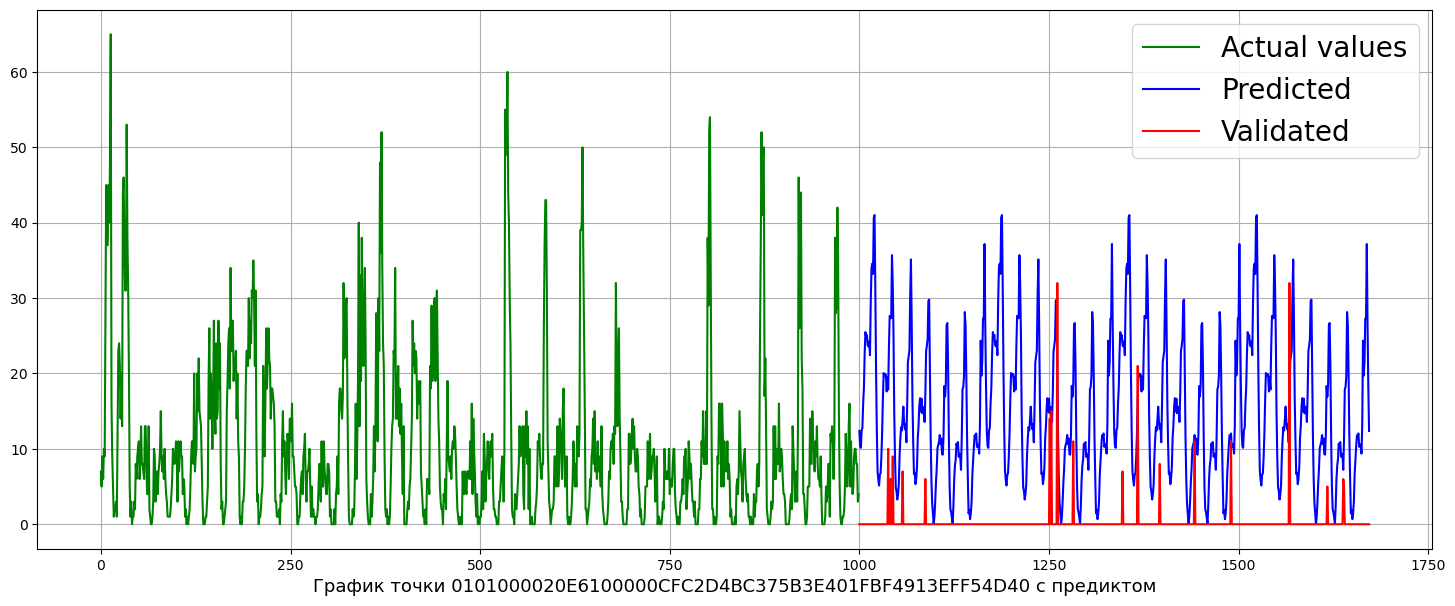

14.91590816287371


In [184]:
data_plot = loaded_samples[valid_point['point'][0]].tail(1000)
test_plot = samples_test_with_zero[valid_point['point'][0]]
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot,
             predicted_values = res_dict[valid_point['point'][0]], 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             y_name = "График точки {point} с предиктом".format(point = valid_point['point'][1]))
print(mean_absolute_error(test_plot, res_dict[valid_point['point'][0]]))

In [29]:
def get_MAE_no_zero(predict,test):
    dic_result = {}
    for key in test.keys():
        
        data_test = test[key]
        data_predict = predict[key]
        count = -1
        list_val = []
        list_pred = []
        for val in data_test['amount']:
            
            count = count + 1
            pred = data_predict[count]
            
            if val != 0:
                
                list_val.append(val)
                list_pred.append(pred)
        MAE_key = mean_absolute_error(list_val, list_pred )
        dic_result[key] = MAE_key
    total_MAE = sum(dic_result.values())/len(dic_result.keys())
    return dic_result, total_MAE

In [30]:
def get_StM_no_zero(predict,test):
    dic_result = {}
    for key in test.keys():
        
        data_test = test[key]
        data_predict = predict[key]
        count = -1
        list_val = []
        list_pred = []
        MAE_key = 0
        MAE_key_val = 0
        for val in data_test['amount']:
            
            count = count + 1
            pred = data_predict[count]
            
            if val != 0:
                
                list_val.append(val)
                MAE_key_val = MAE_key_val + (abs(pred - val)/val)
                
        MAE_key = MAE_key_val/len(list_val)
        
        
                
        
        dic_result[key] = MAE_key
    total_MAE = sum(dic_result.values())/len(dic_result.keys())
    return dic_result, total_MAE

In [31]:
## Train XgBoots one ONE point
data = loaded_samples[all_test_point['point'][4]].reset_index()

##data = data.drop('hour',axis=1)
data = data.drop('mounth',axis=1)
##data = data.drop('dayofweek',axis=1)
##data = data.drop('night',axis=1)
data = data.drop('weekend',axis=1)
data = data.loc[data['Date_hour'] <= datetime.datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S') ]
y_train = data['amount']
X_train = data.drop('amount',axis=1)
X_train = X_train.drop('Date_hour',axis=1)
test_data = loaded_samples[all_test_point['point'][4]].tail(746).reset_index()
test_data = test_data.drop('amount',axis=1)
X_test = test_data.drop('Date_hour',axis=1)
##X_test  = X_test .drop('hour',axis=1)
X_test  = X_test .drop('mounth',axis=1)
##X_test  = X_test .drop('dayofweek',axis=1)
##X_test  = X_test .drop('night',axis=1)
X_test  = X_test .drop('weekend',axis=1)


model = XGBRegressor()

params = {
      "colsample_bytree": [0.1, 0.2], # fraction of cols to sample
      "gamma": [0, 0.3], # min loss reduction required for next split
      "learning_rate": [0.05,0.1,0.15,0.20],
        'max_depth' : [2, 3, 5, 10, 15],
        'min_child_weight':[1,2,3,4],
       
    'booster':['gbtree','gblinear'],

      "n_estimators": [i for i in range(100,500,100)], # default 100
      "subsample": [0.75, 0.8] # % of rows to use in training sample
}
r = RandomizedSearchCV(model, param_distributions=params, n_iter=100,
scoring="neg_mean_absolute_error", cv=3, n_jobs=1)

xgbmodel = r.fit(X_train, y_train) 
predictions_xgb = r.predict(X_test)
predictions_xgb[predictions_xgb <= 0] = 0


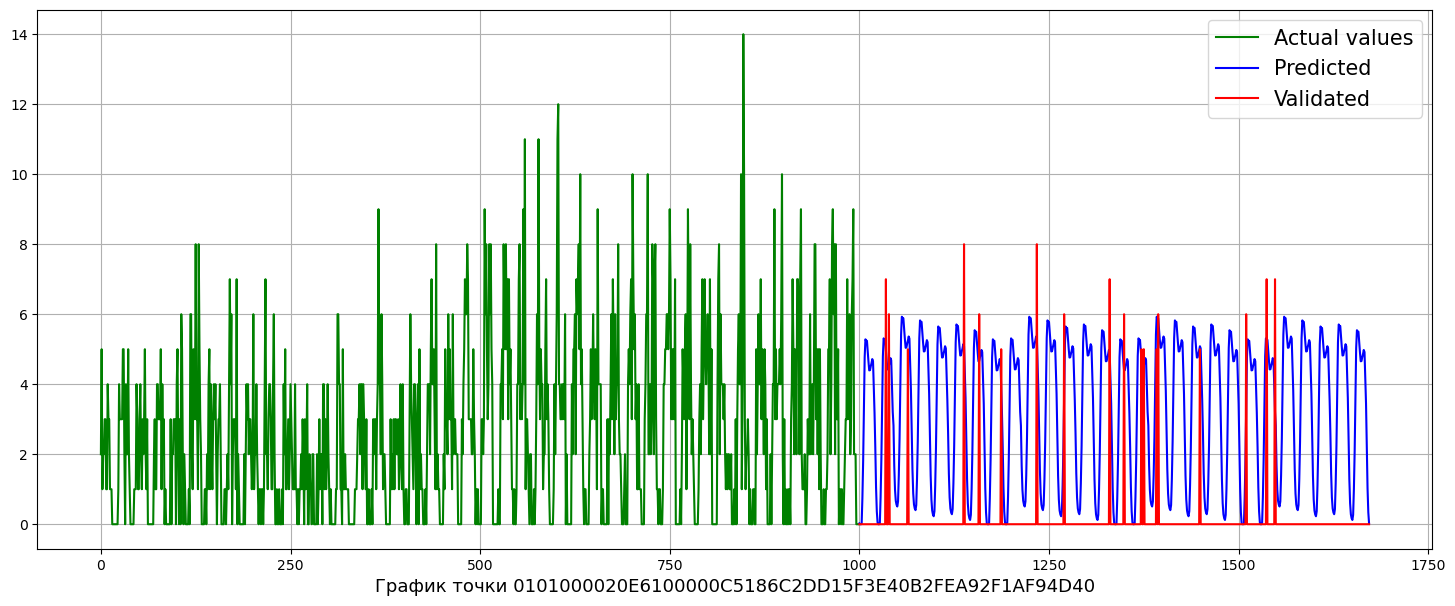

3.3098501464764394


In [260]:
## Plot relult of XhBoost training model on one point
data_plot = loaded_samples[all_test_point['point'][28]]
test_plot = samples_test_with_zero[all_test_point['point'][28]]
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 15,
             y_name = "График точки {point}".format(point = located['point'][27]))
print(mean_absolute_error(test_plot, predictions_xgb))

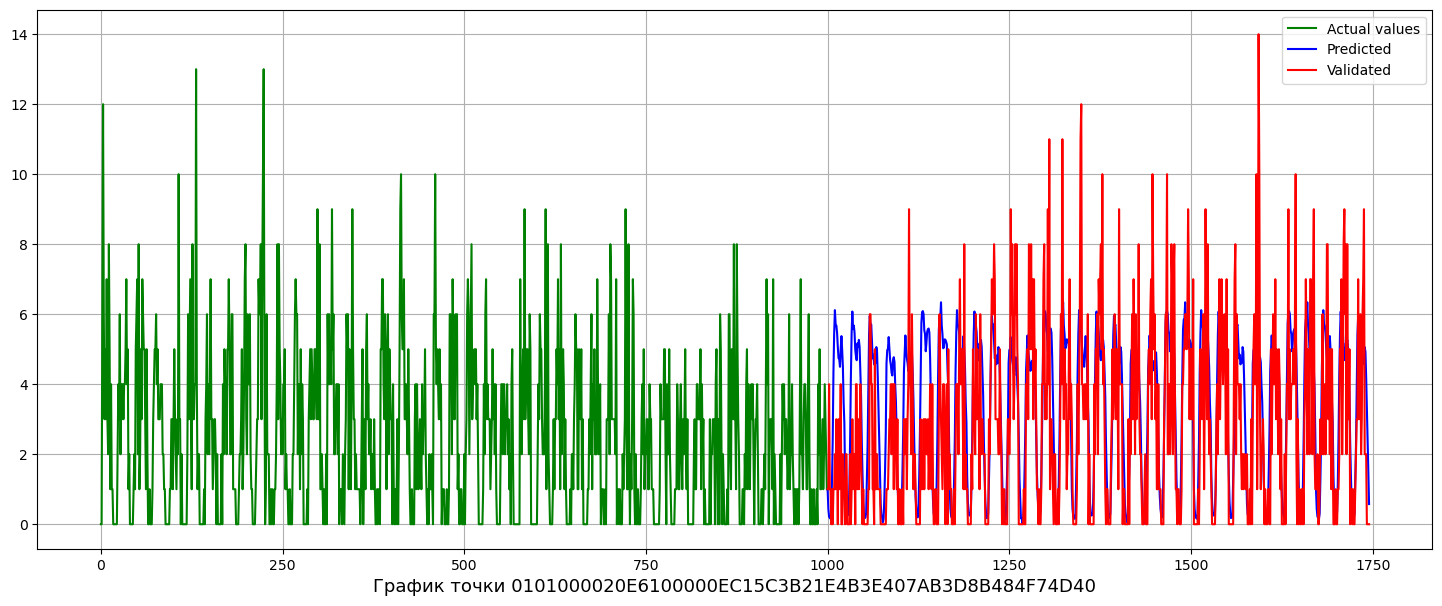

1.5886888891039042


In [268]:
data_plot = loaded_samples[all_test_point['point'][28]].head(8758)
test_plot = loaded_samples[all_test_point['point'][28]].tail(746)
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 10,
             y_name = "График точки {point}".format(point = all_test_point['point'][28]))
print(mean_absolute_error(test_plot, predictions_xgb))

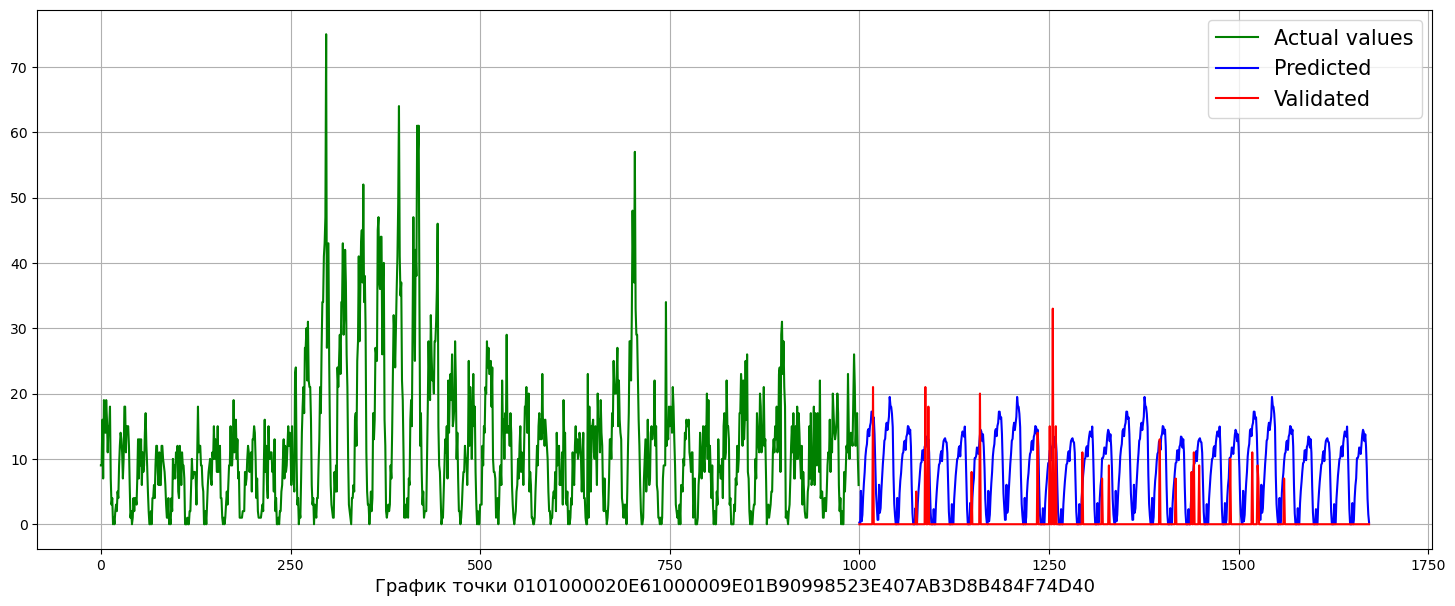

8.079175001489107


In [228]:
data_plot = loaded_samples[all_test_point['point'][14]]
test_plot = samples_test_with_zero[all_test_point['point'][14]]
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 15,
             y_name = "График точки {point}".format(point = located['point'][14]))
print(mean_absolute_error(test_plot, predictions_xgb))

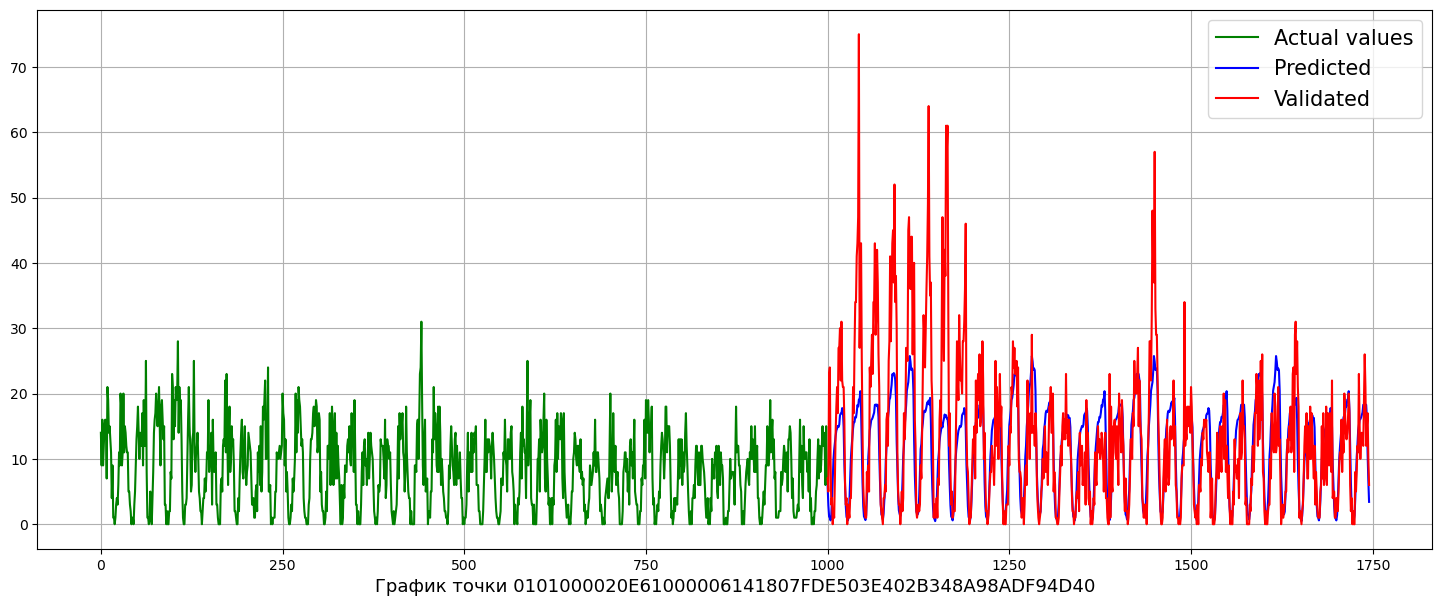

5.3192295947439225


In [226]:
data_plot = loaded_samples[all_test_point['point'][14]].head(8758)
test_plot = loaded_samples[all_test_point['point'][14]].tail(746)
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 15,
             y_name = "График точки {point}".format(point = all_test_point['point'][14]))
print(mean_absolute_error(test_plot, predictions_xgb))

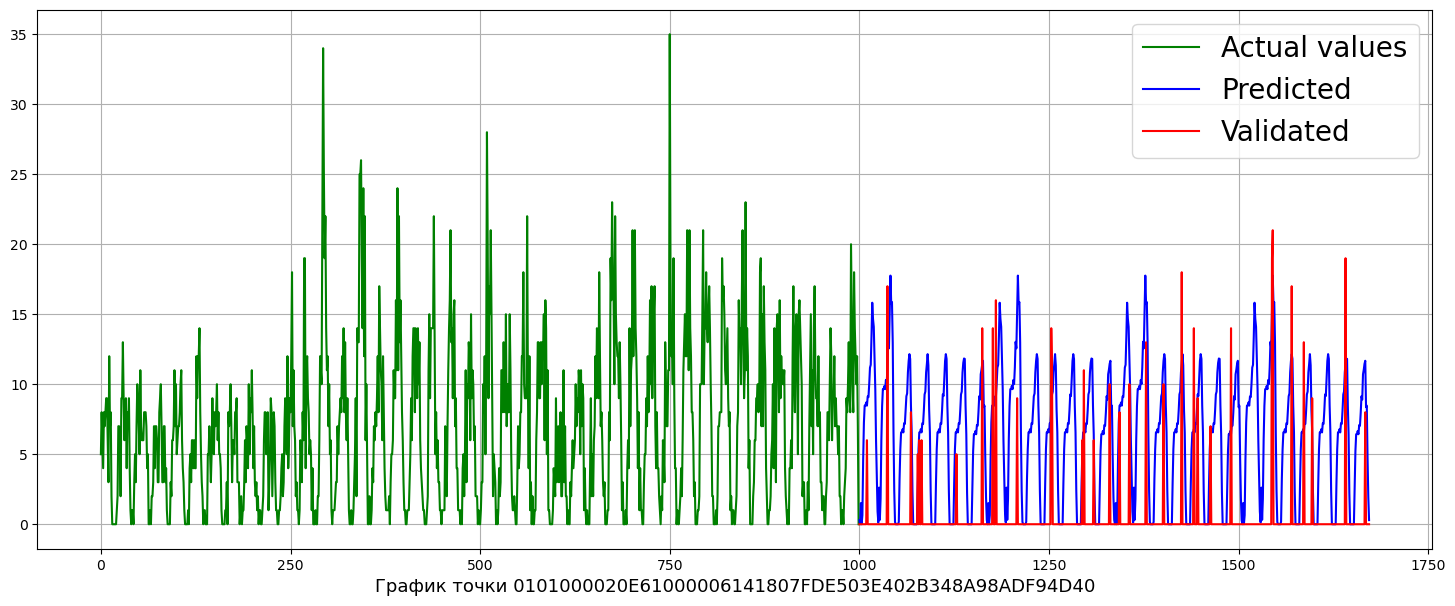

6.181486559458863


In [197]:
data_plot = loaded_samples[all_test_point['point'][4]]
test_plot = samples_test_with_zero[all_test_point['point'][4]]
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             y_name = "График точки {point}".format(point = located['point'][4]))
print(mean_absolute_error(test_plot, predictions_xgb))

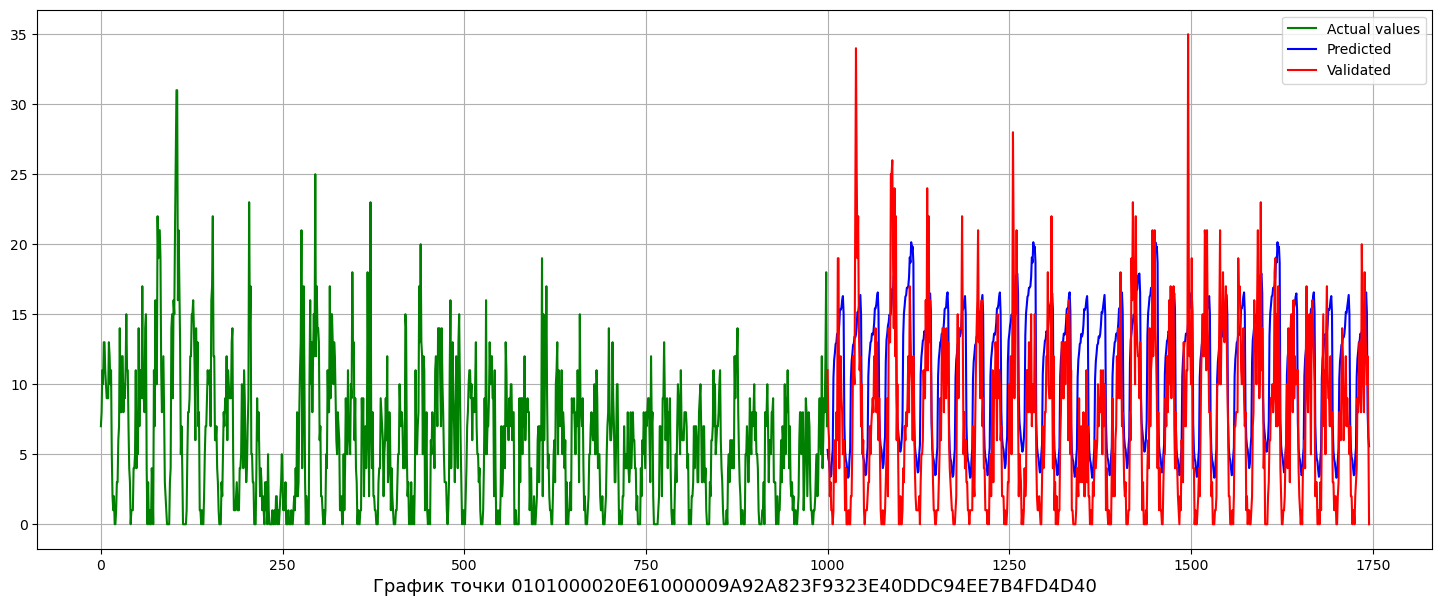

4.621747749101061


In [32]:
data_plot = loaded_samples[all_test_point['point'][4]].head(8758)
test_plot = loaded_samples[all_test_point['point'][4]].tail(746)
data_plot = data_plot['amount']
test_plot = test_plot['amount']
plot_results(actual_time_series = data_plot[-1000:],
             predicted_values = predictions_xgb, 
             valided_values = test_plot,
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             
             label_size = 10,
             y_name = "График точки {point}".format(point = all_test_point['point'][4]))
print(mean_absolute_error(test_plot, predictions_xgb))

In [33]:
import datetime
from typing import Any, List

import numpy as np
import pandas as pd
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.mutation import MutationTypesEnum
from fedot.core.pipelines.pipeline_composer_requirements import PipelineComposerRequirements
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from examples.simple.time_series_forecasting.ts_pipelines import ts_complex_ridge_pipeline
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.quality_metrics_repository import \
    RegressionMetricsEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.utils import fedot_project_root


In [34]:
## Train Fedot model on ONE point
data = loaded_samples[all_test_point['point'][12]].reset_index()
data = data.loc[data['Date_hour'] <= datetime.datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S') ]
    
node_lagged_1 = PrimaryNode('lagged')
node_lagged_1.parameters = {'window_size': 3}
node_lagged_2 = PrimaryNode('lagged')
node_lagged_2.parameters = {'window_size': 450}

node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2])
node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
complex_pipeline = Pipeline(node_final)

task = Task(TaskTypesEnum.ts_forecasting,
    TsForecastingParams(forecast_length=673))

train_array = np.array(data['amount'])
train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

start_forecast = len(train_array)
end_forecast = start_forecast + 673

forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                            features=train_array,
                            target=None,
                            task=task,
                            data_type=DataTypesEnum.ts)


complex_pipeline.fit(train_input)
predicted_output = complex_pipeline.predict(predict_input)
predicted_values = np.ravel(np.array(predicted_output.predict))
predicted_values[predicted_values <= 0] = 0        


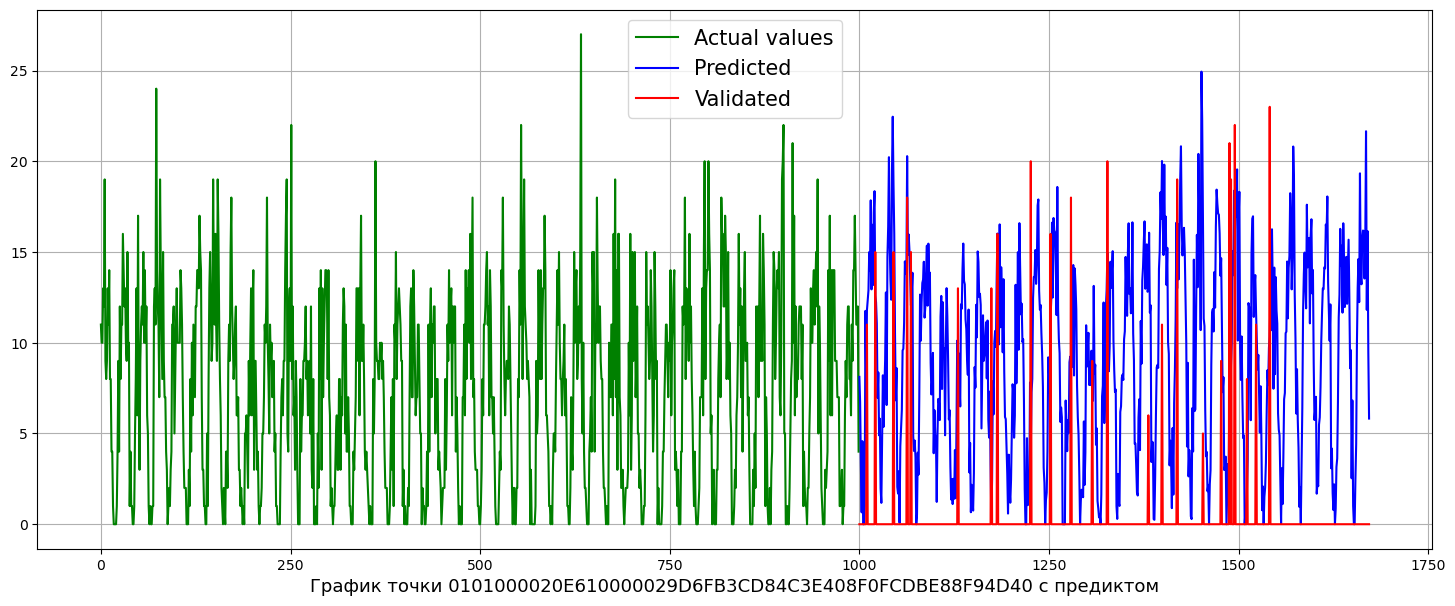

9.057713072304363


In [36]:
## Plot result on ONE point
test_plot = loaded_samples[all_test_point['point'][12]]
test_plot = test_plot['amount'].tail(1000)
plot_results(actual_time_series = test_plot,
             predicted_values = predicted_values, 
             valided_values = samples_test_with_zero[all_test_point['point'][12]],
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 15,
             y_name = "График точки {point} с предиктом".format(point = all_test_point['point'][12]))
print(mean_absolute_error( samples_test_with_zero[all_test_point['point'][12]], predicted_values))

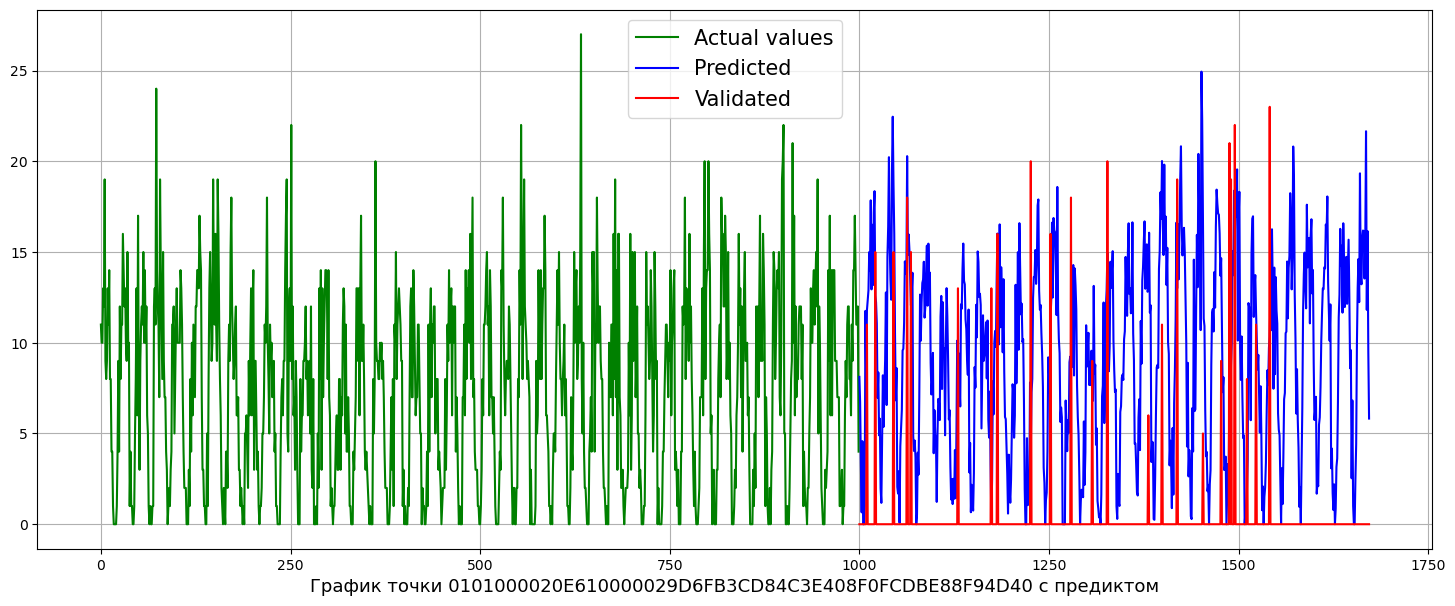

9.057713072304363


In [353]:
test_plot = loaded_samples[all_test_point['point'][12]].tail(1000)
plot_results(actual_time_series = test_plot,
             predicted_values = predicted_values, 
             valided_values = samples_test_with_zero[all_test_point['point'][12]],
             len_train_data = 1000,
             red_name = "Validated",
             blue_name = 'Predicted',
             label_size = 15,
             y_name = "График точки {point} с предиктом".format(point = all_test_point['point'][12]))
print(mean_absolute_error( samples_test_with_zero[all_test_point['point'][12]], predicted_values))

In [6]:
def get_two_branches_pipeline(lagged_param_1=30, lagged_param_2=30,
                              model_1='ridge', model_2='ridge', model_3='ridge'):
 

    # First level
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.parameters = {'window_size': lagged_param_1}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.parameters = {'window_size': lagged_param_2}

    # Second level
    node_second_1 = SecondaryNode(model_1, nodes_from=[node_lagged_1])
    node_second_2 = SecondaryNode(model_2, nodes_from=[node_lagged_2])

    # Third level - root node
    node_final = SecondaryNode(model_3, nodes_from=[node_second_1, node_second_2])
    pipeline = Pipeline(node_final)
    
    return pipeline

In [7]:
def get_available_operations():
    
    primary_operations = ['lagged', 'smoothing', 'gaussian_filter', 'ar']
    secondary_operations = ['lagged', 'ridge', 'lasso', 'knnreg', 'linear',
                            'scaling', 'ransac_lin_reg', 'rfe_lin_reg']
    return primary_operations, secondary_operations

In [89]:
## Обучение моделей

def fid_model_fedot(train_data,  forecast_length_model,data_valid_point):
    
    count = 0
    dic_predict = {}
    
    for key in data_valid_point['point']:
        count = count + 1
        print(count)
        data = train_data[key]
    
        node_lagged_1 = PrimaryNode('lagged')
        node_lagged_1.parameters = {'window_size': 3}
        node_lagged_2 = PrimaryNode('lagged')
        node_lagged_2.parameters = {'window_size': 450}

        node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
        node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2])

        node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
        complex_pipeline = Pipeline(node_final)

        task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length_model))

        train_array = np.array(data['amount'])
        train_input = InputData(idx=np.arange(0, len(train_array)),
                                features=train_array,
                                target=train_array,
                                task=task,
                                data_type=DataTypesEnum.ts)

        start_forecast = len(train_array)
        end_forecast = start_forecast + forecast_length_model

        forecast_idx = np.arange(start_forecast, end_forecast)
        predict_input = InputData(idx=forecast_idx,
                                  features=train_array,
                                  target=None,
                                  task=task,
                                  data_type=DataTypesEnum.ts)


        complex_pipeline.fit(train_input)
        predicted_output = complex_pipeline.predict(predict_input)
        predicted_values = np.ravel(np.array(predicted_output.predict))
        
        dic_predict[key] = predicted_values
        
    return dic_predict

In [124]:
## Train Fedot model on ALL points
dic_pred_Fedot = fid_model_fedot(loaded_samples,  673, all_test_point)
dic_pred_Fedot

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186


{'0101000020E6100000EC2F1F510A6D3E4058AA511532F34D40': array([ 5.03706622e-01, -2.59906914e-01, -9.33031462e-01,  1.75109242e+00,
         7.71210121e-01,  3.03616480e+00,  4.41365880e+00,  9.32968453e+00,
         1.33762936e+01,  1.15238993e+01,  9.37944744e+00,  1.30516393e+01,
         1.30379531e+01,  1.18736387e+01,  8.80517023e+00,  9.25259401e+00,
         9.32218642e+00,  9.67043256e+00,  1.02611606e+01,  1.49800341e+01,
         1.21957866e+01,  9.54828254e+00,  6.80103736e+00,  2.14888842e+00,
         6.75411897e-01,  9.98818591e-01,  6.60407605e-01,  9.17249558e-01,
         5.15989911e-01,  3.98925849e+00,  6.77999313e+00,  8.67197094e+00,
         1.06255677e+01,  1.16627353e+01,  1.07017925e+01,  1.07122646e+01,
         1.16434340e+01,  1.19601201e+01,  1.24179827e+01,  1.04957600e+01,
         1.03458612e+01,  1.20102808e+01,  9.80728769e+00,  1.25290047e+01,
         9.53561768e+00,  1.09931511e+01,  5.58389371e+00,  1.11188137e+00,
        -2.29372822e-01, -2.876685

In [5]:
## Load and Save for Fedot model predicts 
##np.save('dic_predcits_Fedot.npy', dic_pred_Fedot) 
dic_predcits_Fedot = np.load('dic_predcits_Fedot.npy',allow_pickle='TRUE').item()

In [6]:
## Load and Save for XgBoost model predicts 
##np.save('dic_predcits_Xgb.npy', res_dict) 
dic_predcits_Xgb = np.load('dic_predcits_Xgb.npy',allow_pickle='TRUE').item()

In [26]:
## Load MAE result of Fedot model
##p.save('dic_res_Fedot_MAE.npy', dic_res_Fedot) 
dic_res_Fedot_MAE = np.load('dic_res_Fedot_MAE.npy',allow_pickle='TRUE').item()

In [32]:
## Load Mean result of Fedot model
##np.save('dic_res_Fedot_Std.npy', dic_res_Fedot_Std) 
dic_res_Fedot_Std= np.load('dic_res_Fedot_Std.npy',allow_pickle='TRUE').item()

In [38]:
## Load MAE result of XgBoost model
##np.save('dic_res_Xgb_MAE.npy', dic_res_Xgb) 
dic_res_Xgb_MAE = np.load('dic_res_Xgb_MAE.npy',allow_pickle='TRUE').item()

In [39]:
## Load Mean result of XgBoost model
##np.save('dic_res_Xgb_Std.npy', dic_res_Xgb_Std) 
dic_res_Xgb_Std= np.load('dic_res_Xgb_Std.npy',allow_pickle='TRUE').item()

In [125]:
## Get Mean metric result for all point and for per point of Fedot model
dic_res_Fedot_Std , Std_Fedot = get_StM_no_zero(dic_pred_Fedot,samples_test_with_zero)
Std_Fedot

0.6464548299222682

In [126]:
## Get MAE metric result for all point and for per point of Fedot model
dic_res_Fedot , MAE_Fedot = get_MAE_no_zero(dic_pred_Fedot,samples_test_with_zero)
MAE_Fedot

5.386267263803187

In [156]:
## Get Mean metric result for all point and for per point of XgBoost model
dic_res_Xgb_Std , Std_Xgb = get_StM_no_zero(res_dict,samples_test_with_zero)
Std_Xgb

0.6232036623927445

In [157]:
## Get MAE metric result for all point and for per point of XgBoost model
dic_res_Xgb , MAE_Xgb = get_MAE_no_zero(res_dict,samples_test_with_zero)
MAE_Xgb

4.902687669764966

In [40]:
## Get only MAE result Fedot predict of first test set 
res_only_test_Fedot_MAE = {}
for i in test_point['point'].tolist():
    vala = dic_res_Fedot_MAE[i]
    res_only_test_Fedot_MAE[i] = vala
len(res_only_test_Fedot_MAE)

145

In [41]:
## Get only MAE result Fedot predict of second test set 
res_only_valid_Fedot_MAE = {}
for i in valid_point['point'].tolist():
    vala = dic_res_Fedot_MAE[i]
    res_only_valid_Fedot_MAE[i] = vala
len(res_only_valid_Fedot_MAE)

150

In [52]:
## Get only Mean result Fedot predict of first test set 
res_only_test_Fedot_Std = {}
for i in test_point['point'].tolist():
    vala = dic_res_Fedot_Std[i]
    res_only_test_Fedot_Std[i] = vala
len(res_only_test_Fedot_Std)

145

In [51]:
## Get only Mean result Fedot predict of second test set 
res_only_valid_Fedot_Std = {}
for i in valid_point['point'].tolist():
    vala = dic_res_Fedot_Std[i]
    res_only_valid_Fedot_Std[i] = vala
len(res_only_valid_Fedot_Std)

150

In [59]:
## Get only MAE result XgBoost predict of first test set  
res_only_test_Xgb_MAE = {}
for i in test_point['point'].tolist():
    vala = dic_res_Xgb_MAE[i]
    res_only_test_Xgb_MAE[i] = vala
len(res_only_test_Xgb_MAE)

145

In [61]:
## Get only MAE result XgBoost predict of second test set  
res_only_valid_Xgb_MAE = {}
for i in valid_point['point'].tolist():
    vala = dic_res_Xgb_MAE[i]
    res_only_valid_Xgb_MAE[i] = vala
len(res_only_valid_Xgb_MAE)

150

In [63]:
## Get only Mean result XgBoost predict of first test set  
res_only_test_Xgb_Std = {}
for i in test_point['point'].tolist():
    vala = dic_res_Xgb_Std[i]
    res_only_test_Xgb_Std[i] = vala
len(res_only_test_Xgb_Std)

145

In [64]:
## Get only Mean result XgBoost predict of second test set  
res_only_valid_Xgb_Std = {}
for i in valid_point['point'].tolist():
    vala = dic_res_Xgb_Std[i]
    res_only_valid_Xgb_Std[i] = vala
len(res_only_valid_Xgb_Std)

150

In [44]:
## Show MAE result of Fedot model on first test set
date = {'Point':res_only_test_Fedot_MAE.keys(),
        'MAE': res_only_test_Fedot_MAE.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['MAE'].describe()

count    145.000000
mean       5.506304
std       11.382313
min        1.473138
25%        2.971402
50%        3.577687
75%        4.382660
max      131.294111
Name: MAE, dtype: float64

In [45]:
## Show MAE result of Fedot model on second test set
date = {'Point':res_only_valid_Fedot_MAE.keys(),
        'MAE': res_only_valid_Fedot_MAE.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['MAE'].describe()

count    150.000000
mean       5.661123
std       11.182547
min        0.620963
25%        2.958282
50%        3.675922
75%        4.859976
max      131.294111
Name: MAE, dtype: float64

In [53]:
## Show Mean result of Fedot model on first test set
date = {'Point':res_only_test_Fedot_Std.keys(),
        'Mean': res_only_test_Fedot_Std.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['Mean'].describe()

count    145.000000
mean       0.619655
std        0.614099
min        0.202900
25%        0.394634
50%        0.564264
75%        0.698029
max        7.368858
Name: Mean, dtype: float64

In [54]:
## Show Mean result of Fedot model on second test set
date = {'Point':res_only_valid_Fedot_Std.keys(),
        'Mean': res_only_valid_Fedot_Std.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['Mean'].describe()

count    150.000000
mean       0.631761
std        0.613259
min        0.124193
25%        0.399163
50%        0.570442
75%        0.728517
max        7.368858
Name: Mean, dtype: float64

In [60]:
## Show MAE result of XgBoost model on first test set
date = {'Point':res_only_test_Xgb_MAE.keys(),
        'MAE': res_only_test_Xgb_MAE.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['MAE'].describe()

count    145.000000
mean       4.943243
std        3.861970
min        1.118725
25%        3.192566
50%        3.949405
75%        5.027554
max       27.072322
Name: MAE, dtype: float64

In [62]:
## Show MAE result of XgBoost model on second test set
date = {'Point':res_only_valid_Xgb_MAE.keys(),
        'MAE': res_only_valid_Xgb_MAE.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['MAE'].describe()

count    150.000000
mean       5.065150
std        3.825178
min        0.402907
25%        3.158786
50%        4.011471
75%        5.369232
max       27.072322
Name: MAE, dtype: float64

In [65]:
## Show Mean result of XgBoost model on first test set
date = {'Point':res_only_test_Xgb_Std.keys(),
        'Mean': res_only_test_Xgb_Std.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['Mean'].describe()

count    145.000000
mean       0.601107
std        0.192499
min        0.165893
25%        0.483127
50%        0.584191
75%        0.744590
max        1.007729
Name: Mean, dtype: float64

In [66]:
## Show Mean result of XgBoost model on second test set
date = {'Point':res_only_valid_Xgb_Std.keys(),
        'Mean': res_only_valid_Xgb_Std.values()}
table_Fedot_MAE = pd.DataFrame(date)
table_Fedot_MAE['Mean'].describe()

count    150.000000
mean       0.602670
std        0.200482
min        0.080581
25%        0.482503
50%        0.579264
75%        0.755745
max        1.007729
Name: Mean, dtype: float64